# run2019 analysis

This notebook documents the analysis of the 2019 data. 
In the first section, the [expected rate](#expected-rate) is discussed. 
In the second section, the [differential rate](#differential-rate) is computed from the run 2019 data.
In the third and last section, the [noise stability](#noise-stability) is computed and presented.

load the necessary modules

In [1]:
%load_ext autoreload
%autoreload 2
import iarray as ia
import run2019
import matplotlib.pyplot as plt

In [2]:
ia.plt.rcParams['font.size'] = 15

## expected rate

In this section, the expected rate is computed for each CCD.
Firstly, the [neutrino flux](#neutrino-flux) is taken from the table [reactorFlux.csv](https://github.com/PhMota/CONNIEtools/blob/master/data/reactorFlux.csv) and expanded with the parametrization in appendix A of [arxiv.org/abs/1910.04951](https://arxiv.org/abs/1910.04951) until 10 MeV of neutrino energy.
Secondly, the cross section is computed following the specifications in section 2 of [arxiv.org/abs/1910.04951](https://arxiv.org/abs/1910.04951) and integrated against the neutrino flux from the reactor to produce the Silicon recoil energy rate.
Then, in order to convert this into the electron ionization energy rate, different quenching factors are used: Lindhard (from the [parametrization](#Lindhard)), Chavarria (parametrization from [arxiv.org/abs/1910.04951](https://arxiv.org/abs/1910.04951)) and two versions of Sarkis (from [SarkisPRD.csv](https://github.com/PhMota/CONNIEtools/blob/master/data/SarkisPRD.csv) and [SarkisAN.csv](https://github.com/PhMota/CONNIEtools/blob/master/data/SarkisAtNucl.csv))

Next, the [acceptance](#acceptance) for each CCD is computed by comparing the reconstruction rate from simulations and multiplied individually for the ionization energy rate.
In order to introduce the uncertainty in the energy reconstruction, the [energy dispersion](#energy-dispersion) is computed from the simulations and convoluted to the acceptance corrected ionization rate.
Finally, the [selection cuts efficiency](#efficiency-rate) is applied by taking into account the rate of reconstructed simulated events that pass the selection cuts.

### neutrino flux

The neutrino reactor flux is
$$
\frac{d\Phi}{d E_{\nu}} = \frac{ d^3 N_{\nu} }{ d E_{\nu} d\sigma dt }
$$
is taken from the [reactorFlux.csv](https://github.com/PhMota/CONNIEtools/blob/master/data/reactorFlux.csv) table with units counts/MeV/cm$^2$/s as a function of the neutrino energy in MeV.

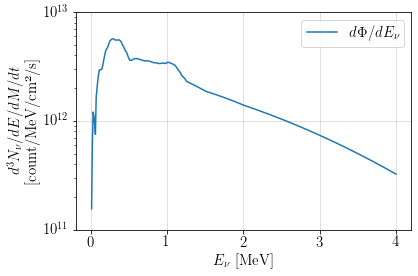

In [3]:
def flux_nu():
    return ia.genfromcsv(
        "data/reactorFlux.csv", 
        x = dict( name=r"$E_\nu$", unit=ia.MeV, dim="Enu" ), 
        y = dict( name=r"$d\Phi/d E_\nu$", unit=ia.ureg("counts/MeV/cm^2/s") ) 
    )
def plot_flux_nu():
    flux_nu().xplot(ylabel=r"$d^3N_\nu/dE/dM/dt$", yscale="log")
    plt.ylim((1e11, 1e13))
    plt.grid(True)
    
plot_flux_nu()

For the sake of comparison, the plot in fig. 4 of the paper [arxiv.org/abs/1910.04951](https://arxiv.org/abs/1910.04951) is shown below. 
![alt text](data/fluxReactor.png "the title")

Below, the full dataset is shown also for convenience.

In [4]:
print( flux_nu() )

<xarray.DataArray '$d\\Phi/d E_\\nu$' (Enu: 400)>
<Quantity([1.55300186e+11 6.00503436e+11 1.20516768e+12 1.11701484e+12
 9.34386939e+11 7.51759038e+11 1.64258521e+12 1.97112465e+12
 2.30794992e+12 2.64851397e+12 2.92198769e+12 2.95330734e+12
 2.94983050e+12 2.96517146e+12 3.07291462e+12 3.37381601e+12
 3.65395081e+12 3.97697077e+12 4.28082371e+12 4.48887215e+12
 4.61950810e+12 4.75014404e+12 4.96186152e+12 5.21922696e+12
 5.44713539e+12 5.52522055e+12 5.60330571e+12 5.68139086e+12
 5.70284656e+12 5.64880513e+12 5.59476369e+12 5.54072225e+12
 5.52901080e+12 5.53527709e+12 5.54154338e+12 5.54780966e+12
 5.55407595e+12 5.49767185e+12 5.41842799e+12 5.30341781e+12
 5.08069372e+12 4.93916689e+12 4.77320209e+12 4.61211644e+12
 4.46827118e+12 4.34018525e+12 4.22987843e+12 4.04930827e+12
 3.87849229e+12 3.74236159e+12 3.61679297e+12 3.60926581e+12
 3.60173865e+12 3.62459352e+12 3.66521013e+12 3.69833076e+12
 3.73145140e+12 3.73592981e+12 3.73563285e+12 3.73533589e+12
 3.73282561e+12 3.7155553

It is important to notice that the table ends at $E_{\mu} = 4$ MeV where the flux is one order of magnitude below the peak.
For the purpose of this analysis, tail of the flux for higher neutrino energies will play an important role.
Therefore, the parametriation present in [paper]() is used and matched with the last point from the flux table.

<xarray.DataArray (Enu: 3)>
<Quantity([1.14725030e+12 1.14728487e+12 1.14731951e+12], 'count / centimeter ** 2 / megaelectron_volt / second')>
Coordinates:
    $E_\nu$  (Enu) float64 [MeV] 3.98 3.99 4.0
Dimensions without coordinates: Enu


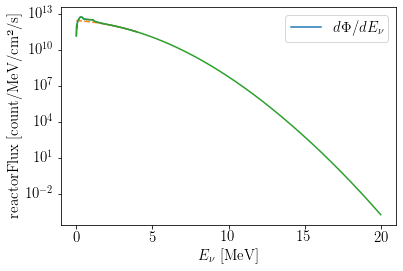

In [5]:
def flux_fit(E, N=1.14732e12):
    fit = lambda E, a, a0, a1, a2: a*ia.np.exp(a0 + a1*E/ia.MeV + a2*(E/ia.MeV)**2)
    flux_U235 = lambda E: fit(E, 1.0461, 0.870, -0.160, -0.091)
    flux_Pu239 = lambda E: fit(E, 1.0527, 0.896, -0.239, -0.0981)
    flux_U238 = lambda E: fit(E, 1.0719, 0.976, -0.162, -0.079)
    flux_Pu241 = lambda E: fit(E, 1.0818, 0.793, -0.080, -0.1085)
    return N*(.55*flux_U235(E) + .32*flux_Pu239(E) + .07*flux_U238(E) + .06*flux_Pu241(E)) # * ia.ureg("count/MeV/cm^2/s")

print( flux_nu()[-3:]/flux_fit(flux_nu()[r"$E_\nu$"][-3:], N=1) )

def E_nu( Emin=.01, Emax=20, Ebinsize=.01):
    return ia.xr.DataArray(
        name = r"$E_\nu$",
#         data = ia.np.arange(.01, 20, .01) * ia.MeV,
        data = ia.np.arange( Emin, Emax, Ebinsize ) * ia.MeV,
        dims = "Enu"
    )
    
def reactor_flux( Emin=.01, Emax=20, Ebinsize=.01 ):
    _E_nu = E_nu(Emin, Emax, Ebinsize)
    _flux_nu = flux_nu()
    return ia.xr.DataArray(
        name = r"reactorFlux",
        data = ia.np.concatenate( 
            [
                _flux_nu.pint.magnitude, 
                flux_fit(_E_nu[ _E_nu > _flux_nu[r"$E_\nu$"][-1] ]).data.magnitude
            ], 
            axis=0 ) * _flux_nu.pint.units,
        dims = _flux_nu.dims,
        coords = {r"$E_\nu$": _E_nu}
    )

flux_nu().xplot(ylabel="$d^3N_\nu/dE/dM/dt$")
plt.plot( flux_nu()[r"$E_\nu$"].pint.magnitude, flux_fit(flux_nu()[r"$E_\nu$"]).pint.magnitude, "--" )
reactor_flux(.01, 20, .01).xplot()
plt.yscale("log")

The combined flux extended up to 10 MeV is shown below.

In [6]:
print( reactor_flux() )

<xarray.DataArray 'reactorFlux' (Enu: 1999)>
<Quantity([1.55300186e+11 6.00503436e+11 1.20516768e+12 ... 1.98019100e-04
 1.91504258e-04 1.85201033e-04], 'count / centimeter ** 2 / megaelectron_volt / second')>
Coordinates:
    $E_\nu$  (Enu) float64 [MeV] 0.01 0.02 0.03 0.04 ... 19.96 19.97 19.98 19.99
Dimensions without coordinates: Enu


### Silicon recoil energy rate 

The rate of recoil events is obtained by convoluting the neutrino flux with the cross section and multiplying by the number of Silicon nuclei per kg
$$
\frac{dR}{d E_R} = N_T \int_{E_\nu^\text{min}}^\infty dE_\nu \frac{d\Phi}{dE_\nu} \frac{d\sigma}{dE_R}
$$
which can be expressed as
$$
\frac{d^3N}{d E_R dM dt} = \frac{dN_T}{dM} \int_{E_\nu^\text{min}}^\infty dE_\nu \frac{d^3 N}{dE_\nu d\sigma dt} \frac{d\sigma}{dE_R}
$$
where the minimal neutrino energy capable of generating a Silicon recoil energy is
$$
E_\nu^\text{min} = \frac{1}{2} \left( E_R + \sqrt{ E_R^2 + 2ME_R } \right)
$$

Also, the total number of Silicon nuclei is needed for the rate
$$
\frac{dN_T}{dM} = \frac{6.022 \cdot 10^{23} }{28.084 \cdot 10^{-3} \text{kg}}
$$

#### cross section

The Standard Model CEvNS cross section is taken from the [paper]() as
$$
\frac{ d\sigma }{d E_{\rm R}} = \frac{G_F^2}{4\pi} Q_W^2 \left(
    1 - \frac{E_R}{E_\nu} + (E_R - M)\frac{E_R}{2E_\nu^2}
\right) M F^2
$$
where the constants are
$$
G_F = 1.1663787 \cdot 10^{-5} \text{GeV}^{-2}\quad \text{Fermi constant}
\\
Q_W = N = 14 \quad \text{weak nuclear charge}
\\
M = 28.085 \text{u} = 28.085 \cdot 9.314 \cdot 10^5 \text{keV}\quad \text{Silicon atomic mass}
\\
F = 1 \quad \text{nuclear form factor}
$$

First, the Silicon recoil energy coordinate is defined.

In [319]:
def E_R_range( Emin=0, Emax=5, Ebinsize=.001):
    return ia.Coord(r"$E_{\rm R}$", "Er", ia.arange(Emin, Emax, Ebinsize)*ia.keV )

The lower limit of the integration corresponds to the minimum neutrino energy capable of generating a Silicon recoil.

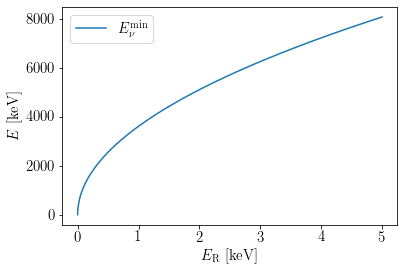

In [8]:
def E_nu_min(Emin=0, Emax=5, Ebinsize=.001):
    _E_R = E_R(Emin, Emax, Ebinsize)
    M = run2019.M_Si_amu * ia.amu
    return ia.Array(r"$E_\nu^{\rm min}$", data = ( _E_R + ia.sqrt( _E_R**2 + 2*M*_E_R) )/2 )

E_nu_min().xplot( ylabel=r"$E$" )

Below, the cross section as a function of the Silicon recoil and the incoming neutrino energies is presented.

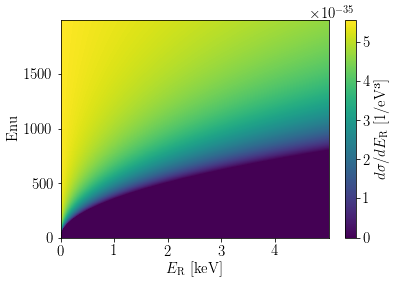

In [321]:
def dsigma__dE_R( 
    ER = E_R_range(0, 5, .001),
    Enu = E_nu(.01, 20, .01)
):
#     ER = E_R(*range_R)
    M = run2019.M_Si_amu * ia.amu
    Enu_min = ia.Array(r"$E_\nu^{\rm min}$", data = ( ER + ia.sqrt( ER**2 + 2*M*ER) )/2 )
    F = 1
    QW = 14
    GF = 1.1663787e-5 / ia.GeV**2.
#     Enu = E_nu(*range_nu)
#     Enu_min = E_nu_min(Emin_nu, Emax_nu, Ebinsize_nu)
    data = GF**2./(4*ia.pi) * QW**2. * ( 1 - ER/Enu + ER*(ER - M)/2/Enu**2. ) * M * F**2.
    return ia.Array( r"$d\sigma/dE_{\rm R}$", data = data ).where( Enu > Enu_min, 0 )

dsigma__dE_R().xplot()

Finally, the Silicon recoil rate is obtained by convoluting the reactor flux with the cross section.

However, the differential cross section is at natural units, while the neutrino flux is in SI. 
In order to make them compatible, the quantities are converted to barn.
$$
\text{SI:}\quad \text{cm}^2 = 10^{27}\text{mb}
\\
\text{natural:}\quad \text{GeV}^{-2} = \frac{1}{2.56819} \text{mb}
$$
dividing both gives
$$
\text{cm}^2\text{GeV}^2 = 2.56819 \cdot 10^{27}
$$

Below, the Silicon recoil rate is shown together with the calculation performed by Brenda in the [BrendaEr.csv](https://github.com/PhMota/CONNIEtools/blob/master/data/BrendaEr.csv).

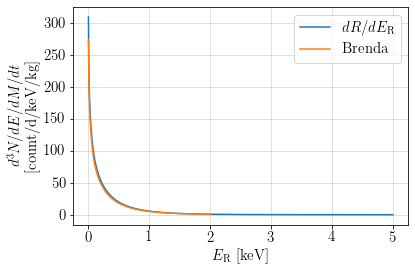

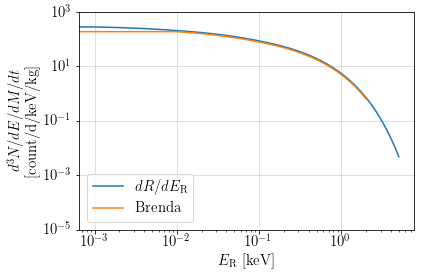

In [322]:
def dR__dE_R( E_R=E_R_range(0, 5, .001), flux_nu=reactor_flux() ):
    to_barn = ia.ureg( "cm^2.*GeV^2." )/2.568e27
    N_T = (6.022e23/(28.084 * ia.ureg.g) ).to('1/kg')
    return ia.Array(
        r"$dR/dE_{\rm R}$",
        data = ( N_T * flux_nu * dsigma__dE_R( E_R, flux_nu.xcoords[0] ) * to_barn)
    ).integrate( flux_nu.xcoords[0].name ).pint.to("count/keV/kg/day")

# def dR__dE_R(
#     range_R = (0, 5, .001),
#     range_nu = (.01, 20, .01)
# ):
#     _reactor_flux = reactor_flux(*range_nu)
#     to_barn = ia.ureg( "cm^2.*GeV^2." )/2.568e27
#     N_T = (6.022e23/(28.084 * ia.ureg.g) ).to('1/kg')
#     return ia.Array(
#         r"$dR/dE_{\rm R}$",
#         data = ( N_T * _reactor_flux * dsigma__dE_R(range_R, range_nu) * to_barn)
#     ).integrate( _reactor_flux.xcoords[0].name ).pint.to("count/keV/kg/day")

dR__dE_R().xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
plt.plot( *ia.np.genfromtxt("data/BrendaEr.csv", delimiter=",").T, label="Brenda" )
plt.legend()
plt.grid(True);
plt.show()
dR__dE_R().xplot(ylabel=r"$d^3N/dE/dM/dt$", yscale="log", xscale="log", unit="count/keV/kg/day")
plt.plot( *ia.np.genfromtxt("data/BrendaEr.csv", delimiter=",").T, label="Brenda" )
plt.legend()
plt.ylim((1e-5,1e3))
plt.grid(True)

![alt text](data/paperQuenching.png "the title")

Figure 4. Left: The expected recoil energy spectrum (blue dashed line); the visible energy spectrum
assuming a Lindhard Q factor (red solid line); the visible energy spectrum with Lindhard Q factor and
the effect of the detector efficiency (green dashed line). Right: Total event rate as a function of the
energy threshold for various quenching factors. The shaded area shows the expected signal region for a
threshold of 5σRMS ' 28 eV, and realistic quenching factors. Adapted from [9].

from: 1608.01565.pdf

### ionization rate

The ionization energy is obtained by computing the conversion factor between the Silicon recoil energy and the electron ionization energy
$$
\frac{dE_R}{dE_I}(E_I) = \frac{d}{dE_I}\left(\frac{E_I}{Q(E_I)}\right) 
\\ = \frac{1}{Q(E_I)^2}\left( Q(E_I) - E_I \frac{dQ}{dE_I}(E_I) \right)
$$
where $Q(E_I)$ is the quenching factor $E_I = Q(E_I) E_R$.
In other words, the quenching factor is the fraction of the recoil energy that is converted into ionization energy.

Therefore,
$$
\frac{d^3N}{dE_IdMdt}(E_I) = \frac{dE_R}{dE_I}(E_I) \frac{d^3N}{dE_RdMdt}\left( \frac{E_I}{Q(E_I)} \right)
\\ = \frac{1}{Q(E_I)^2}\left( Q(E_I) - E_I \frac{dQ}{dE_I}(E_I) \right) \frac{d^3N}{dE_RdMdt}\left( \frac{E_I}{Q(E_I)} \right)
$$


#### Lindhard

The Lindhard quenching factor is given by the following model.
$$
Q(E_R) = \frac{c_z E_R - \nu(c_z E_R) }{c_z E_R} 
= \frac{1}{c_z E_R}\left( c_z E_R - \frac{c_z E_R}{1 + k g(c_z E_R)} \right)
\\
= 1 - \frac{1}{1 + k g(c_z E_R)}
$$
where, $c_z = 11.5/Z^{7/3}/$keV, $k=0.133Z^{2/3}/A^{1/2}$ and 
$$
g(\epsilon) = 3 \epsilon^{0.15} + 0.7 \epsilon^{0.6} + \epsilon
$$
for Silicon $A=28$, $Z=14$

In [270]:
def Lindhard_Q( Erange ):
    _E_R = E_R( *Erange )
    A = 28
    Z = 14
    c_z = 11.5/Z**(7/3)/ia.keV
    k = 0.133*Z**(2/3)/A**.5
    g = lambda e: 3*e**.15 + .7*e**.6 + e
    return 1 - 1/(1+k*g(c_z*_E_R))

Q_L = Lindhard_Q( (.01, 5, .01) )
Q_L.name = "Lindhard"
Q_L[r"$E_{\rm I}$"] = E_R(.01, 5, .01) * Q_L
print( Q_L )
# plt.plot( E_R.pint.magnitude, Q_L.pint.magnitude, label = "Lindhard" )
# plt.plot( (E_I/Q(E_I)).pint.magnitude, Q(E_I).pint.magnitude, label = "Chavarria" )
# plt.xlabel(r"$E_{\rm R}$")
# plt.ylabel(r"$Q(E_{\rm R})$")
# plt.xlim((-.05,3))
# plt.legend();

<xarray.DataArray 'Lindhard' (Er: 499)>
<Quantity([0.1122628  0.1232908  0.13020966 0.13534316 0.13945992 0.14291464
 0.14590172 0.14853975 0.15090666 0.1530565  0.15502839 0.15685155
 0.15854846 0.16013677 0.16163058 0.1630414  0.1643787  0.16565038
 0.16686312 0.16802262 0.16913375 0.17020074 0.17122728 0.17221662
 0.17317159 0.17409473 0.1749883  0.17585432 0.17669459 0.17751077
 0.17830433 0.17907661 0.17982886 0.18056218 0.18127761 0.18197609
 0.18265849 0.18332562 0.18397822 0.18461698 0.18524254 0.18585549
 0.1864564  0.18704577 0.1876241  0.18819184 0.18874941 0.18929722
 0.18983564 0.19036503 0.19088573 0.19139804 0.19190227 0.1923987
 0.19288759 0.19336921 0.19384379 0.19431156 0.19477274 0.19522754
 0.19567615 0.19611875 0.19655554 0.19698668 0.19741234 0.19783267
 0.19824782 0.19865793 0.19906314 0.19946359 0.1998594  0.20025069
 0.20063757 0.20102017 0.20139858 0.20177291 0.20214326 0.20250972
 0.2028724  0.20323137 0.20358672 0.20393853 0.20428689 0.20463188
 0.20497356 0

#### Chavarria

The Chavarria's quenching factor is parametrized as below [paper]()

In [324]:
def Chavarria_Q( Erange = (.001, 5, .001) ):
    E_I = ia.Coord(r"$E_{\rm I}$", "Ei", ia.arange(*Erange)*ia.keV )
#     print( E_I )
    p0 = 56 * ia.keV**3.
    p1 = 1096 * ia.keV**2
    p2 = 382 * ia.keV
    p3 = 168 * ia.keV**2
    p4 = 155 * ia.keV
    N = p3*E_I + p4*E_I**2 + E_I**3
    D = p0 + p1*E_I + p2*E_I**2
    return ia.Array( r"$Q(E_{\rm I})$", data = N/D )

Chavarria = Chavarria_Q()
Chavarria.name = "Chavarria"
Chavarria[r"$E_{\rm R}$"] = E_I/Chavarria 
print( Chavarria )

<xarray.DataArray 'Chavarria' (Ei: 4999)>
<Quantity([0.00294511 0.00578449 0.00852391 ... 0.32078433 0.32079864 0.32081295], 'dimensionless')>
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.001 0.002 0.003 ... 4.997 4.998 4.999
    $E_{\rm R}$  (Ei) float64 [keV] 0.3395 0.3458 0.352 ... 15.58 15.58 15.58
Dimensions without coordinates: Ei


#### Sarkis

The Sarkis' quenching factor is taken from the table [SarkisPRD.csv]() for the case with 300 eV threshold and [SarkisAtNucl.csv] for 60 eV.

In [325]:
Sarkis_PRD = ia.genfromcsv(
    "data/SarkisPRD.csv", 
    x = {"name": r"$E_{\rm R}$", "unit": ia.keV}, 
    y = {"unit": 1},
)
Sarkis_AN = ia.genfromcsv(
    "data/SarkisAtNucl.csv", 
    x = {"name": r"$E_{\rm R}$", "unit": ia.keV}, 
    y = {"unit": 1},
)
Sarkis_PRD.name = "SarkisPRD"
Sarkis_PRD[r"$E_{\rm I}$"] = Sarkis_PRD * Sarkis_PRD[r"$E_{\rm R}$"]

Sarkis_AN.name = "SarkisAN"
uniqueE, idxE = ia.unique( Sarkis_AN[r"$E_{\rm R}$"].pint.magnitude, return_index=True )
Sarkis_AN = Sarkis_AN[idxE]
Sarkis_AN[r"$E_{\rm I}$"] = Sarkis_AN * Sarkis_AN[r"$E_{\rm R}$"]

The comparison of the quenching factors as a function of the recoil energy, showing the threshold of minimum ionization energy

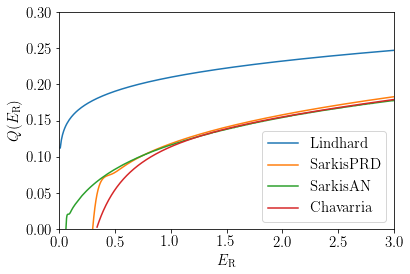

In [326]:
for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm R}$"].pint.magnitude,
        quenching.pint.magnitude,
        label = quenching.name
    )
plt.xlim(( 0, 3 ))
plt.ylim(( 0, .3 ))
plt.xlabel(r"$E_{\rm R}$")
plt.ylabel(r"$Q(E_{\rm R})$")
plt.legend();

Below, the quenching factors are compared as a function of the ionization energy.

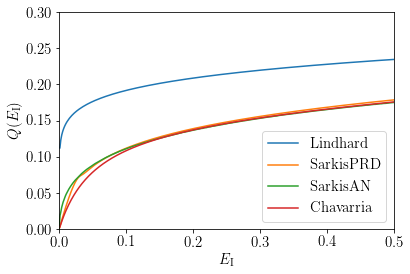

In [327]:
for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
        quenching.pint.magnitude,
        label = quenching.name
    )
plt.xlim(( 0, .5 ))
plt.ylim(( 0, .3 ))
plt.xlabel(r"$E_{\rm I}$")
plt.ylabel(r"$Q(E_{\rm I})$")
plt.legend();

Below, the relation between the recoil energy and the ionization energies is shown for each quenching factor.

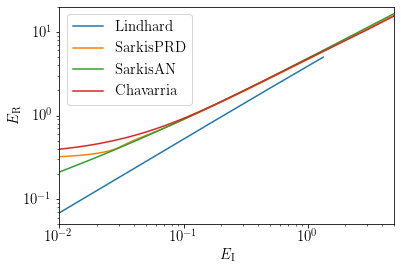

In [328]:
for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
        quenching.coords[r"$E_{\rm R}$"].pint.magnitude,
        label = quenching.name
    )
plt.xlim(( 1e-2, 5 ))
plt.ylim(( 5e-2, 20 ))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_{\rm I}$")
plt.ylabel(r"$E_{\rm R}$")
plt.legend();

For the sake of comparison, the plot from [paper]() is shown below.

![alt text](data/quenchingParametrized.png "the title")

Below, we compute the convertion factors between the recoil and ionization energies for the quenching factors.

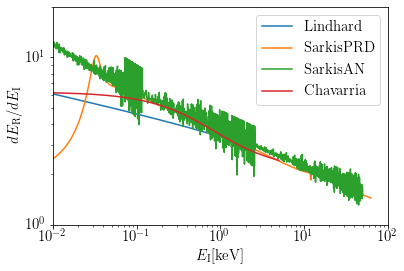

In [329]:
def dE_R__dE_I_from_R(Q):
    data = 1/Q - Q[r"$E_{\rm I}$"]/Q**2 * Q.xdiff(r"$E_{\rm I}$")
    return data

for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
        dE_R__dE_I_from_R(quenching).pint.magnitude,
        label = quenching.name
    )

plt.xlabel( r"$E_{\rm I}$[keV]" )
plt.ylabel( r"$dE_{\rm R}/dE_{\rm I}$" )
plt.xlim((1e-2,1e2))
plt.ylim((1, 20))
plt.yscale("log")
plt.xscale("log")
plt.legend();

Finally, the ionization rate is obtained and shown below for each quenching factor.

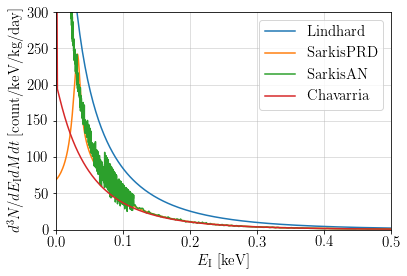

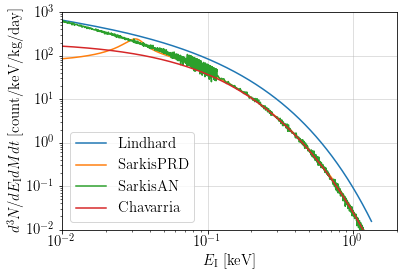

In [333]:
def dR__dE_I_from_R(Q, flux_nu=reactor_flux()):
    data = dR__dE_R( Q[r"$E_{\rm R}$"], flux_nu) * dE_R__dE_I_from_R(Q)
    data["name"] = r"$dR/dE_{\rm I}$"
    return data

# def dR__dE_I_from_R(
#     Q,
#     range_R = (0, 5, .001),
#     range_nu = (.01, 20, .01),
# ):
#     a = dR__dE_R( range_R, range_nu )
#     a["Er"] = a[r"$E_{\rm R}$"].pint.magnitude
#     print( a )
#     b = dE_R__dE_I_from_R(Q)
#     b["Er"] = b[r"$E_{\rm R}$"].pint.magnitude 
#     print( b )
#     b = b.pint.dequantify().interp( coords = {"Er": a["Er"]} )
#     print( b )
#     data = a*b
#     data["name"] = r"$dR/dE_{\rm I}$"
#     return data

for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
        #dR__dE_I_from_R(quenching, reactor_flux).pint.magnitude,
        dR__dE_I_from_R(quenching).pint.magnitude,
        label = quenching.name
    )

plt.xlabel( r"$E_{\rm I}$ [keV]" )
plt.ylabel( r"$d^3N/dE_{\rm I}dMdt$ [count/keV/kg/day]" )
plt.legend();

plt.ylim( (0, 300) )
plt.xlim( (0,.5) )

plt.grid(True)
plt.show()

for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
    plt.plot(
        quenching.coords[r"$E_{\rm I}$"].pint.magnitude,
#         dR__dE_I_from_R(quenching, reactor_flux).pint.magnitude,
        dR__dE_I_from_R(quenching).pint.magnitude,
        label = quenching.name
    )

plt.xlabel( r"$E_{\rm I}$ [keV]" )
plt.ylabel( r"$d^3N/dE_{\rm I}dMdt$ [count/keV/kg/day]" )
plt.legend();

plt.ylim( (1e-2, 1e3) )
plt.xlim( (1e-2,2) )
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

As a last step, all quenchings are interpolated to the same coordinates.

<xarray.Dataset>
Dimensions:      (Ei: 990)
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.01 0.011 0.012 0.013 ... 0.997 0.998 0.999
  * Ei           (Ei) float64 0.01 0.011 0.012 0.013 ... 0.996 0.997 0.998 0.999
Data variables:
    Lindhard     (Ei) float64 655.0 619.7 586.8 ... 0.09287 0.09236 0.09185
    SarkisPRD    (Ei) float64 84.71 87.19 89.9 92.88 ... 0.02728 0.02713 0.02697
    SarkisAN     (Ei) float64 608.9 556.6 541.1 491.2 ... 0.0254 0.02647 0.02719
    Chavarria    (Ei) float64 165.1 161.8 158.6 ... 0.02513 0.02499 0.02485


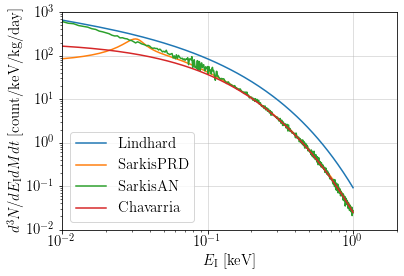

In [429]:
def dR__dE_I_from_R(Q, flux_nu=reactor_flux() ):
    data = dR__dE_R( Q[r"$E_{\rm R}$"], flux_nu) * dE_R__dE_I_from_R(Q)
    data.name = r"$dR/dE_{\rm I}$"
    return data

def quenchingFactors( Erange, plot=False ):
    _quenchingFactors = ia.xr.Dataset()
    for quenching in [Q_L, Sarkis_PRD, Sarkis_AN, Chavarria]:
        this = dR__dE_I_from_R(quenching)
        this = this.rename({this.dims[0]: "Ei"})
        this["Ei"] = this[r"$E_{\rm I}$"].pint.magnitude
        this = this.pint.dequantify().interp( coords = {this.dims[0]: ia.arange(*Erange) } )
        _quenchingFactors[ quenching.name ] = this
        if plot: plt.plot(
                this.coords[r"$E_{\rm I}$"].pint.magnitude,
                this.pint.magnitude, #.interp(coord={}),
                label = quenching.name
            )
    _quenchingFactors[r"$E_{\rm I}$"] = _quenchingFactors[r"$E_{\rm I}$"] * ia.keV
    del _quenchingFactors[r"$E_{\rm R}$"]
    if plot:
        print( _quenchingFactors )
        plt.xlabel( r"$E_{\rm I}$ [keV]" )
        plt.ylabel( r"$d^3N/dE_{\rm I}dMdt$ [count/keV/kg/day]" )
        plt.legend();

        plt.ylim( (1e-2, 1e3) )
        plt.xlim( (1e-2,2) )
        plt.yscale("log")
        plt.xscale("log")
        plt.grid(True)
    return _quenchingFactors

quenchingFactors( (.01, 1, .001), plot=True );

In [406]:
E_I = quenchingFactors[r"$E_{\rm I}$"]
E_I.name = ""
E_I = E_I.pint.quantify()
E_I.name = r"$E_{\rm I}$"
del E_I["E"]
del E_I[r"$E_{\rm I}$"]
print(E_I)

TypeError: 'function' object is not subscriptable

In [410]:
def E_I_range( min=0, max=1, binsize=.001):
    return ia.Coord(r"$E_{\rm I}$", "Ei", ia.arange(min, max, binsize)*ia.keV )    

### acceptance rate

The acceptance is computed  by simulating events with given ionization energies and confirming the rate of reconstruction
$$
\frac{dN}{dE_I} = {\cal A}(E_{\rm I})\frac{dN_S}{dE_I},
$$

#### simulation

The simulated spectrum is shown below

call genfromroot({'Ei': ('oEnergy', 'eV'), 'hdu': 'hdu'})
return genfromroot({'Ei': ('oEnergy', 'eV'), 'hdu': 'hdu'})
call genfromroot({'Ei': ('oEnergy', 'eV'), 'hdu': 'hdu'})
return genfromroot({'Ei': ('oEnergy', 'eV'), 'hdu': 'hdu'})
<xarray.Dataset>
Dimensions:          (Ei: 98, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$      (Ei) float64 [keV] 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98
Dimensions without coordinates: Ei
Data variables:
    $dN/dE_{\rm I}$  (hdu, Ei) object [count/keV] 0.0+/-0 ... (1.48+/-0.04)e+05


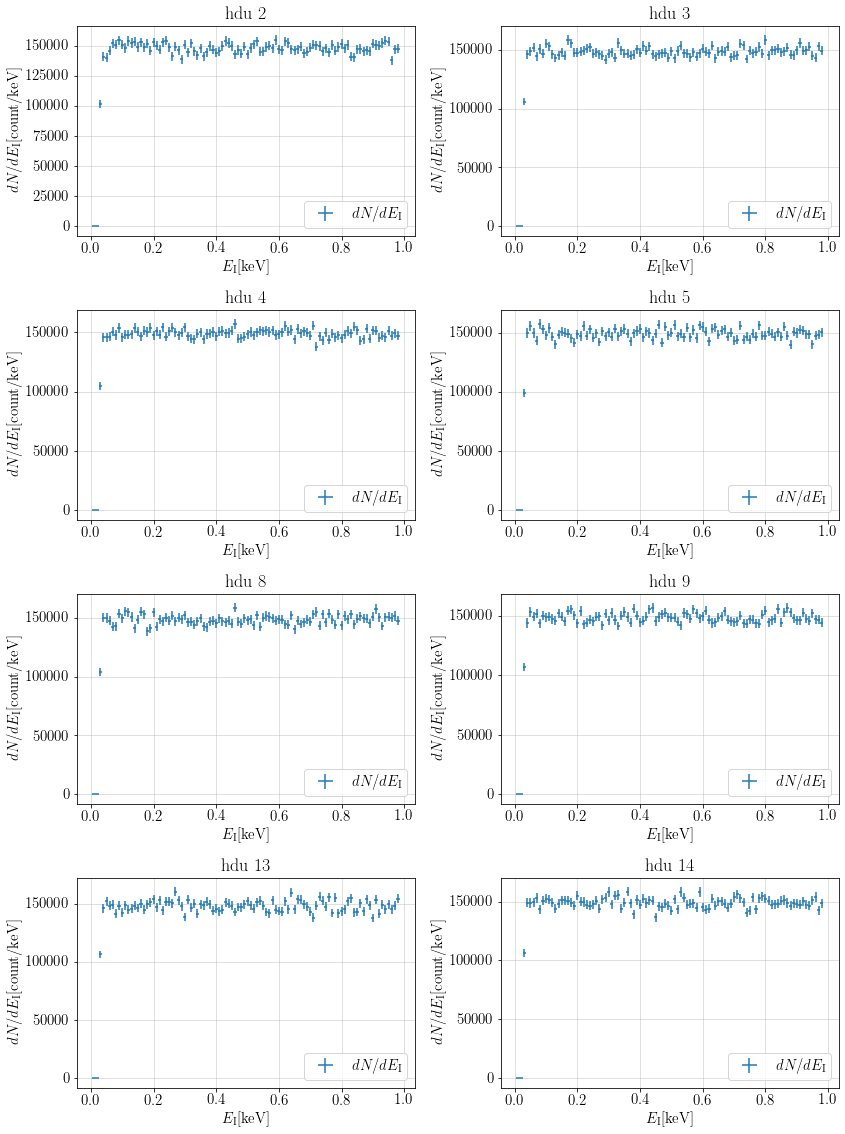

In [411]:
import iarray as ia        
def events( cut ):
    return ia.genfromroot( 
        run2019.sim_files, 
        treename="hitSumm",  
        branches = {"Ei": ("oEnergy", "eV"), "hdu": "hdu"},
        cut = str(cut*run2019.excluded_hdu),
    )

ON_SIM = events( run2019.on_excl )
def dNsim__dE_I( Erange, cut=None ):
    if cut == "on":
        data = ON_SIM
    else:
        data = events(cut)
    return data.xhistogram("hdu", centers=E_I_range(*Erange), per_bin=True)


#### matching

For the matching criterium, the maximal distance between the reconstructed and the simulated events is taken to be 1.5 pixels.

In [635]:
def events_match(cut, distSim=1.5):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"Ei": ("oEnergy", "eV"), "hdu": "ohdu"},
        cut = str(cut*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )

ON_MATCH = events_match(run2019.on_excl)
def dNmatch__dE_I( Erange, cut=None, distSim=1.5 ):
    if cut == "on":
        data = ON_MATCH
    else:
        data = events_match(cut)
    return data.xhistogram("hdu", centers=E_I_range(*Erange), per_bin=True)


call genfromroot({'Ei': ('oEnergy', 'eV'), 'hdu': 'ohdu'})
return genfromroot({'Ei': ('oEnergy', 'eV'), 'hdu': 'ohdu'})


In [644]:
def print_dNsim_match( Erange=(0, 1, .01), cut="on" ):
    dN = dNsim__dE_I( 
        Erange, 
        cut=cut
    )
    dN2 = dNmatch__dE_I( 
        Erange, 
        cut=cut
    )
    dN.update(dN2)
    print( dN )
    

print_dNsim_match()
# ia.iprint(
#     dNsim__dE_I( 
#         Erange=(0, 1, .01), 
#         cut=run2019.on_excl 
#     )
# ).xerrorbar(x=r"$E_{\rm I}$", y=r"$dN/dE_{\rm I}$", z="hdu", fmt=" ")
# ia.iprint(
#     dNmatch__dE_I( 
#         Erange=(0,1,.01), 
#         cut=run2019.on_excl 
#     )
# ).xerrorbar(x=r"$E_{\rm I}$", y=r"$dN/dE_{\rm I}$", z="hdu", fmt=" ")

<xarray.Dataset>
Dimensions:          (Ei: 98, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$      (Ei) float64 [keV] 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98
Dimensions without coordinates: Ei
Data variables:
    $dN/dE_{\rm I}$  (hdu, Ei) object [count/keV] 0.0+/-0 ... (1.30+/-0.04)e+05


#### acceptance

<xarray.Dataset>
Dimensions:             (Ei: 98, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$         (Ei) float64 [keV] 0.01 0.02 0.03 ... 0.96 0.97 0.98
Dimensions without coordinates: Ei
Data variables:
    $\mathcal{A}(E_I)$  (hdu, Ei) object [] 0.0 0.0 ... 0.874+/-0.033


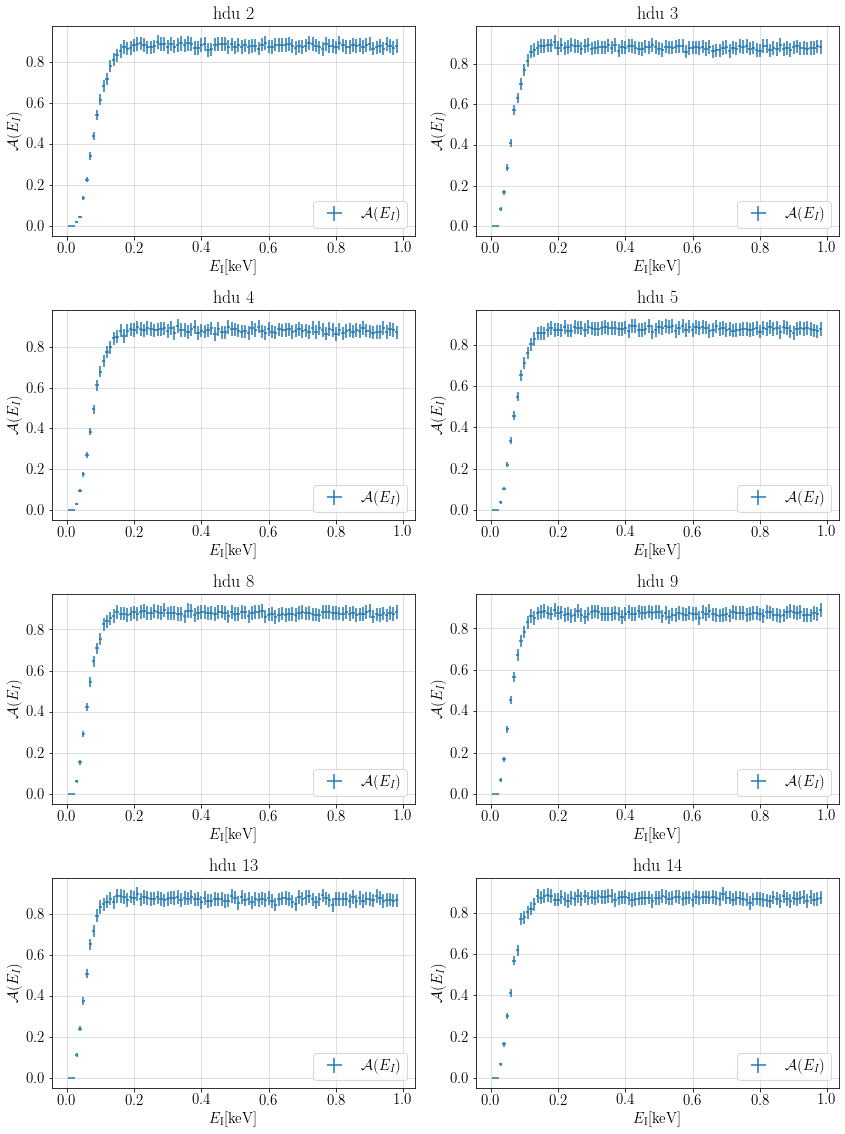

In [413]:
def Acceptance(Erange, cut):
    sim = dNsim__dE_I(Erange, cut)[r"$dN/dE_{\rm I}$"]
    match = dNmatch__dE_I(Erange, cut)[r"$dN/dE_{\rm I}$"]
    sim_where = sim.where(sim.pint.magnitude>0, 1*sim.pint.units)
    match_where = match.where(sim.pint.magnitude>0, 0*sim.pint.units)
    return ia.xr.Dataset(
        data_vars = {r"$\mathcal{A}(E_I)$": match_where/sim_where }
    )

ia.iprint(
    Acceptance(
        (0, 1, .01), 
        "on"
    )
).xerrorbar(
    x=r"$E_{\rm I}$", 
    y=r"$\mathcal{A}(E_I)$", 
    z="hdu", 
    cols_wrap=2,
    fmt = " "
)

Below, the acceptance is shown and parametrized using a fast falling fitting function,
$$
p_{2} \left(
    \frac{1}{2}\tanh\left( 
        \frac{x-p_1}{p_0}
    \right) + \frac{1}{2}
\right)^{10}
=
p_{2} \text{step}( x-p_1, p_0 )^{10}
$$

In [598]:
step = lambda x, p: ia.np.tanh(x/p)/2 + 1/2
tanhFit = lambda x, *p, step=step: p[2]*step(x - p[1], p[0])**10
tanhFit_str = "p[2]*step(x - p[1], p[0] )**10"

da_errorbar


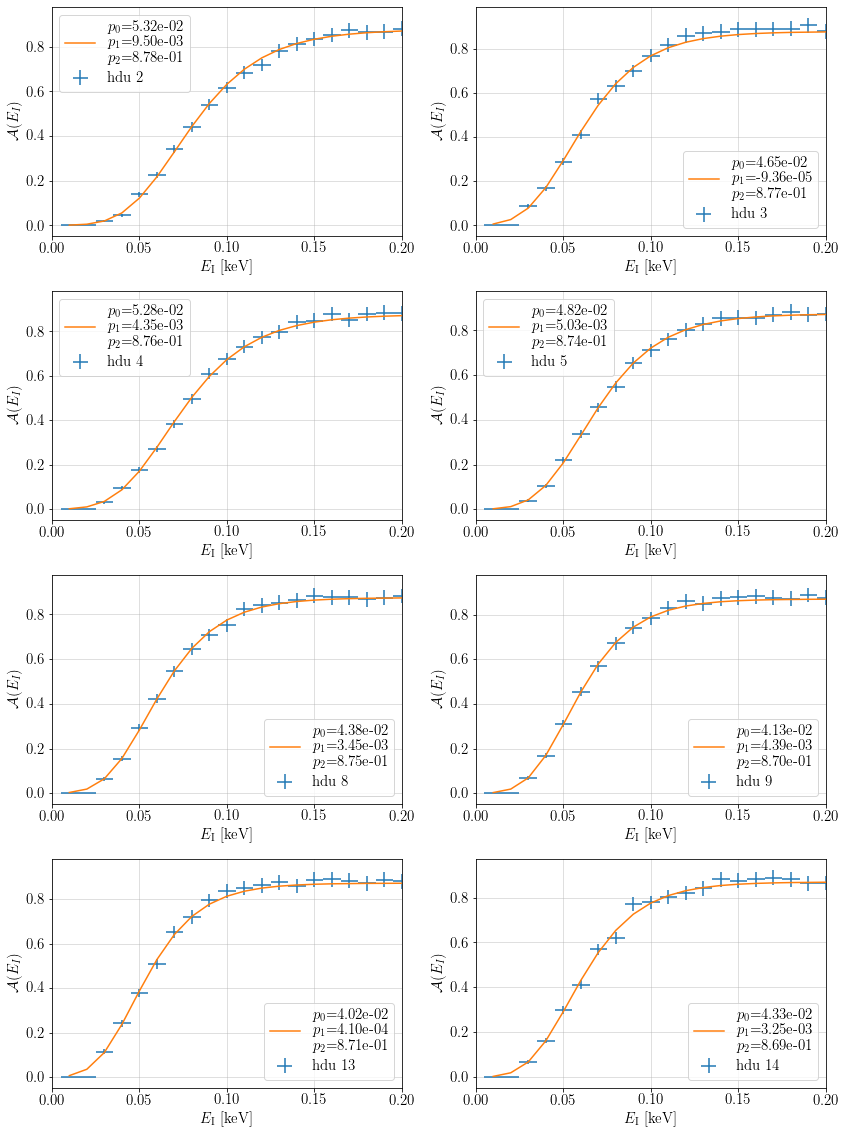

In [725]:
Acceptance(Erange=(0,2.5,.01), cut="on")[r"$\mathcal{A}(E_I)$"].curve_fit(
    x = r"$E_{\rm I}$", 
    z = "hdu", 
    func = tanhFit,
    p0 = [ .05, .01, .9 ]
).errorbar(
    x=r"$E_{\rm I}$", 
    z="hdu", 
    cols_wrap=2,
    xlim=(0,.2)
);

<xarray.DataArray (hdu: 8, params: 3)>
array([[ 5.34832424e-02,  9.35339757e-03,  8.80603674e-01],
       [ 4.73606753e-02, -7.35388921e-04,  8.85973125e-01],
       [ 5.34550115e-02,  3.93684962e-03,  8.83505890e-01],
       [ 4.85329216e-02,  4.82034035e-03,  8.77909670e-01],
       [ 4.42790314e-02,  3.14268203e-03,  8.79956512e-01],
       [ 4.16548315e-02,  4.11064725e-03,  8.74307261e-01],
       [ 4.07616994e-02, -5.13738287e-05,  8.78019690e-01],
       [ 4.37184736e-02,  2.96714276e-03,  8.73645249e-01]])
Coordinates:
  * hdu      (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: params
Attributes:
    func:     <function <lambda> at 0x7f4710d3c2f0>
    fit:      [0.04371847 0.00296714 0.87364525]
0 2
[0.05348324 0.0093534  0.88060367]
6 13
[ 4.07616994e-02 -5.13738287e-05  8.78019690e-01]


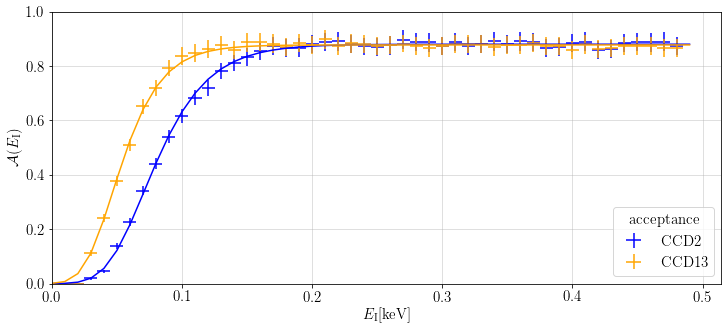

In [633]:
acc_fit = Acceptance(Erange=( 0, .5, .01 ), cut="on")[r"$\mathcal{A}(E_I)$"].curve_fit(
    x = r"$E_{\rm I}$", 
    z = "hdu", 
    func = tanhFit,
    p0 = [ .05, .01, .9 ]
)
with plt.rc_context({'figure.figsize': (12, 5)}):
    print( acc_fit.attrs["fit"] )
    for i, hdu in enumerate(acc_fit["hdu"].pint.magnitude):
        if not hdu in [2, 13]:
            continue
        color = {2: "blue", 13: "orange"}[hdu]
        label = {2: "CCD2", 13: "CCD13"}[hdu]
        print( i, hdu )
        x = acc_fit[r"$E_{\rm I}$"].pint.magnitude
        plt.errorbar(
            x,
            ia.un.nominal_values(acc_fit[i,:].pint.magnitude),
            xerr = (x[1]-x[0])/2,
            yerr = ia.un.std_devs(acc_fit[i,:].pint.magnitude),
            fmt = " ",
            color = color,
            label = label
        )
        x = ia.np.arange(0, .5, 0.01)
        print( acc_fit.attrs["fit"][i].values )
        plt.plot(
            x,
            acc_fit.attrs["fit"].attrs["func"](x, *acc_fit.attrs["fit"][i].values),
            color = color
        )
    plt.xlabel(r"$E_{\rm I}$[keV]")
    plt.ylabel(r"${\mathcal A}(E_{\rm I})$")
    plt.xlim((0,None))
    plt.ylim((0,1))
    plt.legend(title="acceptance")
    plt.grid()

In [597]:
def A_fit( Erange, period, func, p0, v=False ):
    a = Acceptance( Erange, period )[r"$\mathcal{A}(E_I)$"].curve_fit(
        x = r"$E_{\rm I}$", 
        z = "hdu", 
        func = func,
        p0 = p0
    )
    fit = a.attrs["fit"]
    if v: print( fit )
    x = a[r"$E_{\rm I}$"].pint.magnitude
    if v: print("x", x)
    b = [ fit.attrs["func"]( x, *fit.sel(hdu=sel).data ) for sel in fit["hdu"] ]
    return ia.xr.DataArray(
        b, 
        dims=["hdu", "Ei"],
        coords = {
            r"$E_{\rm I}$": a[r"$E_{\rm I}$"],
            "hdu": a["hdu"]
        }
    )#.set_coords(E_I=E_I, hdu=a["hdu"])

ia.iprint(
    A_fit(
        (0, 2.5, .01), 
        "on", 
        tanhFit, 
        [ .05, .01, .9 ],
        v = True
    )
);

<xarray.DataArray (hdu: 8, params: 3)>
array([[ 5.32242992e-02,  9.50128656e-03,  8.77836855e-01],
       [ 4.64638062e-02, -9.35906038e-05,  8.76817772e-01],
       [ 5.27871432e-02,  4.34668779e-03,  8.76479702e-01],
       [ 4.82075675e-02,  5.02730818e-03,  8.74411078e-01],
       [ 4.38400538e-02,  3.44508787e-03,  8.75237312e-01],
       [ 4.12512695e-02,  4.38889134e-03,  8.69607084e-01],
       [ 4.01517238e-02,  4.09737820e-04,  8.71278224e-01],
       [ 4.33109708e-02,  3.24769942e-03,  8.69103751e-01]])
Coordinates:
  * hdu      (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: params
Attributes:
    func:     <function <lambda> at 0x7f46a172c8c8>
    fit:      [0.04331097 0.0032477  0.86910375]
x [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0

Finally, the acceptation corrected ionization rate is shown below.
This takes into account, the limitation of the processing chain to reconstruct simulated events for a given ionization (simulated) energy.

Q
<xarray.Dataset>
Dimensions:      (Ei: 990)
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.01 0.011 0.012 0.013 ... 0.997 0.998 0.999
  * Ei           (Ei) float64 0.01 0.011 0.012 0.013 ... 0.996 0.997 0.998 0.999
Data variables:
    Lindhard     (Ei) float64 655.0 619.7 586.8 ... 0.09287 0.09236 0.09185
    SarkisPRD    (Ei) float64 84.71 87.19 89.9 92.88 ... 0.02728 0.02713 0.02697
    SarkisAN     (Ei) float64 608.9 556.6 541.1 491.2 ... 0.0254 0.02647 0.02719
    Chavarria    (Ei) float64 165.1 161.8 158.6 ... 0.02513 0.02499 0.02485


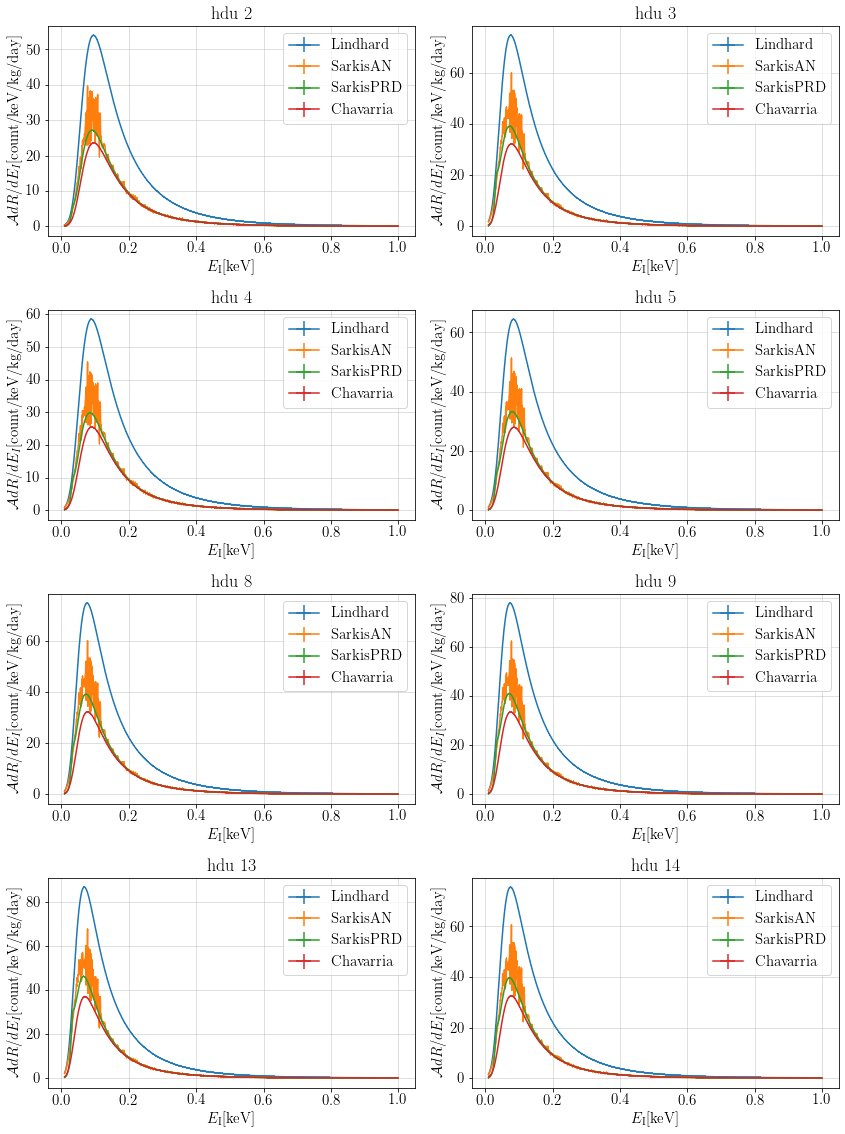

In [466]:
def AdR__dE_I(Erange, period, flux_nu=reactor_flux(), func=tanhFit, p0=[10,10,10], v=False):
    Q = quenchingFactors(Erange)
    if v:
        print("Q")
        print(Q)
    a = A_fit( 
        (Erange[0]-Erange[2], Erange[1]+Erange[2], Erange[2]), 
        period, 
        func, 
        p0,
        v
    )
    if v: 
        print("Afit")
        print( a )
    ret = a*Q
    ret[r"$E_{\rm I}$"] = ret["Ei"] * ia.ureg.keV
    ret = ret.set_coords(r"$E_{\rm I}$")
#     ret["name"] = r"$\mathcal{A}dR/dE_I$"
    if v:
        print("ret")
        print( ret )
    return ret

( AdR__dE_I( (.01, 1, .001), "on") ).xerrorbar(
    x = r"$E_{\rm I}$", 
    ylabel = r"$\mathcal{A}dR/dE_I$",
    y = ["Lindhard", "SarkisAN", "SarkisPRD", "Chavarria"],
    yunits = "count/keV/kg/day",
    z = "hdu", 
    fmt = "", 
    cols_wrap = 2,
);

Q
<xarray.Dataset>
Dimensions:      (Ei: 190)
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.01 0.011 0.012 0.013 ... 0.197 0.198 0.199
  * Ei           (Ei) float64 0.01 0.011 0.012 0.013 ... 0.196 0.197 0.198 0.199
Data variables:
    Lindhard     (Ei) float64 655.0 619.7 586.8 559.1 ... 26.5 26.23 25.95 25.68
    SarkisPRD    (Ei) float64 84.71 87.19 89.9 92.88 ... 11.32 11.19 11.06 10.93
    SarkisAN     (Ei) float64 608.9 556.6 541.1 491.2 ... 11.16 11.09 10.94
    Chavarria    (Ei) float64 165.1 161.8 158.6 155.4 ... 10.85 10.73 10.61


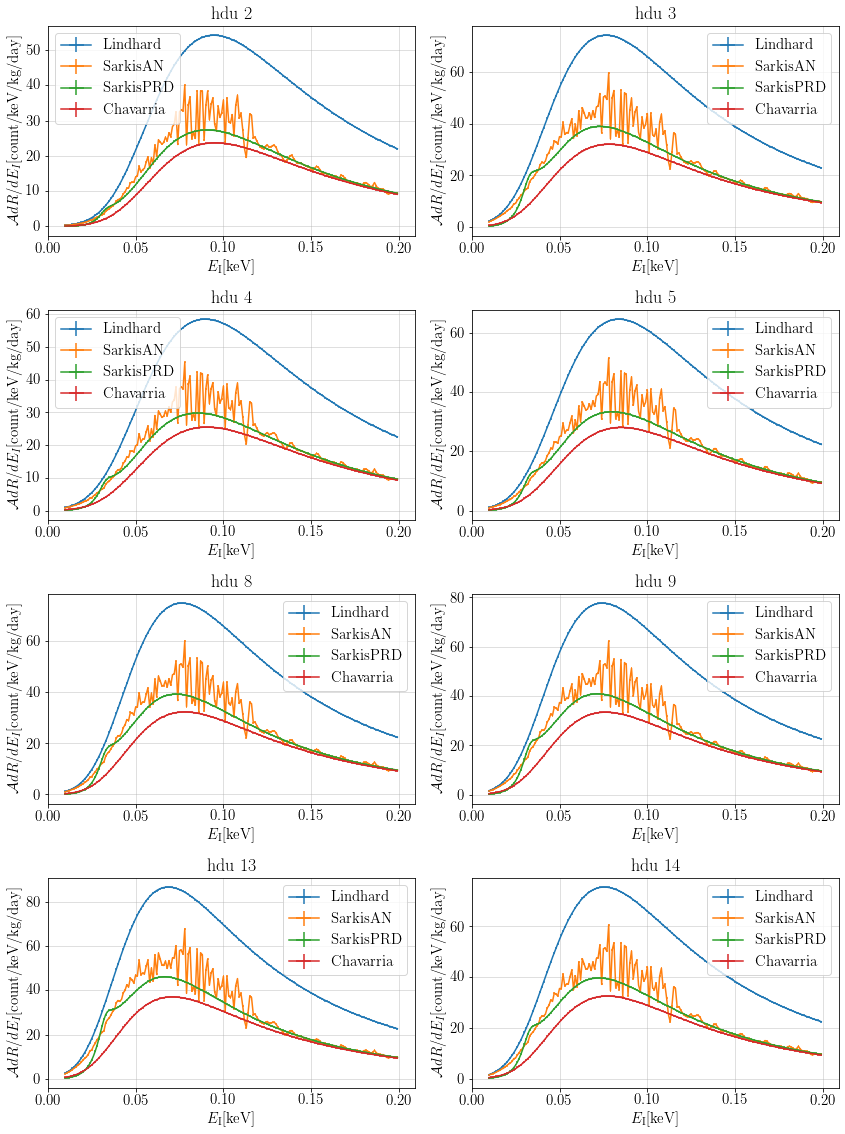

In [467]:
( AdR__dE_I( (.01, .2, .001), "on") ).xerrorbar(
    x = r"$E_{\rm I}$", 
    ylabel = r"$\mathcal{A}dR/dE_I$",
    y = ["Lindhard", "SarkisAN", "SarkisPRD", "Chavarria"],
    yunits = "count/keV/kg/day",
    z = "hdu", 
    fmt = "", 
    cols_wrap = 2,
);

### energy resolution rate

Multiple effects contribute for dispcrepancy between the measured energy and the ionization energy.
The main contribution comes from the reconstruction algorithm.
In order to account for it, the reconstructed energy is compared to the simulated energy in the matching catalogs.
Then the rate is corrected by convoluting the ionization energy with the dispersion kernel as
$$
\frac{d^3N_{\rm M} }{dEdMdt}(E_M) = 
\int_{E_{\rm min}}^{\infty} dE_I 
    \mathcal{A}(E_I) \frac{d^3N_{\rm I} }{dEdMdt}(E_I)
    G\left( E_M - E_I - \mu(E_I), \sigma(E_I) \right)
$$

call genfromroot({'E_I': ('oEnergy', 'eV'), 'E_M': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E_I': ('oEnergy', 'eV'), 'E_M': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'E_I': ('oEnergy', 'eV'), 'E_M': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E_I': ('oEnergy', 'eV'), 'E_M': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})


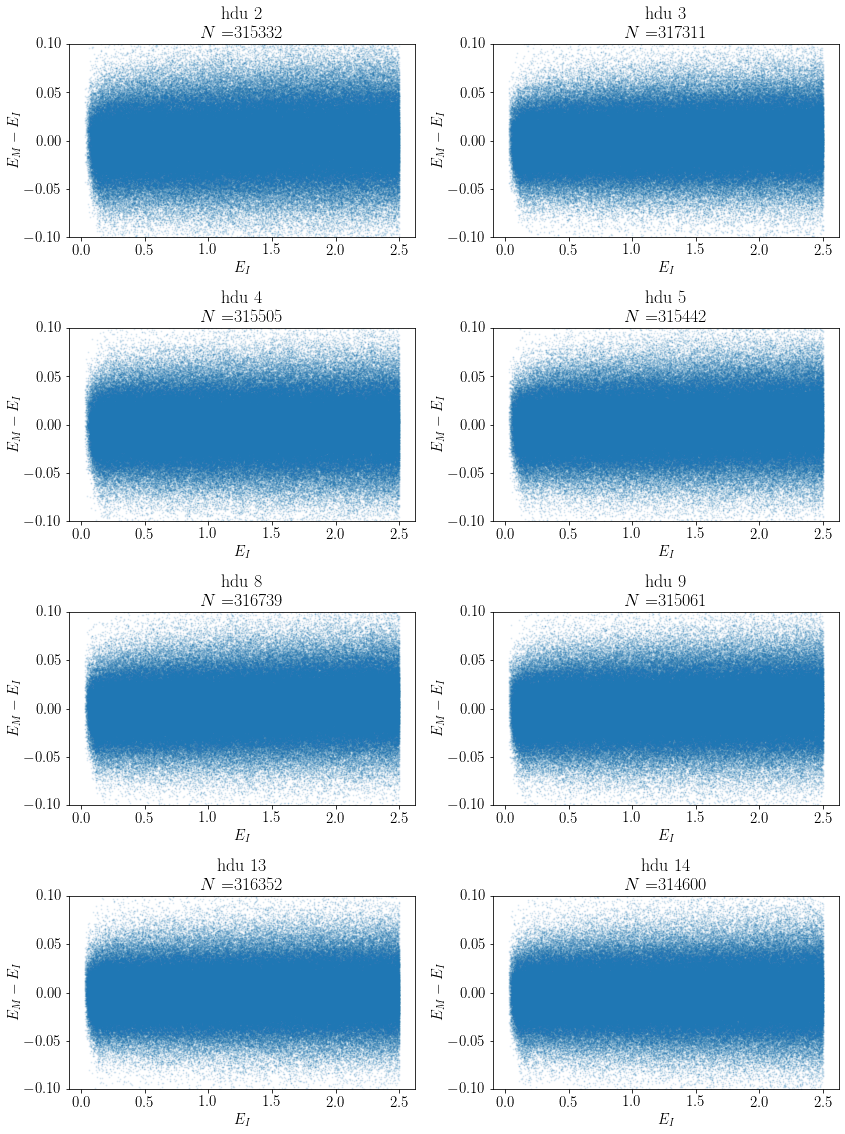

In [432]:
def events_dispersion( period, distSim=1.5):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {
            "E_I": ("oEnergy", "eV"),
            "E_M": ("E1/gain3Peaks", "keV"),
            "hdu": "ohdu"
        },
        cut = str(period*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )

ON_DISPERSION = events_dispersion( run2019.on_excl )
def dispersion_load( period, distSim=1.5 ):
    if period == "on":
        data = ON_DISPERSION
    else:
        data = events_dispersion( period )

    E_M = data["E_M"].pint.magnitude
    E_I = data["E_I"].pint.to('keV').pint.magnitude
    ohdu = data["hdu"]
    return dict(E_M=E_M, E_I=E_I, ohdu=ohdu)

def dispersion_per_ohdu( period, distSim=1.5 ):
    data = dispersion_load( period, distSim )
    return {
        ohdu: ia.np.vstack( (data["E_M"], data["E_I"]) )[:, data["ohdu"]==ohdu ] for ohdu in ia.np.unique(data["ohdu"])
    }, ["hdu", "kind", "E"]

def plot_dispersion( period, sel=slice(None, None), cols_wrap=2, distSim=1.5, func=lambda x, y: x ):
    data, dims = dispersion_per_ohdu( period, distSim )
#     print( data.keys() )
    size = len(data)
    nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
    width, height = plt.rcParams["figure.figsize"]
    fig = plt.figure( figsize = (width*ncols, height*nrows) )
    for i, (hdu, (e_M, e_I)) in enumerate( list(data.items())[sel] ):
        ax = fig.add_subplot(nrows, ncols, i+1 )
        ax.scatter( e_I, func(e_I, e_M), s=1, alpha=.1 )
        ax.set_xlabel( r"$E_I$" )
        ax.set_ylabel( r"$E_M - E_I$" )
        ax.set_title( f"hdu {hdu}\n$N=${e_M.size}" )
        ax.set_ylim((-.1, .1))
    plt.tight_layout()
    return

delta = lambda x, y: (y-x)
plot_dispersion( run2019.on_excl, distSim=1.5, func=delta )

mu 2 -4.14 3.05 3.83
sigma 2 33.35 3.31
mu 3 -2.87 2.64 3.07
sigma 3 28.82 2.32
mu 4 -3.71 0.88 3.73
sigma 4 30.93 2.80
mu 5 -3.10 2.78 3.37
sigma 5 30.57 2.74
mu 8 -2.83 3.96 3.44
sigma 8 29.43 2.51
mu 9 -3.54 2.88 3.79
sigma 9 29.76 2.47
mu 13 -2.60 1.39 2.94
sigma 13 28.02 2.31
mu 14 -3.07 0.91 2.95
sigma 14 29.34 2.74


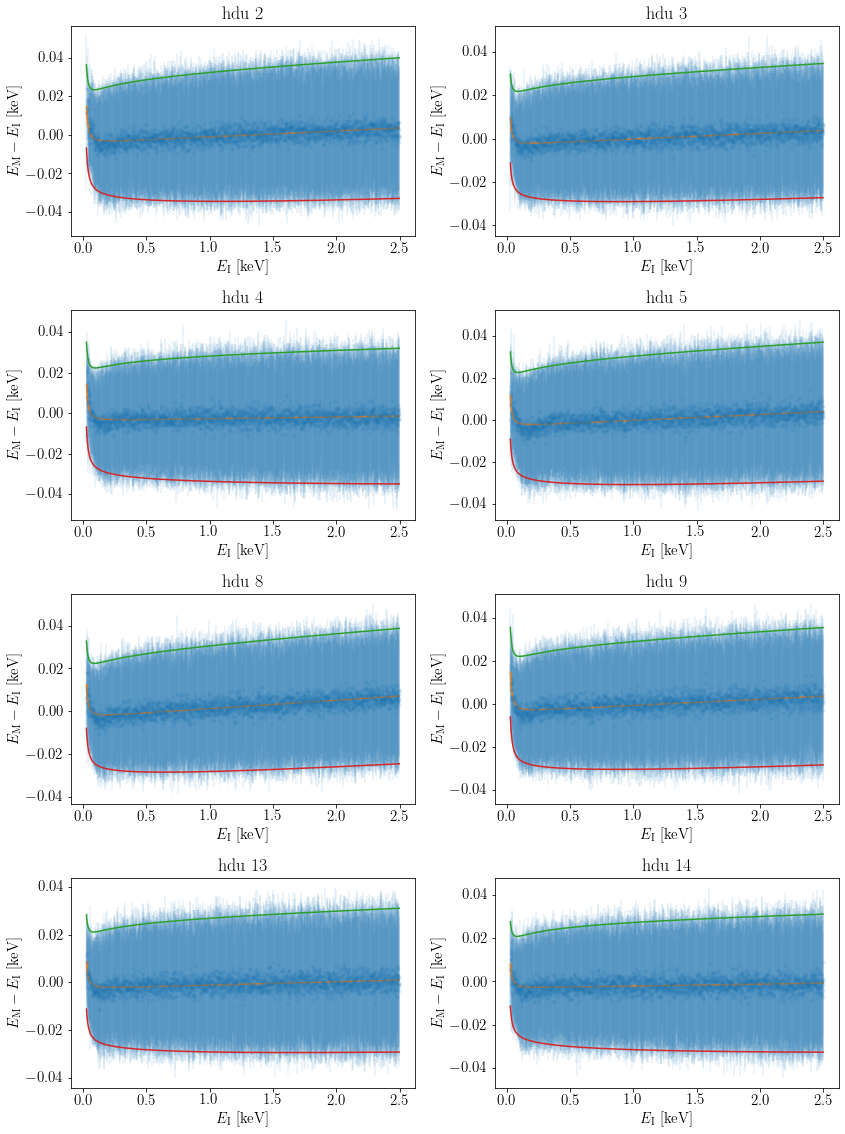

In [604]:
def dispersion_statistics( Erange, period, distSim=1.5 ):
    data, dims = dispersion_per_ohdu( period, distSim )
#     print( data.keys() )
    stats = lambda x: ( x.mean(), x.std() )
#     Ebins_keV = Erange[2] #((E_I[:-1] + E_I[1:])/2).pint.to("keV")
#     Ebins_mag = Ebins_keV.data.magnitude
    compute = lambda x, y, statistics: (
        ia.binned_statistic( y[abs(y - x)<.2], (x - y)[abs(y - x)<.2], statistic=statistics, bins=ia.np.arange(*Erange) )[0]
    )
    means = [ compute( e_M, e_I, statistics='mean' ) for i, (hdu, (e_M, e_I)) in enumerate( list(data.items()) ) ]
    stds = [ compute( e_M, e_I, statistics='std' ) for i, (hdu, (e_M, e_I)) in enumerate( list(data.items()) ) ]

    da = ia.xr.DataArray(
        ia.np.dstack((means, stds)) * ia.ureg.keV,
        dims = ["hdu", "Ei", "kind"],
        coords = {
            "kind": ["mean", "std"],
            "hdu": list(data.keys()),
            r"Ei": ia.np.arange(*Erange)[:-1]
        }
    )
    da[r"$E_{\rm I}$"] = da[r"Ei"] * ia.ureg.keV
    return da

# func = lambda x, a, b, c, d: a*( (x + d)**2 + c)/(x+b)
func = lambda x, a, b, c: c**2/x**2 + b*x + a
# func = lambda x, a, b, c, d: a*(-(x-b)**2 + d)*ia.np.exp(-x/c)
func2 = lambda x, a, b: b*ia.np.log(x) + a

def dispersion_statistics_fit( Erange, period, distSim=1.5 ):
    da = dispersion_statistics(Erange, period)
    hdus = da["hdu"].data
    for i, hdu_data in enumerate( da.sel(hdu=hdus)):
        means = hdu_data.sel(kind="mean")
        stds = hdu_data.sel(kind="std")        
        x = da[r"$E_{\rm I}$"].data.to("keV").magnitude #[1:-1]
        y = means.data.magnitude
        yerr = stds.data.magnitude
        try:
            popt, _ = ia.curve_fit( 
                func, 
                x[~ia.np.isnan(y)], 
                y[~ia.np.isnan(y)],
#                 p0=[0.007410823704375504, -0.007972469898196785, -0.21259707207992742, -0.5348607571376905],
                p0=[1, 1, 1],
            )
        except:
            popt = [0.007410823704375504, -0.007972469898196785, -0.21259707207992742, -0.5348607571376905]
        print( "mu", hdus[i], *[ f"{p*1e3:.2f}" for p in popt] )
        popt2, _ = ia.curve_fit( 
            func2, 
            x[~ia.np.isnan(y)], 
            yerr[~ia.np.isnan(y)],
            p0=[0.1, 1.],
        )
        print( "sigma", hdus[i], *[ f"{p*1e3:.2f}" for p in popt2] )
        da.attrs[f'fit_mu[{i}]'] = func(x[~ia.np.isnan(y)], *popt)
        da.attrs[f'fit_sigma[{i}]'] = func2(x[~ia.np.isnan(y)], *popt2)
    return da

def plot_dispersion_statistics( Erange, period, cols_wrap=2 ):
    dataarray = dispersion_statistics_fit(Erange, period )
    hdus = dataarray["hdu"].data
    size = len(hdus)
    nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
    width, height = plt.rcParams["figure.figsize"]
    fig = plt.figure( figsize = (width*ncols, height*nrows) )
    
    for i, hdu_data in enumerate( dataarray.sel(hdu=hdus)):
        ax = fig.add_subplot(nrows, ncols, i+1 )
        means = hdu_data.sel(kind="mean")
        stds = hdu_data.sel(kind="std")
        x = dataarray[r"$E_{\rm I}$"].data.to("keV").magnitude #[1:-1]
        y = means.data.magnitude
        yerr = stds.data.magnitude
#         popt, _ = ia.curve_fit( 
#             func, 
#             x[~ia.np.isnan(y)], 
#             y[~ia.np.isnan(y)],
#             p0=[0.007410823704375504, -0.007972469898196785, -0.21259707207992742, -0.5348607571376905],
# #             p0=[1, 1000, 0, 1] 
#         )
#         print( "mu", hdus[i], *popt )
#         popt2, _ = ia.curve_fit( 
#             func2, 
#             x[~ia.np.isnan(y)], 
#             yerr[~ia.np.isnan(y)],
#             p0=[0.1, 1.],
# #             bounds = [(0, ia.np.inf), ()]
#         )
#         print( "sigma", hdus[i], *popt2 )
        
        ax.errorbar( 
            x, 
            y, 
            yerr = yerr, 
            fmt = ".", 
            alpha = .1 
        )
#         ax.plot( x[~ia.np.isnan(y)], func(x[~ia.np.isnan(y)], *popt) )
#         ax.plot( x[~ia.np.isnan(y)], func(x[~ia.np.isnan(y)], *popt) + func2(x[~ia.np.isnan(y)], *popt2) )
#         ax.plot( x[~ia.np.isnan(y)], func(x[~ia.np.isnan(y)], *popt) - func2(x[~ia.np.isnan(y)], *popt2) )
        ax.plot( x[~ia.np.isnan(y)], dataarray.attrs[f"fit_mu[{i}]"] )
        ax.plot( x[~ia.np.isnan(y)], dataarray.attrs[f"fit_mu[{i}]"] + dataarray.attrs[f"fit_sigma[{i}]"] )
        ax.plot( x[~ia.np.isnan(y)], dataarray.attrs[f"fit_mu[{i}]"] - dataarray.attrs[f"fit_sigma[{i}]"] )
        
        ax.set_xlabel( E_I.name + f" [{E_I.pint.units}]" )
        ax.set_ylabel( r"$E_{\rm M} - E_{\rm I}$" + f" [{E_I.pint.units}]" )
        ax.set_title( f"hdu {hdus[i]}" )
    plt.tight_layout()
    return
        
# plot_dispersion_statistics( E_I, run2019.on_excl )
plot_dispersion_statistics( (0, 2.5, .001), "on" )

mu 2 5.598746832823689e-06 0.002865177928546605 -0.003793856832992192
sigma 2 0.002804927462725004 0.03364877723562119
mu 3 4.490846862891082e-06 0.0025170942097652595 -0.0026684729281522997
sigma 3 0.002174507563518558 0.02903854666272383
mu 4 7.688745356843264e-06 0.0007587364065395914 -0.003504033694102306
sigma 4 0.0027211682507213585 0.031137896327714236
mu 5 5.501219046465191e-06 0.0026472658289069806 -0.0028600564166110644
sigma 5 0.002774788902555306 0.03077390664359934
mu 8 5.414444306999175e-06 0.0038220810781434793 -0.002575716632752749
sigma 8 0.002405581040064233 0.029639038169177213
mu 9 8.813508032218504e-06 0.002782059060180648 -0.0033535513306765263
sigma 9 0.002392069988581663 0.02997495894727434
mu 13 4.7438842963738645e-06 0.0013277658506146712 -0.0024691306136365248
sigma 13 0.002322389750084906 0.028209981367941693
mu 14 4.2464692193262874e-06 0.0008074496641699037 -0.0029041875669251435
sigma 14 0.0026855912597409308 0.02955183932481984


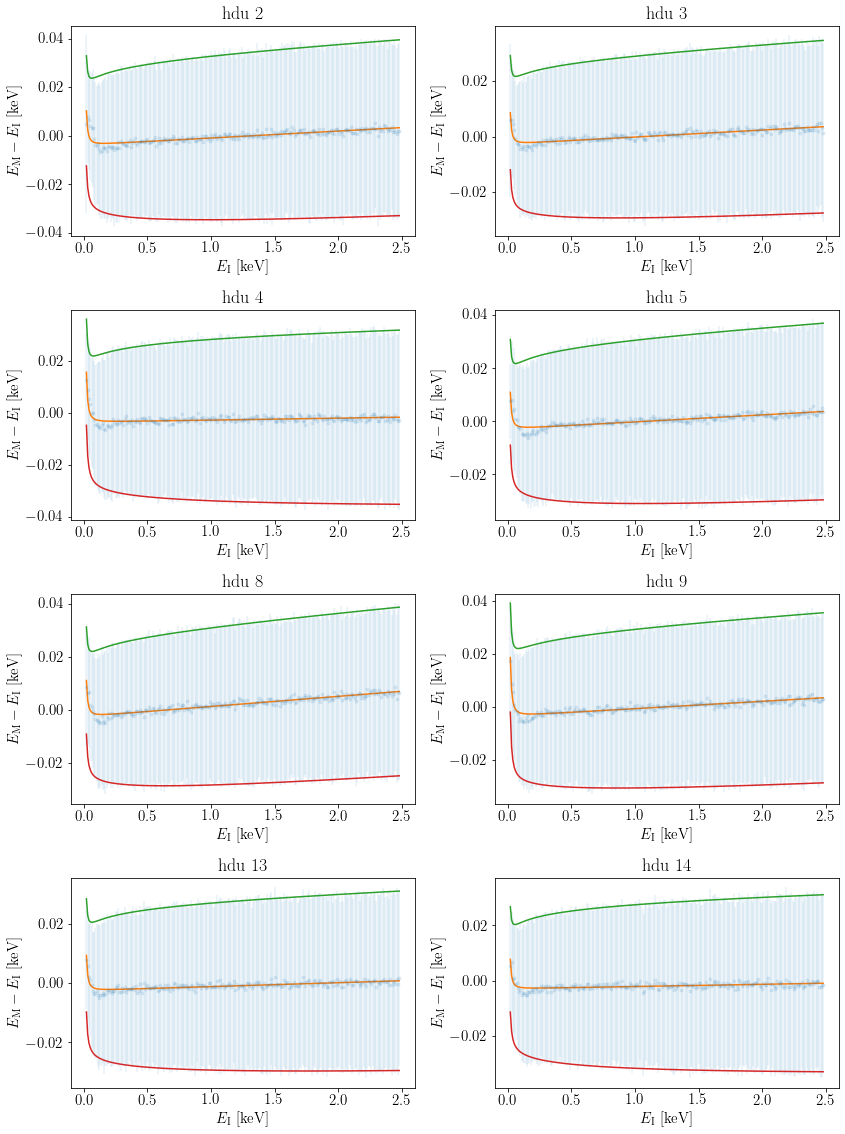

In [456]:
plot_dispersion_statistics( (0, 2.5, .01), "on" )

### measured energy rate

In [421]:
def E_M_range( min=-.01, max=1, binsize=.001 ):
    min -= binsize/2
    max -= binsize/2
    return ia.xr.DataArray( name=r"$E_{\rm M}$", data=ia.arange(min, max, binsize) * ia.ureg.keV, dims = "Em" )

print( E_M_range(*(.05, 2.5, .13)) )

<xarray.DataArray '$E_{\\rm M}$' (Em: 19)>
<Quantity([-0.015  0.115  0.245  0.375  0.505  0.635  0.765  0.895  1.025  1.155
  1.285  1.415  1.545  1.675  1.805  1.935  2.065  2.195  2.325], 'kiloelectron_volt')>
Dimensions without coordinates: Em


Q
<xarray.Dataset>
Dimensions:      (Ei: 198)
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.01 0.015 0.02 0.025 ... 0.985 0.99 0.995
  * Ei           (Ei) float64 0.01 0.015 0.02 0.025 ... 0.98 0.985 0.99 0.995
Data variables:
    Lindhard     (Ei) float64 655.0 510.4 421.5 ... 0.09929 0.09656 0.09391
    SarkisPRD    (Ei) float64 84.71 99.74 124.3 167.1 ... 0.02922 0.0284 0.02759
    SarkisAN     (Ei) float64 608.9 451.5 335.2 ... 0.02095 0.02342 0.02392
    Chavarria    (Ei) float64 165.1 149.4 135.5 ... 0.02689 0.02614 0.02541


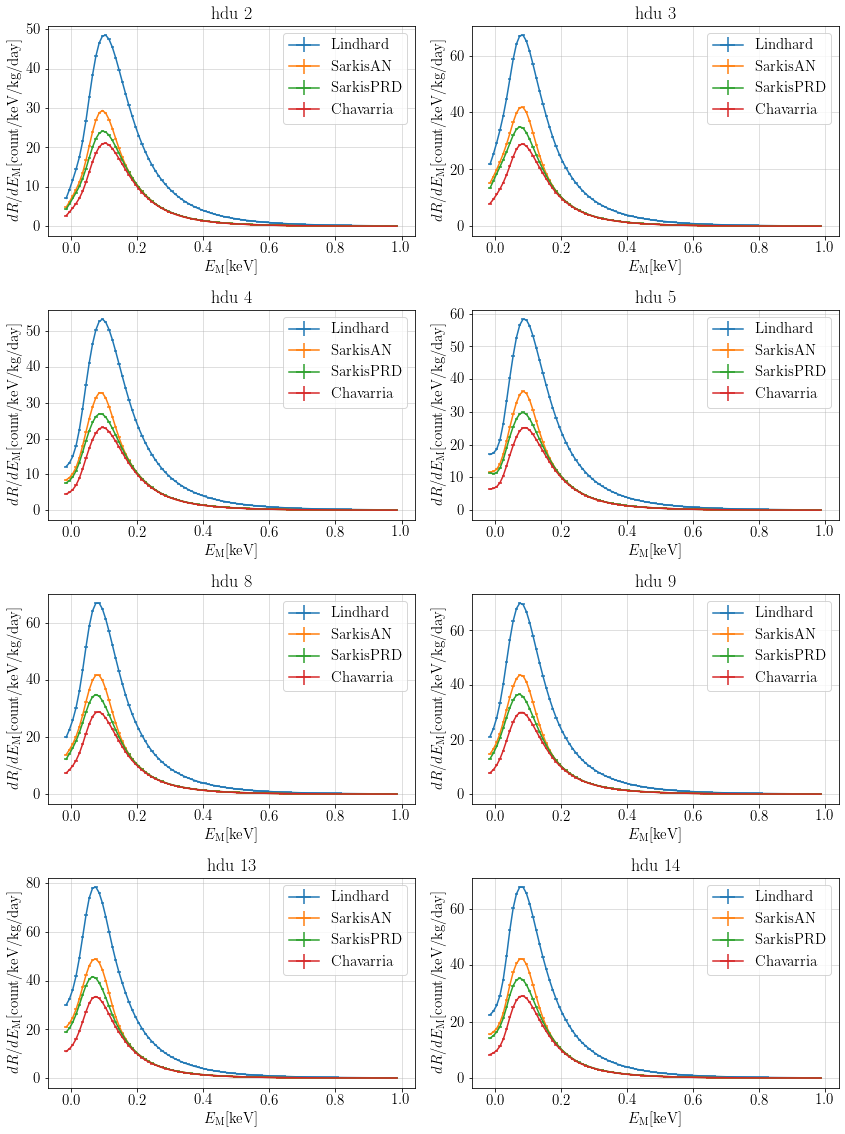

In [468]:
def dR__dE_M( ErangeM, Erange, period, func=tanhFit, p0=[10,10,10], v=False):
    import scipy

    a = AdR__dE_I(Erange, period, func=tanhFit, p0=[10,10,10])[ {"Ei":slice(None,-1)} ]
    if v:
        print("a")
        print(a)
    Ei = a[r"$E_{\rm I}$"]
    if v:
        print( "Ei")
        print(Ei)
    
    stats = dispersion_statistics(Erange, period)

    Em = E_M_range(*ErangeM)
    Em[r"$E_{\rm M}$"] = Em
    diffs = Em - Ei + stats.sel(kind="mean")
    
#     print( "#diffs")
#     print( diffs )
    sigma = stats.sel(kind="std")

#     print( "#sigma" )
#     print( sigma )
    sigma.data[ sigma.data == 0 ] = 100*ia.keV
    G = scipy.stats.norm.pdf( 
        diffs.data.magnitude,
        scale = sigma.data.magnitude.T[None,:,:]
    )
    G = ia.xr.DataArray(
        G,
        dims = ["Em", "Ei", "hdu"],
        coords = {
            "hdu": stats["hdu"],
            r"$E_{\rm M}$": Em,
            r"$E_{\rm I}$": Ei
        }
    )
    G.data[ia.np.isnan(G.data)] = 0
    numer = a*G/ia.ureg.keV
    numer = numer.integrate(r"$E_{\rm I}$")
    if v:
        print("#numer")
        print(numer)
    denom = G/ia.ureg.keV
    ret = numer/denom.integrate(r"$E_{\rm I}$")
    return ret

# E_M = ia.xr.DataArray( name=r"$E_{\rm M}$", data=ia.arange(-.01, 1, .001) * ia.ureg.keV, dims = "Em" )
dR__dE_M( (-.01, 1, .01), (.01, 1, .005), "on" ).xerrorbar(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    ylabel = r"$dR/dE_{\rm M}$",
    y = ["Lindhard", "SarkisAN", "SarkisPRD", "Chavarria"],    
    yunits = "count/keV/kg/day", 
    fmt = "", 
    cols_wrap = 2,
#     xlim = (-.1,1),
);

Q
<xarray.Dataset>
Dimensions:      (Ei: 990)
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.01 0.011 0.012 0.013 ... 0.997 0.998 0.999
  * Ei           (Ei) float64 0.01 0.011 0.012 0.013 ... 0.996 0.997 0.998 0.999
Data variables:
    Lindhard     (Ei) float64 655.0 619.7 586.8 ... 0.09287 0.09236 0.09185
    SarkisPRD    (Ei) float64 84.71 87.19 89.9 92.88 ... 0.02728 0.02713 0.02697
    SarkisAN     (Ei) float64 608.9 556.6 541.1 491.2 ... 0.0254 0.02647 0.02719
    Chavarria    (Ei) float64 165.1 161.8 158.6 ... 0.02513 0.02499 0.02485


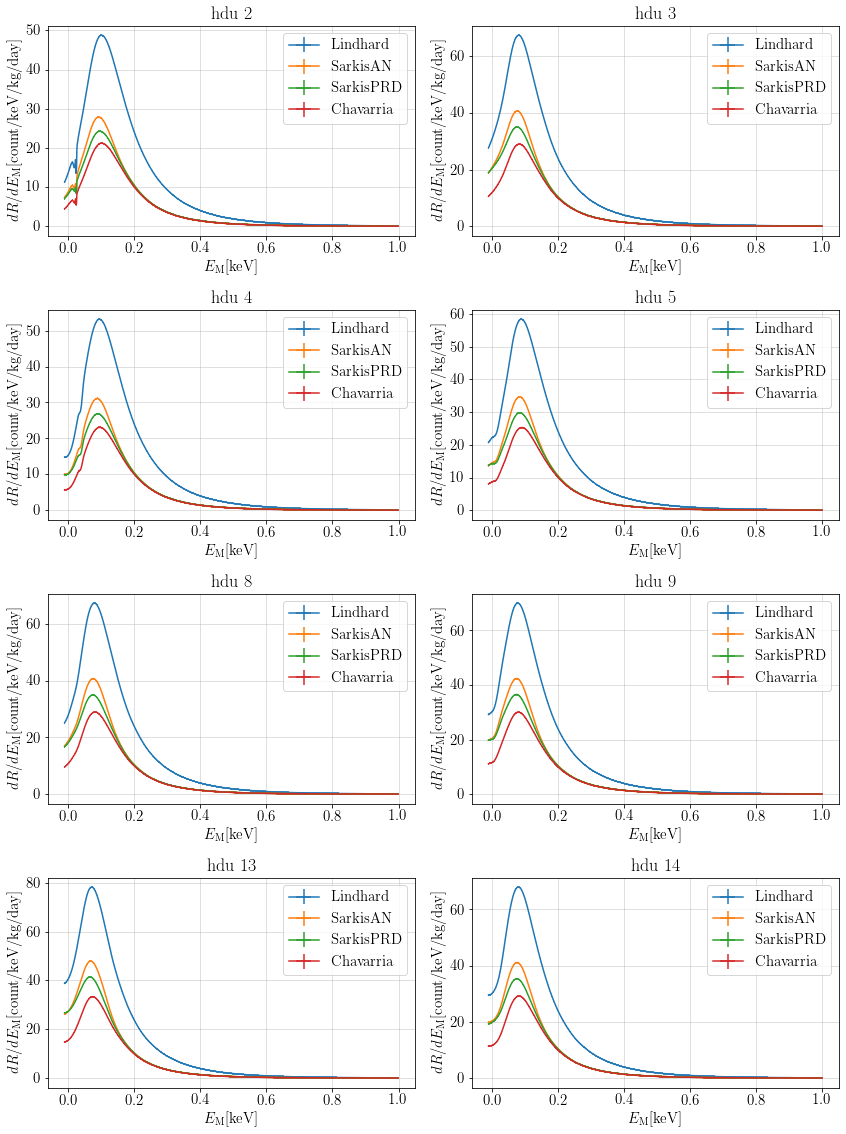

In [469]:
dR__dE_M( (-.01, 1, .001), (.01, 1, .001), "on" ).xerrorbar(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    ylabel = r"$dR/dE_{\rm M}$",
    y = ["Lindhard", "SarkisAN", "SarkisPRD", "Chavarria"],    
    yunits = "count/keV/kg/day", 
    fmt = "", 
    cols_wrap = 2,
);

### selection efficiency rate

In [ ]:
def get_events_data0(period):
    return ia.genfromroot( 
        run2019.data_files, 
        treename = "hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(period*run2019.excluded_ohdu),
    )

def dNdata__dE_M( Erange, period ):
    data = get_events_data0( period )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)

def dNsel__dE_M( Erange, period ):
    data = ia.genfromroot( 
        run2019.data_files, 
        treename = "hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"}, #, "runid": "runID"},
        cut = str(
            period*run2019.excluded_ohdu*'(sizell<.95) & (sizell>0) & (E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50) & (xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
        ),
    )
#     print( ia.unique( data["runid"] ).size )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)

def get_events_data( period ):
    print(f"call get_events_data({period})")
    return ia.genfromroot( 
        run2019.data_files, 
        treename = "hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"}, #, "runid": "runID"},
        cut = str(
            period*run2019.excluded_ohdu
        ),
    )

ON_DATA_EFF = get_events_data( run2019.on_eff )
OFF_DATA_EFF = get_events_data( run2019.off_eff )

def dN__dE_M( Erange, period, tabs=0 ):
    print( "  "*tabs + f"call dN__dE_M({Erange}, {period}" )
    if period == "on":
        data = ON_DATA_EFF
    elif period == "off":
        data = OFF_DATA_EFF
    else:
        data = get_events_data( period )
    ret = data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)
    print( "  "*tabs + f"return dN__dE_M({Erange}, {period}" )
    return ret


In [ ]:
ia.iprint( dNdata__dE_M( (.05,2.5,.13), run2019.on_excl ) ).xerrorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
<xarray.Dataset>
Dimensions:          (Em: 17, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$      (Em) float64 [keV] 0.115 0.245 0.375 ... 1.935 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $dN/dE_{\rm M}$  (hdu, Em) object [count/keV] (1.15+/-0.09)e+03 ... (7.9+...


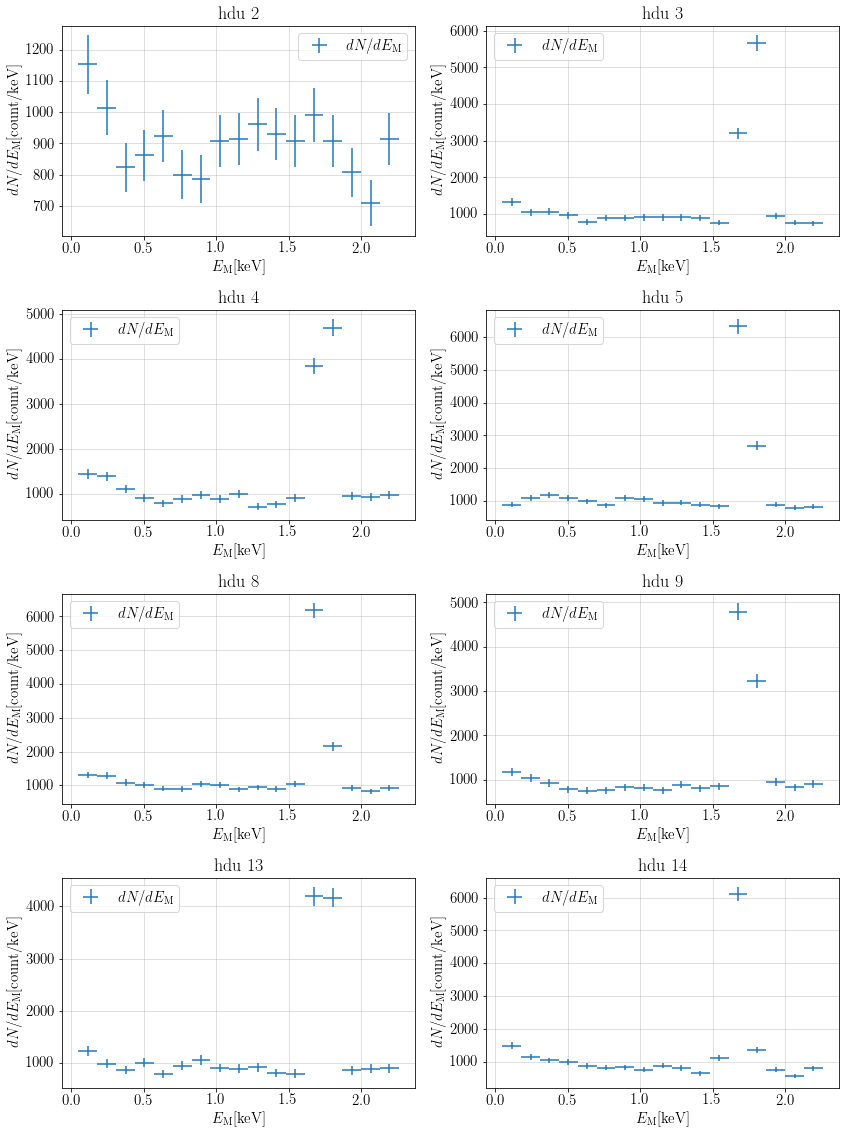

In [231]:
ia.iprint( dNsel__dE_M( (.05,2.5,.13), run2019.on_excl ) ).xerrorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

In [660]:
def get_events_match( cut, distSim=1.5 ):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"Em": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(cut*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )
ON_MATCH_EFF = get_events_match( run2019.on_excl )
OFF_MATCH_EFF = get_events_match( run2019.off_excl )
def dNmatch__dE_M( Erange, cut, distSim=1.5 ):
    if cut == "on":
        data = ON_MATCH_EFF
    elif cut == "off":
        data = OFF_MATCH_EFF
    else:
        data = get_events_match( cut, distSim )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)

def get_events_match_selection( period, distSim=1.5 ):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"Em": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(sizell<.95) & (sizell>0) & (E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50) & (xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'*f'distSim<={distSim}'
        ),
    )
ON_MATCH_SEL_EFF = get_events_match_selection( run2019.on_excl )
OFF_MATCH_SEL_EFF = get_events_match_selection( run2019.off_excl )
def dNmatchsel__dE_M( Erange, period, distSim=1.5 ):
    if period == "on":
        data = ON_MATCH_SEL_EFF
    elif period == "off":
        data = OFF_MATCH_SEL_EFF
    else:
        data = get_events_match_selection( period, distSim )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)

def get_events_match_XY(period, distSim=1.5):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"Em": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898)'*f'distSim<={distSim}'
        ),
    )
ON_MATCH_XY = get_events_match_XY( run2019.on_excl )
OFF_MATCH_XY = get_events_match_XY( run2019.off_excl )
def dNmatchXY__dE_M( Erange, period, distSim=1.5 ):
    if period == "on":
        data = ON_MATCH_XY
    elif period == "off":
        data = OFF_MATCH_XY
    else:
        data = get_events_match_XY( period, distSim )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)

def get_events_match_sigma(period, distSim=1.5):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(sizell<.95) & (sizell>0)'*f'distSim<={distSim}'
        ),
    )
ON_MATCH_SIGMA = get_events_match_sigma( run2019.on_excl )
OFF_MATCH_SIGMA = get_events_match_sigma( run2019.off_excl )
def dNmatchsigma__dE_M( Erange, period, distSim=1.5 ):
    if period == "on":
        data = ON_MATCH_SIGMA
    elif period == "off":
        data = OFF_MATCH_SIGMA
    else:
        data = get_events_match_sigma( period, distSim )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)

def get_events_match_hpix( period, distSim=1.5 ):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"Em": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(hPixFlag==0)'*f'distSim<={distSim}'
        ),
    )

def dNmatchhpix__dE_M( Erange, period, distSim=1.5 ):
    if period == "on":
        data = get_events_match_sigma( run2019.on_excl, distSim )
    elif period == "off":
        data = get_events_match_sigma( run2019.off_excl, distSim )
    else:
        data = get_events_match_hpix( period, distSim )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)

def get_events_match_flag( period, distSim=1.5 ):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"Em": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(flag==0)'*f'distSim<={distSim}'
        ),
    )

def dNmatchflag__dE_M( Erange, period, distSim=1.5 ):
    if period == "on":
        data = get_events_match_flag( run2019.on_excl, distSim )
    elif period == "off":
        data = get_events_match_flag( run2019.off_excl, distSim )
    else:
        data = get_events_match_flag( period, distSim )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)


call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})

In [661]:
def get_events_match_XYactive(period, distSim=1.5):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"Em": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(xMax<4220) & (yMax<900)'*f'distSim<={distSim}'
        ),
    )
ON_MATCH_XYactive = get_events_match_XYactive( run2019.on_excl )
OFF_MATCH_XYactive = get_events_match_XYactive( run2019.off_excl )
def dNmatchXYactive__dE_M( Erange, period, distSim=1.5 ):
    if period == "on":
        data = ON_MATCH_XYactive
    elif period == "off":
        data = OFF_MATCH_XYactive
    else:
        data = get_events_match_XYactive( period, distSim )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)


call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})


In [649]:
def get_events_match_XYsigma(period, distSim=1.5):
    return ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("E1/gain3Peaks", "keV"), "hdu": "ohdu"},
        cut = str(
            period*run2019.excluded_ohdu*'(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (sizell<.95) & (sizell>0)'*f'distSim<={distSim}'
        ),
    )
ON_MATCH_XYSIGMA = get_events_match_XYsigma( run2019.on_excl )
OFF_MATCH_XYSIGMA = get_events_match_XYsigma( run2019.off_excl )
def dNmatchXYsigma__dE_M( Erange, period, distSim=1.5 ):
    if period == "on":
        data = ON_MATCH_XYSIGMA
    elif period == "off":
        data = OFF_MATCH_XYSIGMA
    else:
        data = get_events_match_XYsigma( period, distSim )
    return data.xhistogram("hdu", centers=E_M_range(*Erange), per_bin=True)


call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})


<xarray.Dataset>
Dimensions:          (Em: 17, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$      (Em) float64 [keV] 0.115 0.245 0.375 ... 1.935 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $dN/dE_{\rm M}$  (hdu, Em) object [count/keV] (9.90+/-0.09)e+04 ... (1.28...


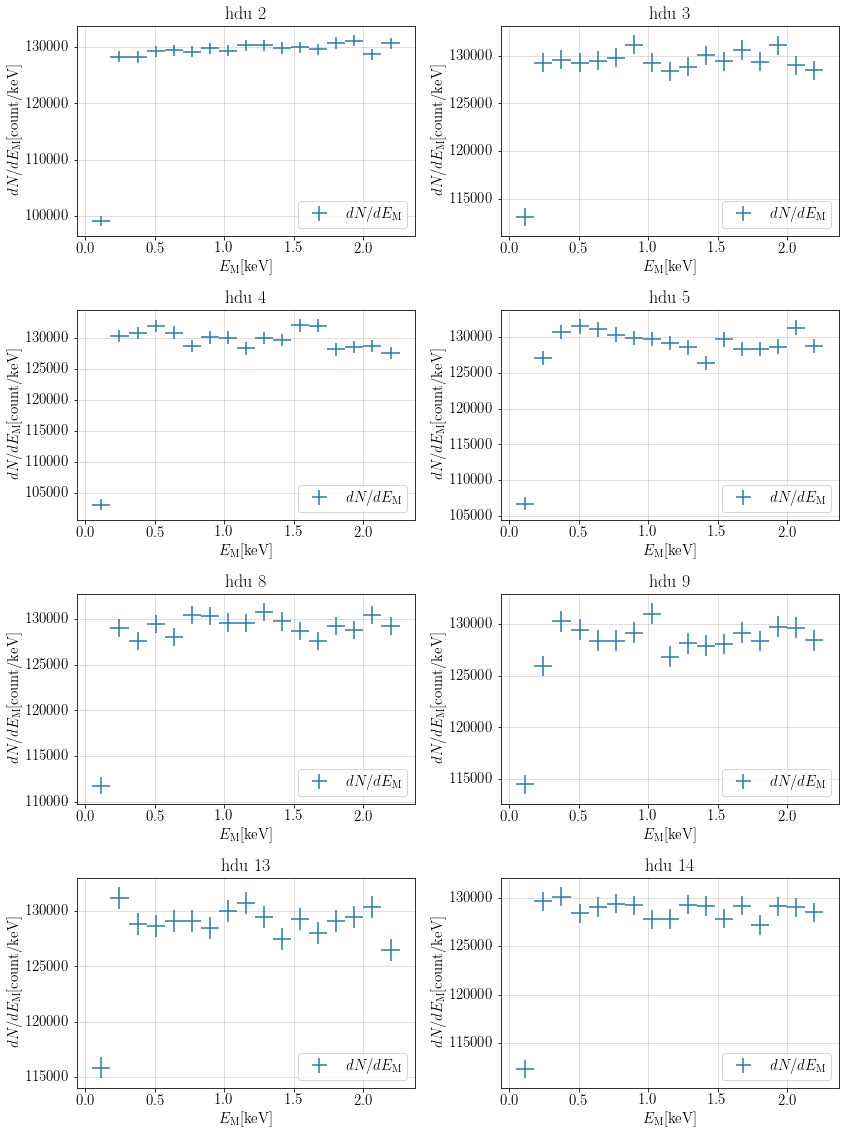

In [484]:
ia.iprint( 
    dNmatch__dE_M( (.05, 2.5, .13), "on" )
).xerrorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

<xarray.Dataset>
Dimensions:          (Em: 17, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$      (Em) float64 [keV] 0.115 0.245 0.375 ... 1.935 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $dN/dE_{\rm M}$  (hdu, Em) object [count/keV] (6.69+/-0.07)e+04 ... (7.63...


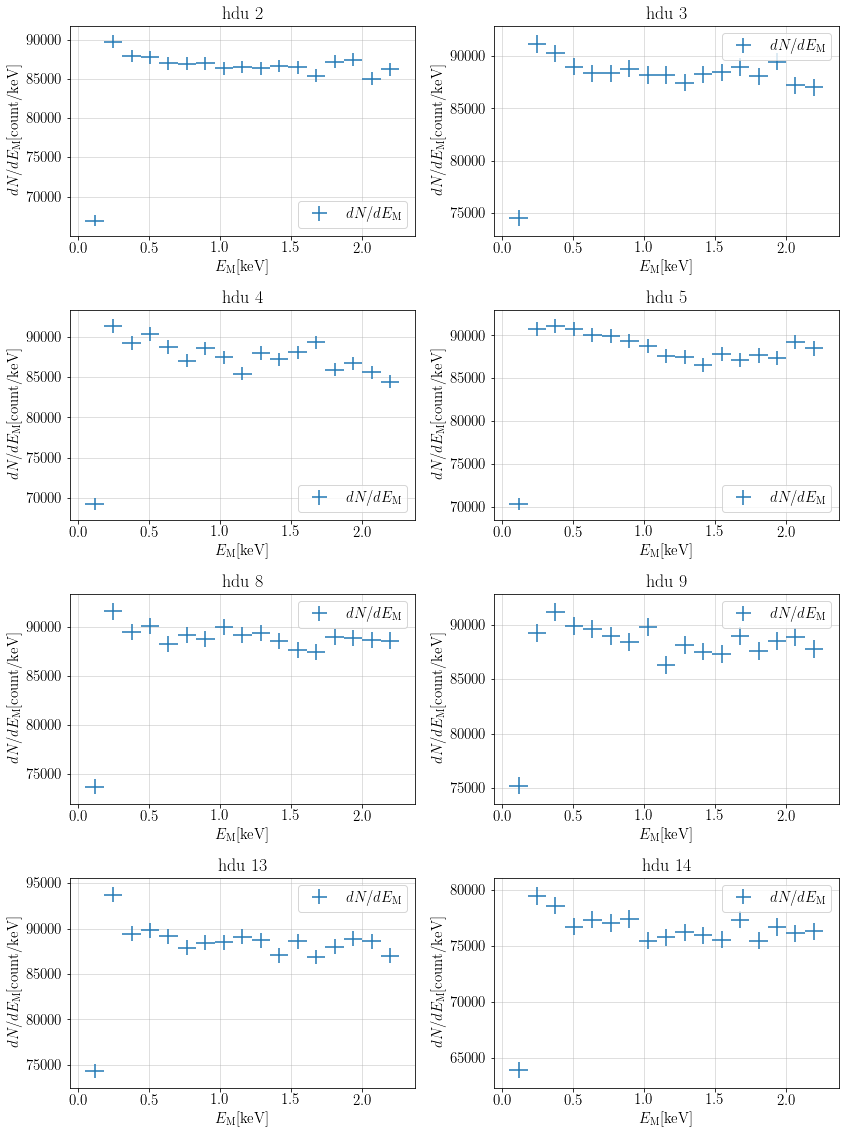

In [486]:
ia.iprint(
    dNmatchsel__dE_M( (.05, 2.5, .13), "on" )
).xerrorbar(x=r"$E_{\rm M}$", y=r"$dN/dE_{\rm M}$", z="hdu", fmt=" ")

### flag Efficiency

call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
<xarray.Dataset>
Dimensions:             (Em: 17, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.115 0.245 0.375 ... 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 1.000+/-0.012 ... 1.000+/-0.011
da_errorbar


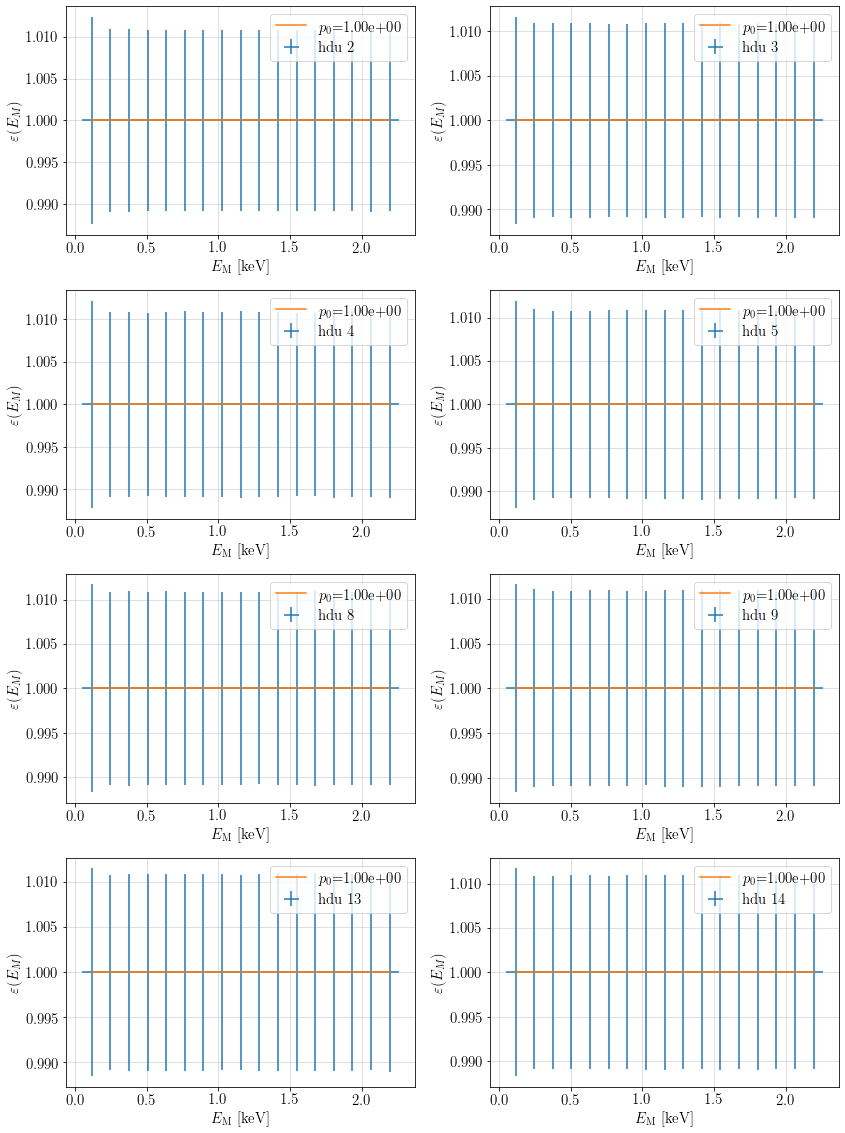

In [503]:
def EfficiencyFlag(Erange, cut, label="M" ):
    match = dNmatch__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    matchSel = dNmatchflag__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {fr"$\varepsilon(E_{label})$": matchSel_where/match_where }
    )

ia.iprint( EfficiencyFlag( (.05, 2.5, .13), "on" ) )[r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a: a*ia.np.ones_like(x),
    p0 = [ 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
    z="hdu", 
    cols_wrap=2
);

### hPix Efficiency

call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
<xarray.Dataset>
Dimensions:             (Em: 17, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.115 0.245 0.375 ... 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 1.000+/-0.012 ... 1.000+/-0.011
da_errorbar


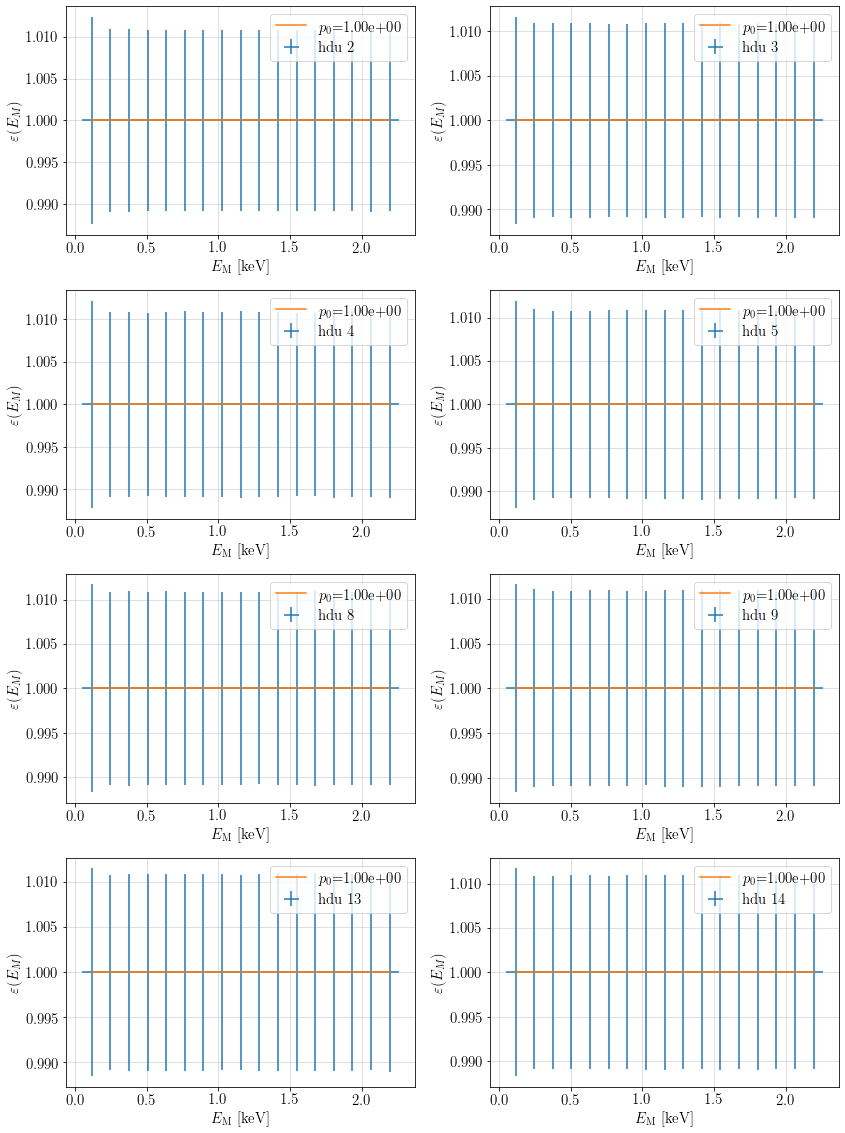

In [502]:
def EfficiencyhPix(Erange, cut, label="M" ):
    match = dNmatch__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    matchSel = dNmatchhpix__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {fr"$\varepsilon(E_{label})$": matchSel_where/match_where }
    )

ia.iprint( EfficiencyFlag( (.05, 2.5, .13), "on" ) )[r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a: a*ia.np.ones_like(x),
    p0 = [ 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
    z="hdu", 
    cols_wrap=2
);

### XY efficiency

<xarray.Dataset>
Dimensions:             (Em: 17, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.115 0.245 0.375 ... 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.847+/-0.011 ... 0.849+/-0.010
da_errorbar


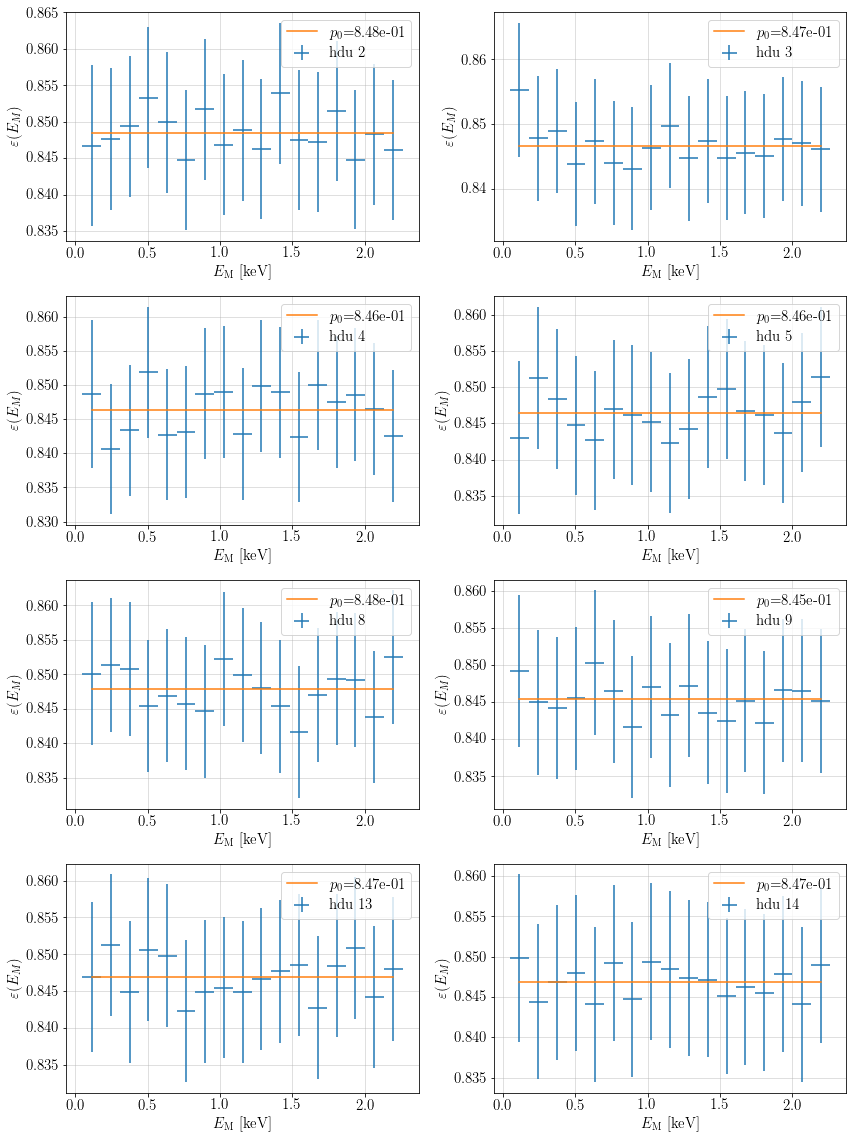

In [240]:
def EfficiencyXY(Erange, cut, label="M" ):
    match = dNmatch__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    matchSel = dNmatchXY__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {fr"$\varepsilon(E_{label})$": matchSel_where/match_where }
    )

ia.iprint( EfficiencyXY( (.05, 2.5, .13), "on" ) )[r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a: a*ia.np.ones_like(x),
    p0 = [ 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
#     y=r"$\varepsilon(E_M)$", 
    z="hdu", 
    cols_wrap=2
);

<xarray.Dataset>
Dimensions:             (Em: 17, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.115 0.245 0.375 ... 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.847+/-0.011 ... 0.849+/-0.010
da_errorbar


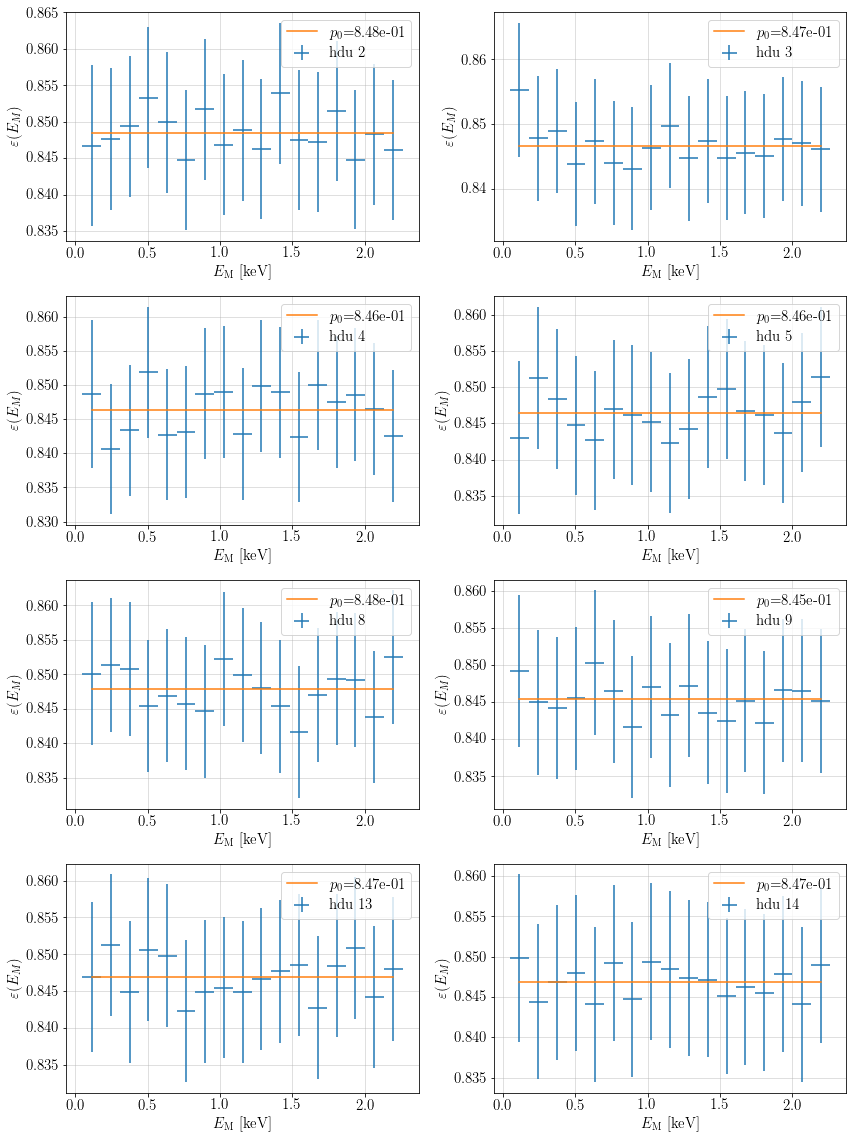

In [241]:
ia.iprint( EfficiencyXY( (0.05,2.5,.13), "on" ) )[r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a: a*ia.np.ones_like(x),
    p0 = [ 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
#     y=r"$\varepsilon(E_M)$", 
    z="hdu", 
    cols_wrap=2
);

In [116]:
def printEffXY( Erange=(.05, 2.5, .13), period=run2019.on_excl ):
    eff = EfficiencyXY( Erange, period )
    means, stds = [], []
    for i, hdu in enumerate(eff.hdu.values):
        means += [ia.np.mean(ia.un.nominal_values(eff[r"$\varepsilon(E_M)$"][i,:].pint.magnitude) )]
        stds += [ia.np.mean(ia.un.std_devs(eff[r"$\varepsilon(E_M)$"][i,:].pint.magnitude) )]
    return means, stds
printEffXY()

([0.8484869717177368,
  0.8467316544133897,
  0.8463260402897711,
  0.846413260175938,
  0.8478702697316938,
  0.8453700184707372,
  0.8469514993125328,
  0.8468993386504323],
 [0.009726199136184317,
  0.009675250123030017,
  0.009692246688822726,
  0.009699638442894887,
  0.00969882291342913,
  0.009691878686578028,
  0.009686011118141973,
  0.009705704779626073])

### XY active efficiency

<xarray.Dataset>
Dimensions:             (Em: 17, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.115 0.245 0.375 ... 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.847+/-0.011 ... 0.849+/-0.010
da_errorbar


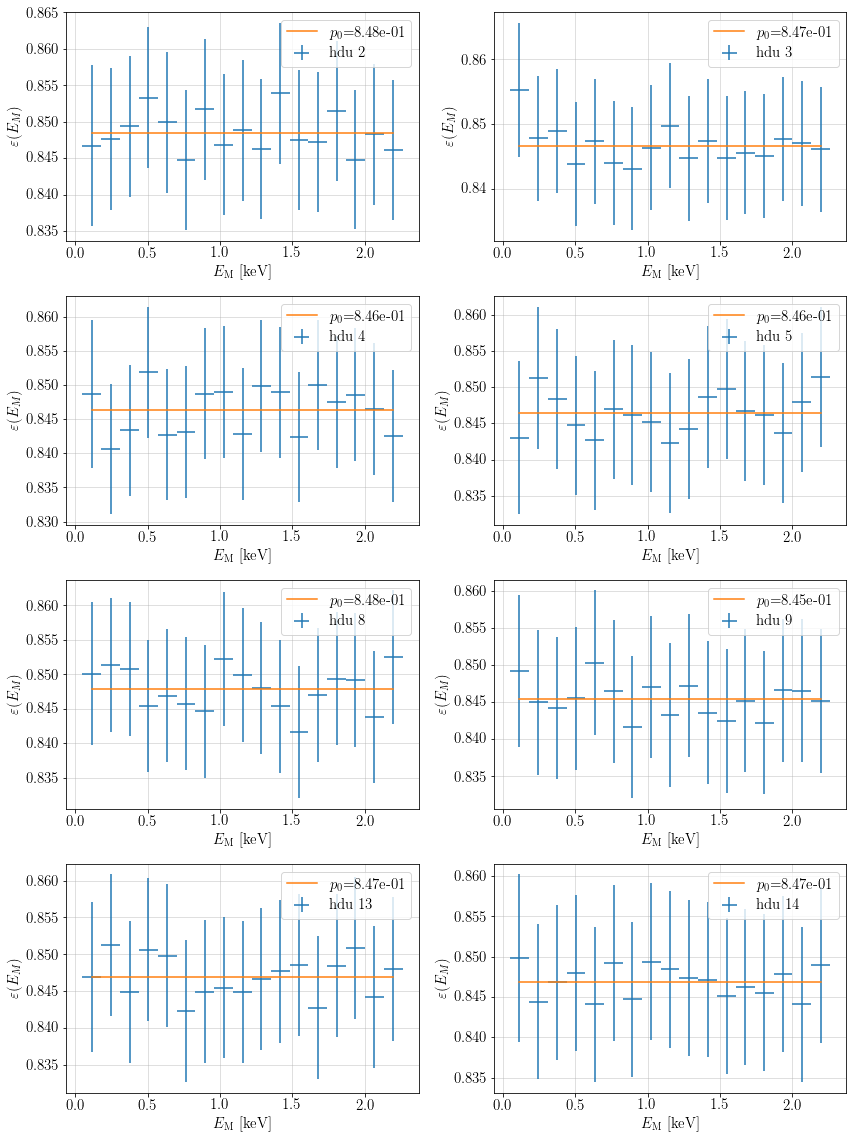

In [662]:
def EfficiencyXYactive(Erange, cut, label="M" ):
    match = dNmatchXYactive__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    matchSel = dNmatchXY__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {fr"$\varepsilon(E_{label})$": matchSel_where/match_where }
    )

ia.iprint( EfficiencyXYactive( (.05, 2.5, .13), "on" ) )[r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a: a*ia.np.ones_like(x),
    p0 = [ 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
#     y=r"$\varepsilon(E_M)$", 
    z="hdu", 
    cols_wrap=2
);

### Sigma Efficiency

<xarray.Dataset>
Dimensions:             (Em: 17, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.115 0.245 0.375 ... 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.863+/-0.011 ... 0.798+/-0.009
da_errorbar


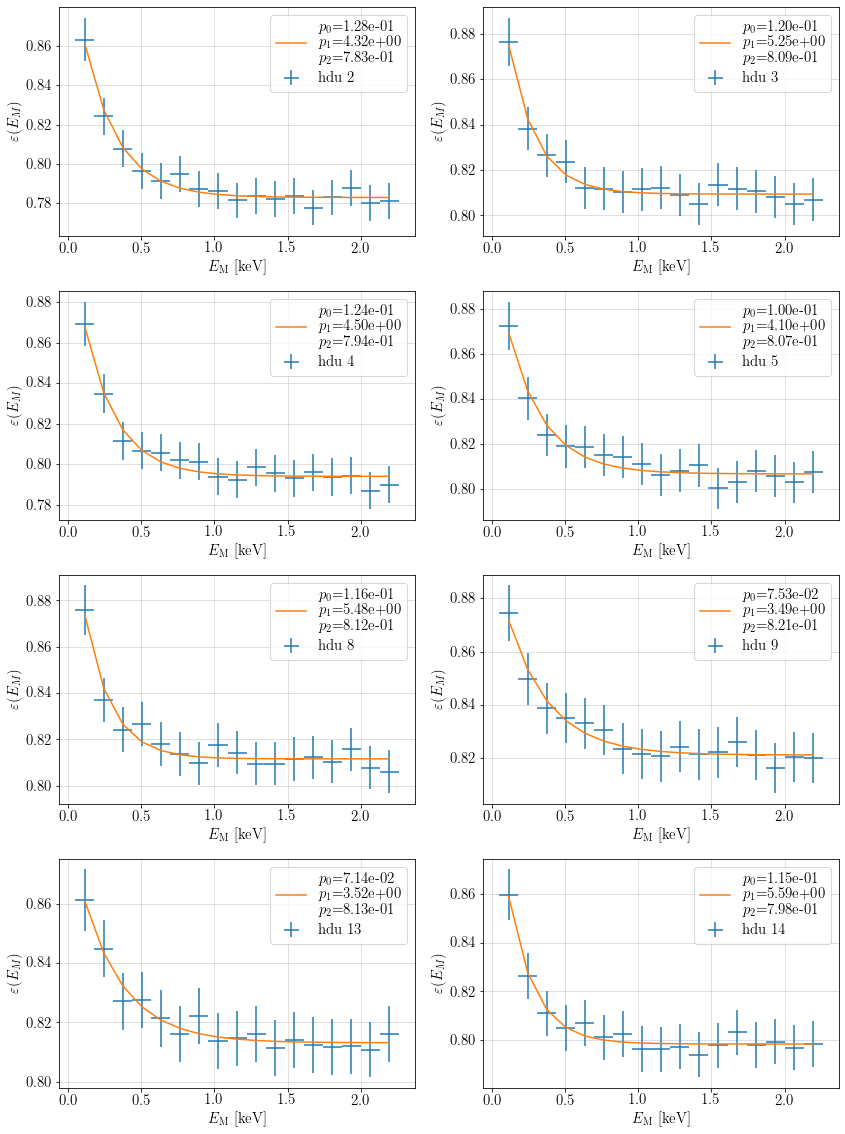

In [646]:
def EfficiencySigma(Erange, cut, label="M"):
    match = dNmatch__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    matchSel = dNmatchsigma__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {fr"$\varepsilon(E_{label})$": matchSel_where/match_where }
    )

ia.iprint( EfficiencySigma( (.05, 2.5, .13), "on") )[r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a, b, c: a*ia.np.exp(-b*x) + c,
    p0 = [ 1., 1., 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
#     y=r"$\varepsilon(E_M)$", 
    z="hdu", 
    cols_wrap=2
);

<xarray.Dataset>
Dimensions:             (Em: 17, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.115 0.245 0.375 ... 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.863+/-0.011 ... 0.798+/-0.009
da_errorbar


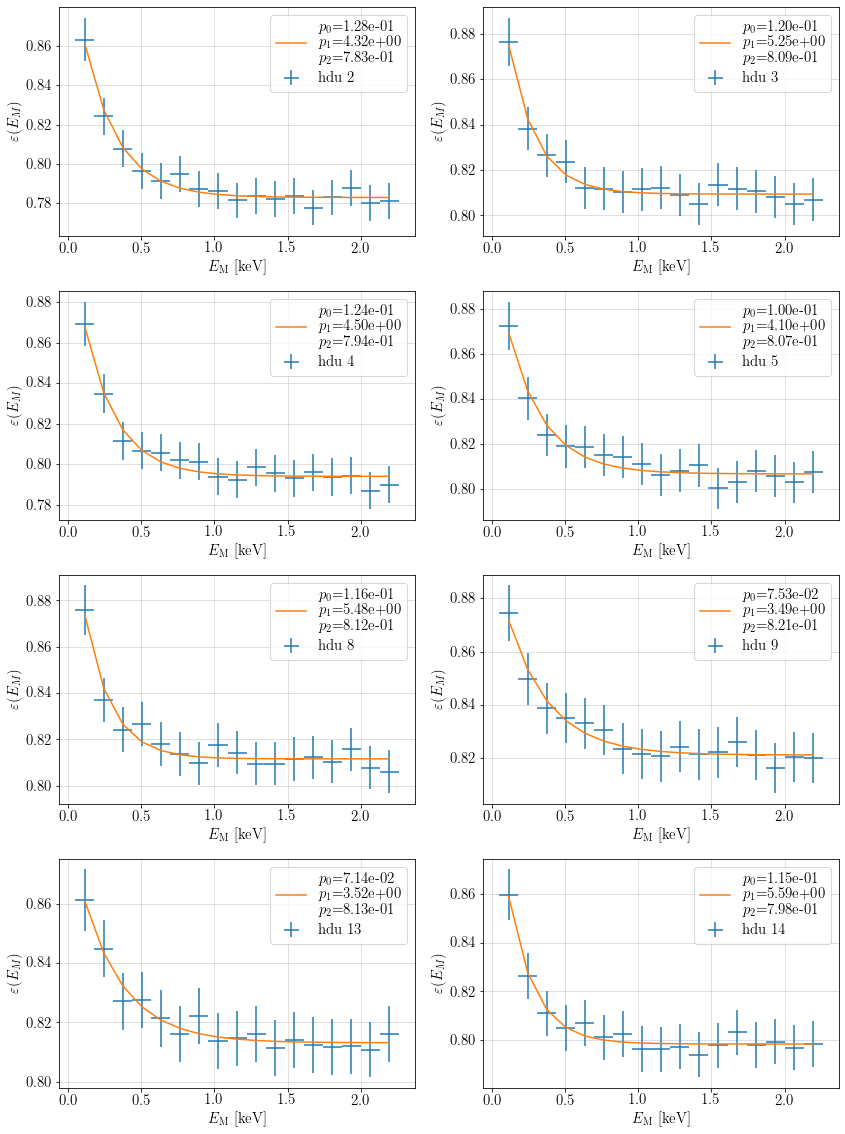

In [490]:
def EfficiencySigma(Erange, cut, label="M"):
    match = dNmatch__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    matchSel = dNmatchsigma__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {fr"$\varepsilon(E_{label})$": matchSel_where/match_where }
    )

ia.iprint( EfficiencySigma( (.05, 2.5, .13), "on") )[r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a, b, c: a*ia.np.exp(-b*x) + c,
    p0 = [ 1., 1., 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
#     y=r"$\varepsilon(E_M)$", 
    z="hdu", 
    cols_wrap=2
);

In [117]:
def printEffSigma( Erange=(0.05, 2.5, .13), period=run2019.on_excl ):
    eff = EfficiencySigma( Erange, period )
    means, stds = [], []
    for i, hdu in enumerate(eff.hdu.values):
        means += [ia.np.mean(ia.un.nominal_values(eff[r"$\varepsilon(E_M)$"][i,-10:].pint.magnitude) )]
        stds += [ia.np.mean(ia.un.std_devs(eff[r"$\varepsilon(E_M)$"][i,-10:].pint.magnitude) )]
    return means, stds
printEffSigma()

([0.7827350424160017,
  0.8093847281954011,
  0.7934386487270447,
  0.8063826650162055,
  0.8114717292243194,
  0.8214245213421666,
  0.8133150985547133,
  0.7977871566484604],
 [0.009083294824575263,
  0.009328216959407797,
  0.009195446238458672,
  0.00932555369346579,
  0.009349734308891213,
  0.009456113216596767,
  0.00937669035324521,
  0.0092663426442608])

### XY Sigma Efficiency

<xarray.Dataset>
Dimensions:             (Em: 17, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.115 0.245 0.375 ... 2.065 2.195
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.862+/-0.012 ... 0.800+/-0.010
da_errorbar


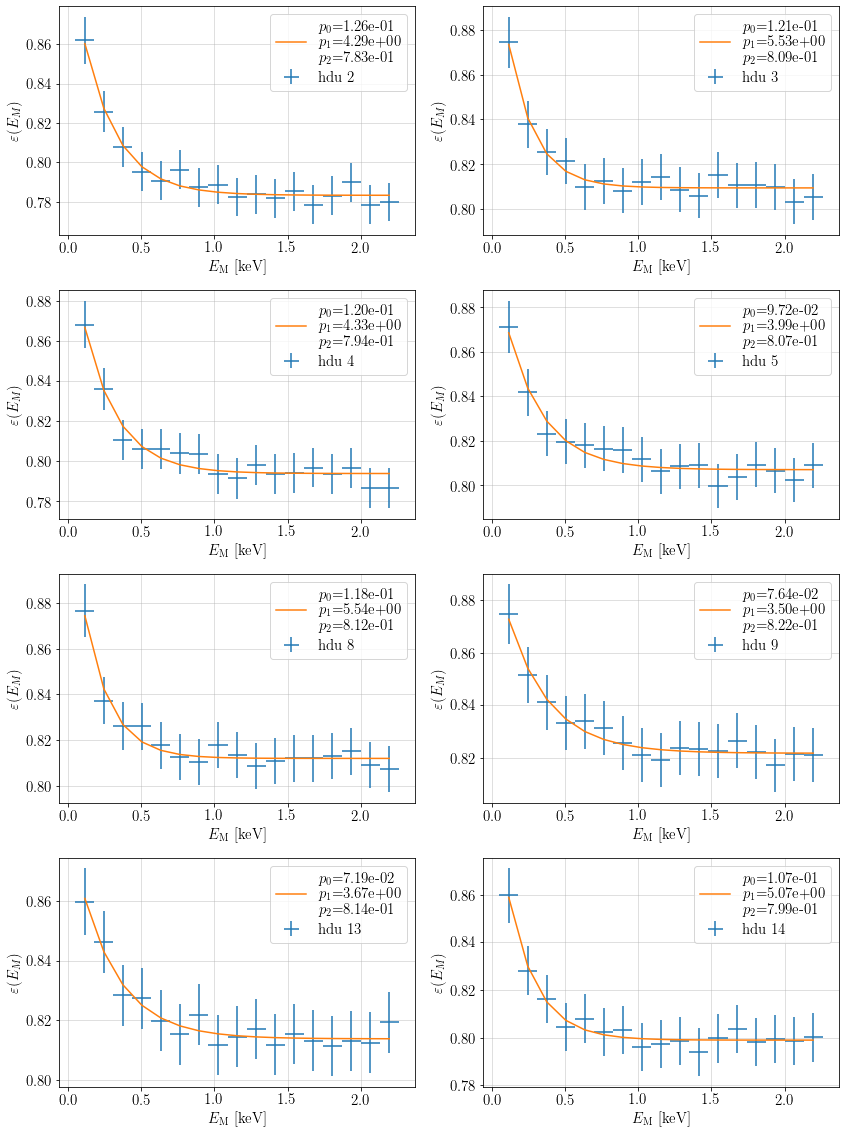

In [650]:
def EfficiencyXYSigma(Erange, cut, label="M"):
    match = dNmatchXY__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    matchSel = dNmatchXYsigma__dE_M(Erange, cut)[fr"$dN/dE_{{\rm {label}}}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {fr"$\varepsilon(E_{label})$": matchSel_where/match_where }
    )

ia.iprint( EfficiencyXYSigma( (.05, 2.5, .13), "on") )[r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a, b, c: a*ia.np.exp(-b*x) + c,
    p0 = [ 1., 1., 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
#     y=r"$\varepsilon(E_M)$", 
    z="hdu", 
    cols_wrap=2
);

In [654]:
def printEffXYSigma( Erange=(0.05, 2.5, .13), period=run2019.on_excl ):
    eff = EfficiencyXYSigma( Erange, period )
    means, stds = [], []
    for i, hdu in enumerate(eff.hdu.values):
        means += [ia.np.mean(ia.un.nominal_values(eff[r"$\varepsilon(E_M)$"][i,-10:].pint.magnitude) )]
        stds += [ia.np.mean(ia.un.std_devs(eff[r"$\varepsilon(E_M)$"][i,-10:].pint.magnitude) )]
    return means, stds
printEffXYSigma()

call genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'Em': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})


([0.7831040986224342,
  0.8096778930817754,
  0.7931279732210793,
  0.8067089745612085,
  0.8118501755286734,
  0.8217281497084624,
  0.8139435624815825,
  0.7984734715710715],
 [0.009866584705380732,
  0.010141880748179555,
  0.009989671670087635,
  0.010138359818280629,
  0.010157305741345104,
  0.0102902186168116,
  0.010195704347956542,
  0.010074670112494804])

### Corrected Mass

In [44]:
Non = 735
Noff = 652
Ton = Non * (ia.ureg("hour") + 4*ia.ureg("minutes")).to("day")
Toff = Noff * (ia.ureg("hour") + 4*ia.ureg("minutes")).to("day")
print( Ton, Toff )

32.666666666666664 d 28.977777777777774 d


In [45]:
rho = 2.329 * ia.ureg('g/cm^3')
dM = rho * (15*ia.ureg('micrometer'))**2 * 675*ia.ureg("micrometer") * 4120**2
dM = dM.to('kg')
print(dM)

0.0060041317229999995 kg


In [653]:
rho = 2.329 * ia.ureg('g/cm^3')
# '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898)
dMxy = rho * (15*ia.ureg('micrometer'))**2 * 675*ia.ureg("micrometer") * (3960-140) * (898-75)*5
dMxy = dMxy.to('kg')
print(dMxy)

0.0055601816731875 kg


call correctedMass((0.05, 10, 0.13))
return correctedMass((0.05, 10, 0.13))
<xarray.DataArray 'mass' (Em: 75, hdu: 8)>
<Quantity([[0.004792257160188767+/-6.747422711410373e-05
  0.0048621176521603795+/-6.349567429720899e-05
  0.004826675548081643+/-6.63793765843591e-05
  0.004844425317958816+/-6.563864426360595e-05
  0.004874161848872591+/-6.41673193798606e-05
  0.004863014680702555+/-6.332315344037902e-05
  0.004780317697230429+/-6.225280217755641e-05
  0.004779632356184307+/-6.310811638315696e-05]
 [0.004591484250947946+/-5.740826707894502e-05
  0.004658593882575179+/-5.7806993983274536e-05
  0.004648721313185642+/-5.7746188815568214e-05
  0.004681071868102449+/-5.839243058166436e-05
  0.004655425296974656+/-5.7717631265247516e-05
  0.004733592120036849+/-5.935695816418933e-05
  0.004705181639115539+/-5.7685523601680474e-05
  0.004604116424484681+/-5.734481235806201e-05]
 [0.004490704559943413+/-5.6454312848934826e-05
  0.004588831661324966+/-5.707029816669848e-05
  0.004506955325409

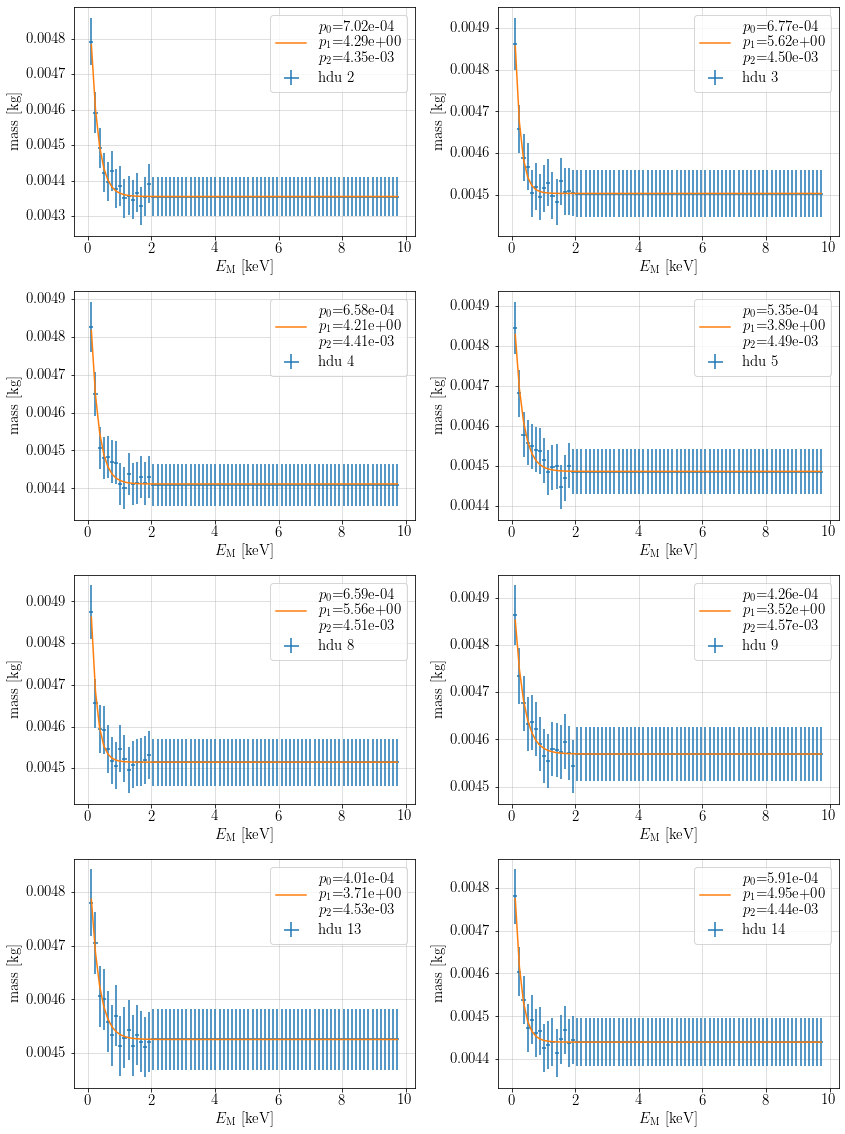

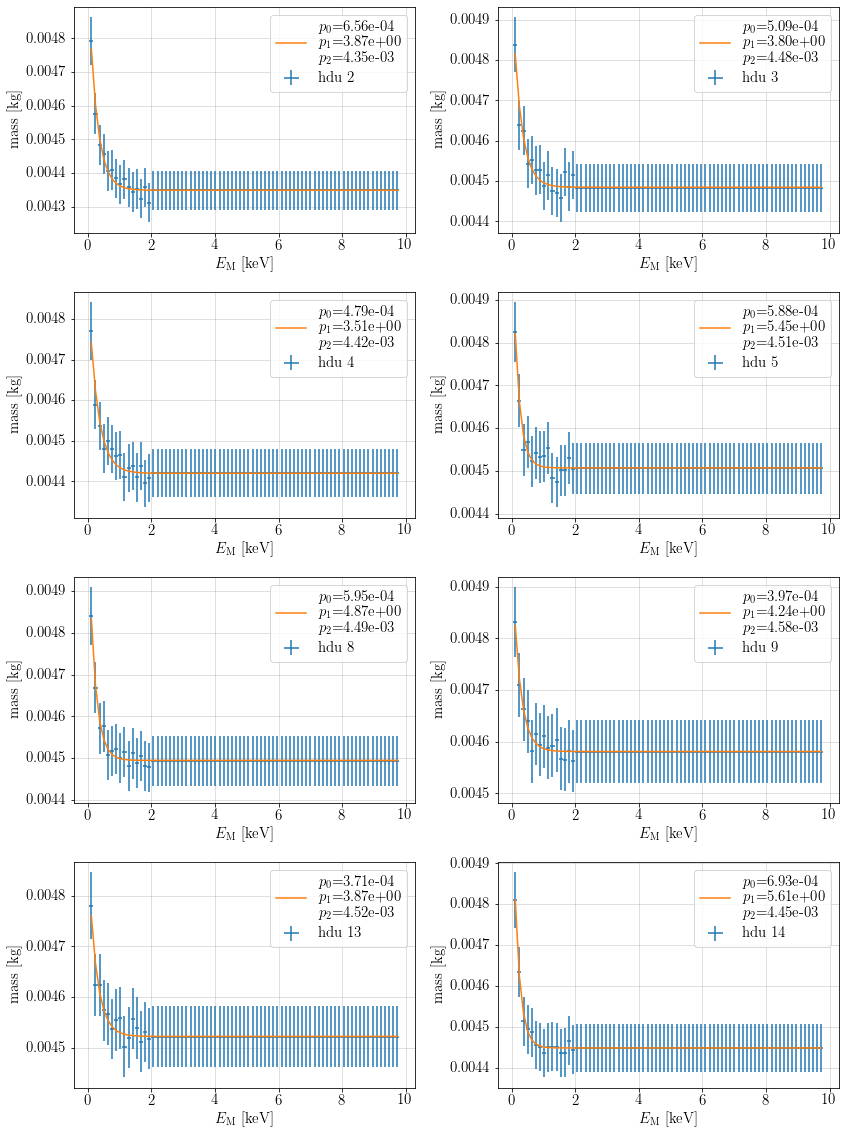

In [664]:
def correctedMass( M, Erange=(.05, 2.5, .13), period= run2019.on_excl, verbose=True, tabs=0 ):
    if verbose: print( "  "*tabs + f"call correctedMass({Erange})")
    Erange2 = (Erange[0], 2.5, Erange[2])
#     effXY = EfficiencyXY(Erange2,period )
#     effSigma = EfficiencySigma(Erange2, period )
#     ret = effXY * effSigma * M
#     XYSat = printEffXY( Erange2, period )
#     sigmaSat = printEffSigma( Erange2, period )
    effXYSigma = EfficiencyXYSigma( Erange2,period )
    ret = effXYSigma * M
    XYSigmaSat = printEffXYSigma( Erange2, period )

    E = E_M_range(*Erange)[1:]
    ret = ia.xr.DataArray(
        name = r"mass",
        data = ia.np.array([
            [
#                 M.magnitude * effXY[r"$\varepsilon(E_M)$"].pint.magnitude[i,j] * effSigma[r"$\varepsilon(E_M)$"].pint.magnitude[i,j]
                M.magnitude * effXYSigma[r"$\varepsilon(E_M)$"].pint.magnitude[i,j]
                if e < 2 else 
#                 M.magnitude * ia.un.uarray( XYSat[0][i], XYSat[1][i] ) * ia.un.uarray( sigmaSat[0][i], sigmaSat[1][i] )
                M.magnitude * ia.un.uarray( XYSigmaSat[0][i], XYSigmaSat[1][i] )
                for i, hdu in enumerate( effXYSigma["hdu"].values )
            ]
            for j, e in enumerate(E.pint.magnitude[:-1])
        ]) * ia.ureg("kg"),
#         dims = effXY.dims,
        dims = effXYSigma.dims,
        coords = {
#             "hdu": effXY["hdu"].values,
            "hdu": effXYSigma["hdu"].values,
            r"$E_{\rm M}$": E[:-1]
        }
    )
    if verbose: print( "  "*tabs + f"return correctedMass({Erange})")
    return ret

ia.iprint( 
    correctedMass(dMxy, (.05, 10, .13), "on" ) 
).curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a, b, c: a*ia.np.exp(-b*x) + c,
    p0 = [ 1., 1., 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
    z="hdu", 
    cols_wrap=2
);

ia.iprint( 
    correctedMass(dMxy, (.05, 10, .13), "off" ) 
).curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = lambda x, a, b, c: a*ia.np.exp(-b*x) + c,
    p0 = [ 1., 1., 1. ]
).errorbar(
    x=r"$E_{\rm M}$", 
    z="hdu", 
    cols_wrap=2
);

<xarray.Dataset>
Dimensions:             (Em: 98, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$         (Em) float64 [keV] 0.005 0.015 0.025 ... 0.965 0.975
Dimensions without coordinates: Em
Data variables:
    $\varepsilon(E_M)$  (hdu, Em) object [] 0.0+/-0 0.0+/-0 ... 0.581+/-0.027


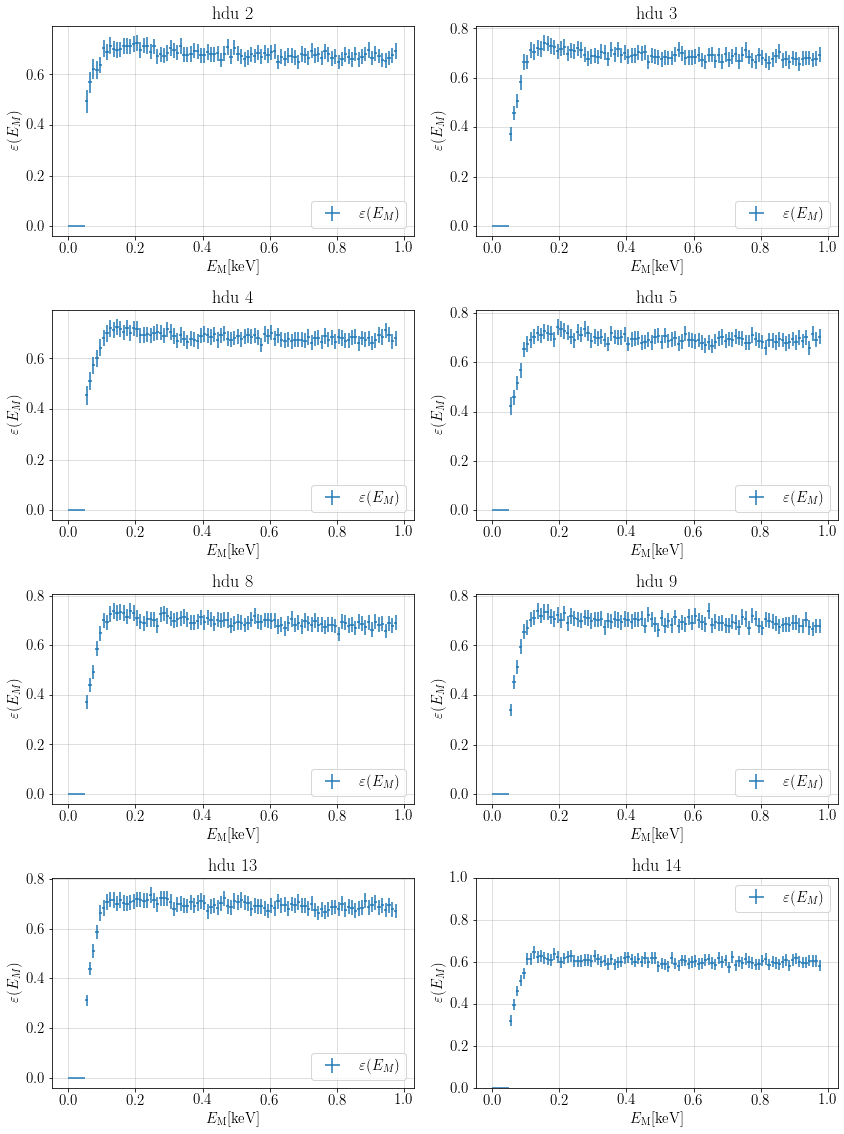

In [504]:
def Efficiency(Erange, period):
    match = dNmatch__dE_M(Erange, period)[fr"$dN/dE_{{\rm M}}$"]
    matchSel = dNmatchsel__dE_M(Erange, period)[fr"$dN/dE_{{\rm M}}$"]
    match_where = match.where( match.pint.magnitude>0, 1*match.pint.units )
    matchSel_where = matchSel.where( match.pint.magnitude>0, 0*match.pint.units )
    return ia.xr.Dataset(
        data_vars = {fr"$\varepsilon(E_M)$": matchSel_where/match_where }
    )

ia.iprint( 
    Efficiency( (0, 1, .01), "on" ) 
).xerrorbar(
    x=r"$E_{\rm M}$", 
    y=r"$\varepsilon(E_M)$", 
    z="hdu", 
    cols_wrap=2, 
    fmt=" "
)
plt.ylim((0,1));

In [605]:
def printEfficiency(Erange, period):
    tanhFit2 = lambda E, a, b, c: tanhFit(E, a, b, c) * (E > .05)
    eff = Efficiency(Erange, period)
    eff_fit = eff[r"$\varepsilon(E_M)$"].curve_fit(
        x = r"$E_{\rm M}$", 
        z = "hdu", 
        func = tanhFit2,
        p0 = [ .03, .01, .7 ]
    )
    print( eff_fit.attrs["fit"] )
    E = eff[r"$E_{\rm M}$"]
    print("#E", end=", ")
    for hdu in eff["hdu"].pint.magnitude:
        print(f"eff{hdu}", end=", ")
        print(f"err{hdu}", end=", ")
    print()
    for i, e in enumerate(E.pint.magnitude):
        print( f"{e:.2f}", end=", " )
        for j, hdu in enumerate(eff["hdu"].pint.magnitude):
            value = eff[r"$\varepsilon(E_M)$"].pint.magnitude[j,i]
            print( f"{ia.un.nominal_values(value):.3f}", end=", " )
            print( f"{ia.un.std_devs(value):.3f}", end=", " )
        print()
printEfficiency((0, 2.5, .01), "on")

<xarray.DataArray (hdu: 8, params: 3)>
array([[ 0.0287853 ,  0.00548405,  0.6691513 ],
       [ 0.03622075,  0.00641573,  0.68388355],
       [ 0.0343081 ,  0.00198891,  0.67620263],
       [ 0.04029237, -0.00122174,  0.68631846],
       [ 0.03667856,  0.00706972,  0.68846182],
       [ 0.03402917,  0.01141916,  0.68938153],
       [ 0.03238024,  0.01509747,  0.68711834],
       [ 0.03502016,  0.0084034 ,  0.59573506]])
Coordinates:
  * hdu      (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: params
Attributes:
    func:     <function printEfficiency.<locals>.<lambda> at 0x7f46a5e1f488>
    fit:      [0.03502016 0.0084034  0.59573506]
#E, eff2, err2, eff3, err3, eff4, err4, eff5, err5, eff8, err8, eff9, err9, eff13, err13, eff14, err14, 
0.01, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 
0.01, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 


<xarray.DataArray '$\\varepsilon(E_M)$' (hdu: 8, Em: 248)>
<Quantity([[0.0+/-0 0.0+/-0 0.0+/-0 ... 0.6950477845351868+/-0.03199341818881494
  0.665395614871306+/-0.03250206327924835
  0.6560077519379846+/-0.03244485366885963]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.7084957131722526+/-0.030715828350658506
  0.6810856658184903+/-0.031162973478667783
  0.6747891283973758+/-0.0325448216079979]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.7008620689655173+/-0.03205692281842301
  0.6734154929577465+/-0.031495918569607914
  0.7048503611971104+/-0.03521516339003703]
 ...
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.6957605985037406+/-0.031316943710552735
  0.6783276450511946+/-0.031166951614575687
  0.7276227141482194+/-0.03478322154089366]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.6813365933170334+/-0.03055525472730683
  0.6617915904936015+/-0.0317059112439262
  0.6915974145891043+/-0.03286706763967915]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.6090468497576736+/-0.028135158943682625
  0.6100352112676056+/-0.02940397013552016
  0.610784313725490

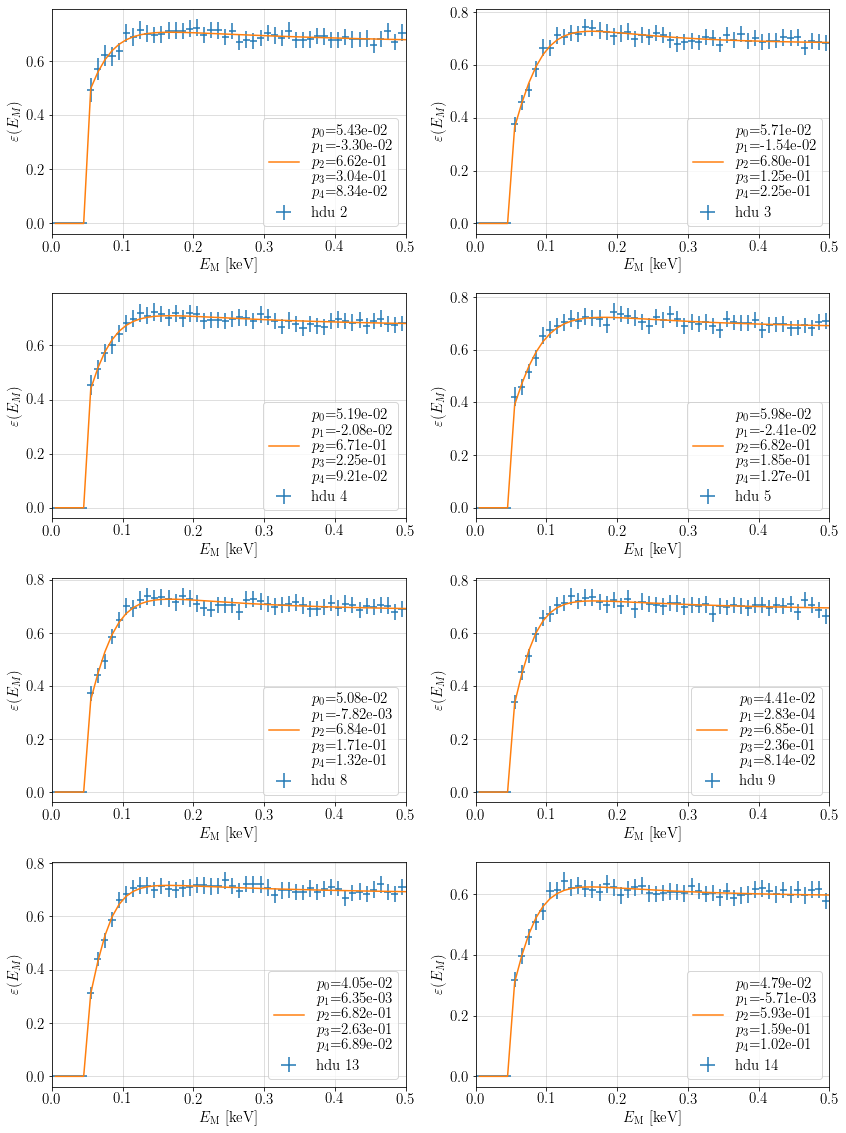

In [731]:
# effFit = lambda E, a0,a1,a2, b0, b1, c: (a2*(E-c)**2 + a1*(E-c) + a0)/(b1*(E-c) + b0)
# tanhFit2 = lambda E, a, b, c, d, e, f: tanhFit(E, a, b, c) * (E > .05) * ( f*ia.np.exp(-d*E) + e)
tanhFit2 = lambda E, a, b, c, d, e: tanhFit(E, a, b, 1.) * (E > .05) * ( e*ia.np.exp(-E/d) + c)

ia.iprint( Efficiency((.0, 2.5, .01), "on") [r"$\varepsilon(E_M)$"].curve_fit(
    x = r"$E_{\rm M}$", 
    z = "hdu", 
    func = tanhFit2,
    p0 = [ .03, .01, .7, 1., 1. ]
)).errorbar(
    x=r"$E_{\rm M}$", 
    z="hdu", 
    cols_wrap=2,
    xlim=(0, .5),
);

# print(weights)
# def print_():
#     hdus = weights["hdu"].data
#     s = ', '.join([ f'w{hdu}' for hdu in hdus])
#     print(f"# E, {s}")
#     for i, E in enumerate(weights[r"$E_{\rm M}$"].data.magnitude):
#         s = ', '.join([ f'{weights[j, i].values:.3e}' for j, _ in enumerate(weights["hdu"]) ])
#         print( f"{E:.3f}, {s}" )
    
# print_weights()

In [726]:
a = Acceptance((.0, 2.5, .01), "on")[r"$\mathcal{A}(E_I)$"].curve_fit(
        x = r"$E_{\rm I}$", 
        z = "hdu", 
        func = tanhFit,
        p0 = [ .05, .01, .9 ]
)
    
e = Efficiency((.0, 2.5, .01), "on")[r"$\varepsilon(E_M)$"].curve_fit(
        x = r"$E_{\rm M}$", 
        z = "hdu", 
        func = tanhFit2,
        p0 = [ .03, .01, .7, 1., 1. ]
)

In [727]:
for i, hdu in enumerate(e["hdu"].values):
    print( i, hdu )
    p = a.attrs["fit"][i, :].values
    print( 
        ' & '.join(
            [ f"{_:.3f}" for _ in [ p[0]*1e3, p[1]*1e3, p[2] ][::-1]]
        ) 
    )
    p = e.attrs["fit"][i, :].values
    print( 
        ' & '.join(
            [ f"{_:.3f}" for _ in [ p[0]*1e3, p[1]*1e3, p[2], p[3]*1e3, p[4] ]]
        ) 
    )

0 2
0.878 & 9.501 & 53.224
54.295 & -32.953 & 0.662 & 303.856 & 0.083
1 3
0.877 & -0.094 & 46.464
57.149 & -15.396 & 0.680 & 124.505 & 0.225
2 4
0.876 & 4.347 & 52.787
51.889 & -20.771 & 0.671 & 224.651 & 0.092
3 5
0.874 & 5.027 & 48.208
59.846 & -24.092 & 0.682 & 185.415 & 0.127
4 8
0.875 & 3.445 & 43.840
50.787 & -7.816 & 0.684 & 170.881 & 0.132
5 9
0.870 & 4.389 & 41.251
44.128 & 0.283 & 0.685 & 236.152 & 0.081
6 13
0.871 & 0.410 & 40.152
40.466 & 6.349 & 0.682 & 262.921 & 0.069
7 14
0.869 & 3.248 & 43.311
47.915 & -5.710 & 0.593 & 158.517 & 0.102


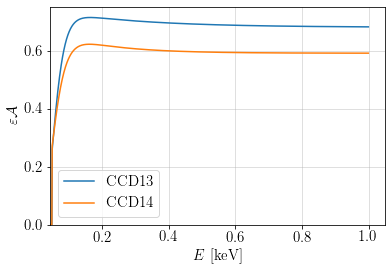

In [722]:
fig, ax = ia.plt.subplots()
for ohdu in a["hdu"].data:
    if ohdu in [3, 4, 5, 2, 9, 8]: continue
    apopt = a.attrs["fit"].sel({"hdu":ohdu}).pint.magnitude.data
    afunc = a.attrs["fit"].attrs["func"]
    epopt = e.attrs["fit"].sel({"hdu":ohdu}).pint.magnitude.data
    efunc = e.attrs["fit"].attrs["func"]
    
    ax.plot( E_I.pint.magnitude, efunc(E_I.pint.magnitude, *epopt), label=f"CCD{ohdu}" )
#     ax.plot( E_I.pint.magnitude, afunc(E_I.pint.magnitude, *apopt)*efunc(E_I.pint.magnitude, *epopt), label=f"CCD{ohdu}" )
ax.set_xlabel(r"$E$ [keV]")
ax.set_ylabel(r"$\varepsilon \mathcal{A}$")
ax.set_xlim((.045,None))
ax.set_ylim((0,None))
ax.grid(True)
ax.legend()

a
<xarray.DataArray '$\\varepsilon(E_M)$' (hdu: 8, Em: 93)>
<Quantity([[0.4932249322493225+/-0.044675759481040515
  0.5687732342007434+/-0.040724759011564846
  0.6210826210826211+/-0.03787116868802678
  0.6167883211678832+/-0.03483042260095048
  0.6354581673306773+/-0.03217335467051766
  0.702878365831012+/-0.03333681081653079
  0.6886877828054299+/-0.032441784198510175
  0.7132616487455197+/-0.033090565260272486
  0.700339558573854+/-0.03179431797104424
  0.6957585644371942+/-0.031021732954782895
  0.6984375+/-0.030442728521744452
  0.7118780096308187+/-0.031273765412422466
  0.7125103562551782+/-0.03179498019430069
  0.7110778443113773+/-0.030177984314097184
  0.7193119624706803+/-0.03109572677193233
  0.7228915662650603+/-0.03162866605374192
  0.6959876543209877+/-0.030179331151829285
  0.7129496402877699+/-0.029641100546979302
  0.7138157894736843+/-0.03171818716477074
  0.6891271056661562+/-0.029854461593739123
...
  0.5856816450875857+/-0.026595394903415354
  0.5862584017923824+/

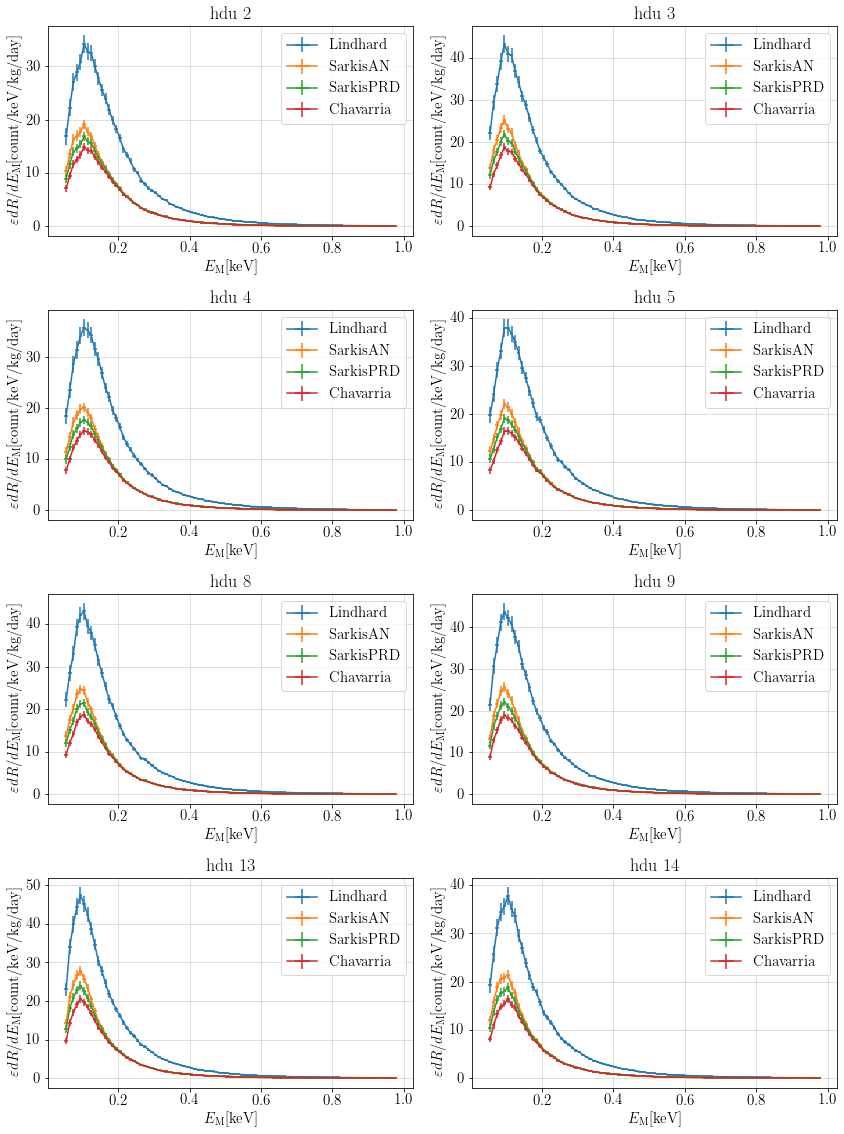

In [683]:
def edR__dE_M(ErangeM, period, ErangeI = (.01, 1, .001), v=False):
    a = Efficiency(ErangeM, period)[r"$\varepsilon(E_M)$"]
    if v:
        print("a")
        print( a )
    b = dR__dE_M( ErangeM, ErangeI, period )[{"Em":slice(1,-1)}]
    if v:
        print("b")
        print( b )
    ret = a*b
    if v:
        print("ret")
        print(ret)
    ret[r"$E_{\rm M}$"] = b[r"$E_{\rm M}$"]
#     ret.name = r"$\varepsilon d^3N/dE_{\rm M}dMdt$"
    return ret

finalRate = edR__dE_M( (.05, 1, .01), "on", v=True ) #run2019.on_excl)
finalRate.xerrorbar(
    x=r"$E_{\rm M}$", 
    yunits="count/keV/kg/day",
    ylabel = r"$\varepsilon dR/dE_{\rm M}$",
    y = ["Lindhard", "SarkisAN", "SarkisPRD", "Chavarria"],
    z="hdu", 
    fmt="", 
    cols_wrap=2,
#     xlim=(0,1)
);

### rebinned expected rate

In [684]:
_ = ia.arange(.05, 1., 0.13)*ia.ureg.keV
Ebins = ia.xr.DataArray( name=r"$E$", data=_, dims="E" )
print( Ebins )

<xarray.DataArray '$E$' (E: 8)>
<Quantity([0.05 0.18 0.31 0.44 0.57 0.7  0.83 0.96], 'kiloelectron_volt')>
Dimensions without coordinates: E


<xarray.Dataset>
Dimensions:      (Em: 7, hdu: 8)
Coordinates:
    $E_{\rm M}$  (Em) float64 [keV] 0.115 0.245 0.375 0.505 0.635 0.765 0.895
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: Em
Data variables:
    Lindhard     (hdu, Em) float64 [] 27.26 11.68 3.54 ... 0.452 0.1961 0.09062
    SarkisPRD    (hdu, Em) float64 [] 13.26 4.887 1.31 ... 0.06061 0.02717
    SarkisAN     (hdu, Em) float64 [] 14.64 4.895 1.277 ... 0.05558 0.02441
    Chavarria    (hdu, Em) float64 [] 11.76 4.729 1.265 ... 0.05559 0.0249
<xarray.Dataset>
Dimensions:      (Em: 7, hdu: 8)
Coordinates:
    $E_{\rm M}$  (Em) float64 [keV] 0.115 0.245 0.375 0.505 0.635 0.765 0.895
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: Em
Data variables:
    Lindhard     (hdu, Em) float64 [] 27.26 11.68 3.54 ... 0.452 0.1961 0.09062
    SarkisPRD    (hdu, Em) float64 [] 13.26 4.887 1.31 ... 0.06061 0.02717
    SarkisAN     (hdu, Em) float64 [] 14.64 4.895 1.277 ... 0

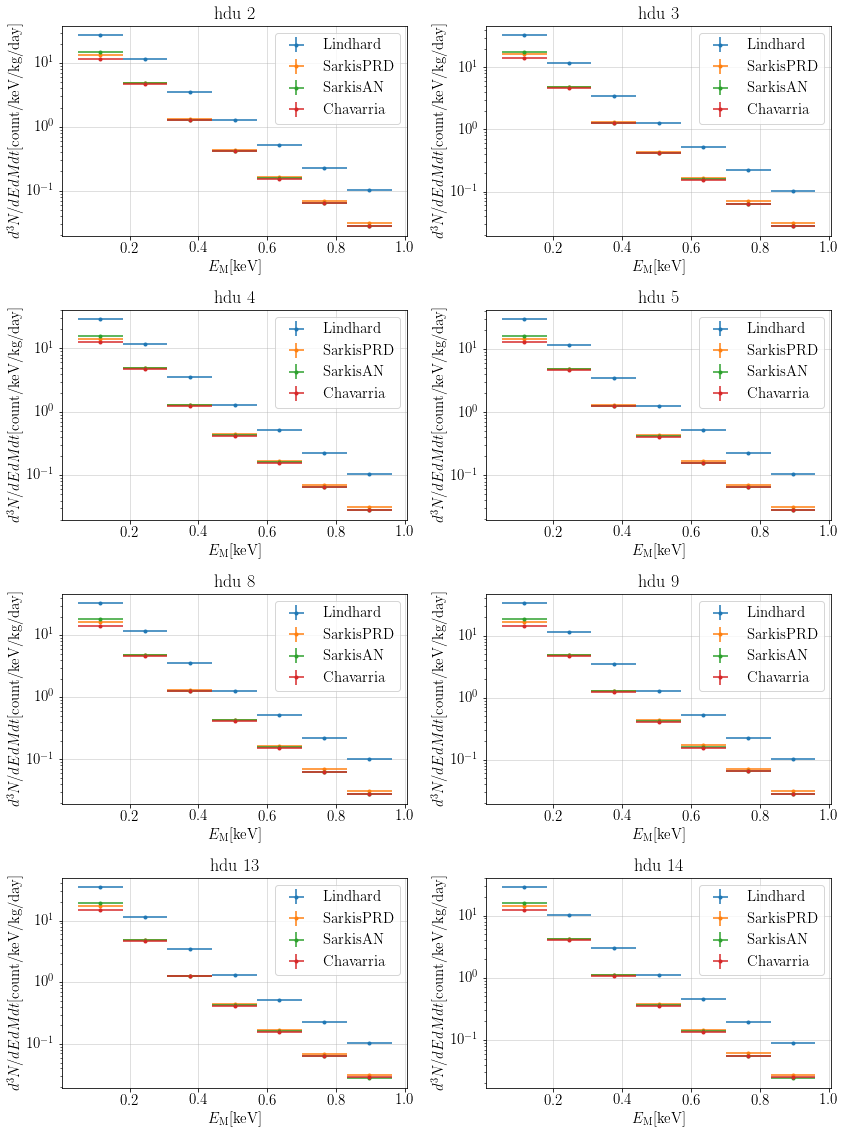

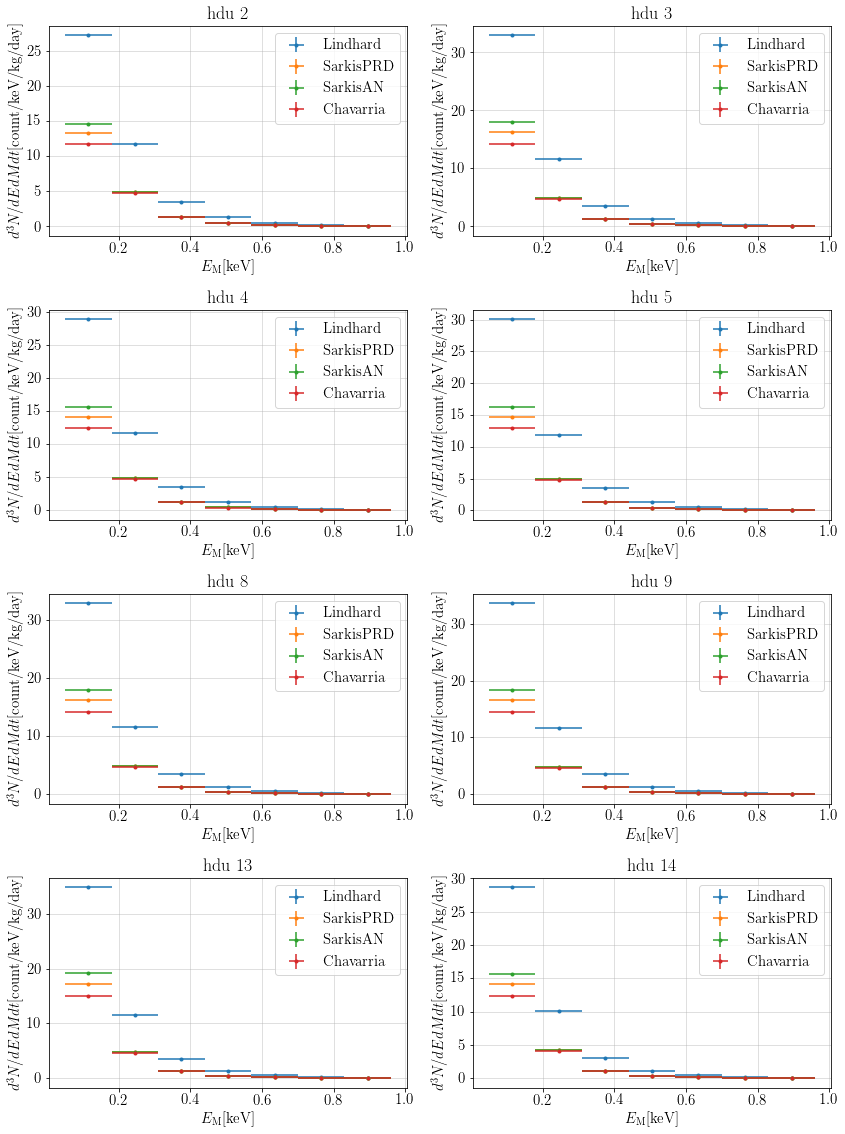

In [685]:
def rebin( rate, Emin, Emax, binsize ):
    _ = ia.arange(Emin, Emax, binsize)*ia.ureg.keV
    Ebins = ia.xr.DataArray( name=r"$E_{\rm M}$", data=_, dims="Em" )
#     print( Ebins )
    _EM = r"$E_{\rm M}$"
    ds = rate.set_coords(_EM)

    data = { 
        variable: ia.xr.DataArray(
            data = [ 
                ia.binned_statistic( 
                    datum.coords[r"$E_{\rm M}$"].pint.magnitude, 
                    ia.un.nominal_values(datum.pint.magnitude), 
                    statistic = "mean", 
                    bins = Ebins.pint.magnitude 
                )[0]
                for hdu in ds["hdu"] 
                for datum in [ds[variable].loc[{"hdu":hdu.data}]]
            ],
            dims = ("hdu", "Em"),
            attrs = { "units": str(ds[variable].pint.units) }
        )
        for variable in ds.data_vars
    }
    ret = ia.xr.Dataset(
        data_vars = data,
        coords = { 
            r"$E_{\rm M}$": (Ebins[1:]+Ebins[:-1])/2,
            "hdu": ds["hdu"]
        }
    ).pint.quantify()

    return ret

ia.iprint( rebin( finalRate, .05, 1., .13 ) ).xerrorbar(
    x = r"$E_{\rm M}$", 
    y = [ "Lindhard", "SarkisPRD", "SarkisAN", "Chavarria" ],
    yunits = "count/keV/kg/day",
    ylabel = r"$d^3N/dEdMdt$",
    z = "hdu", 
    fmt = ".", 
    cols_wrap = 2,
    yscale = "log"
);
ia.iprint( rebin( finalRate, .05, 1., .13 ) ).xerrorbar(
    x = r"$E_{\rm M}$", 
    y = [ "Lindhard", "SarkisPRD", "SarkisAN", "Chavarria" ],
    yunits = "count/keV/kg/day",
    ylabel = r"$d^3N/dEdMdt$",
    z = "hdu", 
    fmt = ".", 
    cols_wrap = 2,
#     yscale = "log"
)

In [687]:
_ = rebin( finalRate, .05, 1., .13 )

for variable in _.data_vars:
    print( variable )
    print( "keV\t" + "\t".join([ f"{ia.un.uarray(E.data.magnitude,0.065):~.2uP}" for E in _[r"$E_{\rm M}$"] ]) )
    for hdu, row in zip(_["hdu"], _[variable]):
        print( f"{hdu.data}\t" + "\t".join([ f"{col.data.magnitude:.8}" for col in row ]) )
    print()

Lindhard
keV	0.115±0.065	0.245±0.065	0.375±0.065	0.505±0.065	0.635±0.065	0.765±0.065	0.895±0.065
2	27.259602	11.681786	3.5400521	1.2775274	0.51417149	0.22423414	0.10300378
3	32.949644	11.600865	3.5134857	1.2778796	0.51563488	0.22502026	0.1027704
4	28.922436	11.637804	3.5023516	1.291426	0.52172445	0.22675523	0.10473126
5	30.055542	11.809921	3.5167497	1.2796993	0.51911878	0.2274177	0.10444633
8	32.917654	11.610017	3.5218556	1.2825477	0.51789455	0.22350502	0.10224383
9	33.649641	11.598634	3.5124886	1.2835632	0.5259039	0.22742916	0.10337777
13	34.925828	11.583942	3.4851226	1.2896453	0.51940495	0.22379468	0.10405836
14	28.698108	10.047254	3.03782	1.1075275	0.45196001	0.19612932	0.090619101

SarkisPRD
keV	0.115±0.065	0.245±0.065	0.375±0.065	0.505±0.065	0.635±0.065	0.765±0.065	0.895±0.065
2	13.260561	4.8866547	1.3100998	0.43586233	0.16572418	0.069337632	0.030907396
3	16.211955	4.8347579	1.2959519	0.43527428	0.16598073	0.06951495	0.030801317
4	14.129141	4.8591621	1.2944929	0.44044202	0.1681255

In [ ]:
# # _ = rebin( finalRate, Ebins )

# for variable in _.data_vars:
#     print( variable )
#     print( "keV\t" + "\t".join([ f"{ia.un.uarray(E.data.magnitude,0.065):~.2uP}" for E in _[r"$E_{\rm M}$"] ]) )
#     for hdu, row in zip(_["hdu"], _[variable]):
#         print( f"{hdu.data}\t" + "\t".join([ f"{col.data.magnitude:.8}" for col in row ]) )
#     print()

In [ ]:
# rebinRate = rebin( finalRate, Ebins )

# z = "hdu"
# size = rebinRate[z].size
# cols_wrap = 2
# nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
# width, height = plt.rcParams["figure.figsize"]
# fig = plt.figure( figsize = (width*ncols, height*nrows) )        
# for i, hdu in enumerate(rebinRate["hdu"]):
#     ax = fig.add_subplot(nrows, ncols, i+1)
#     ax.set_title(f"hdu {hdu.data}")
#     ax.set_xlabel(r"$E_{\rm M}$ [keV]")
#     ax.set_ylabel(r"$d^3N/dE_{\rm M}dMdt$ [count/keV/kg/day]")
#     ax.errorbar( 
#         x = rebinRate["Ebins"] + .13/2, 
#         y = rebinRate[{"hdu":i}].data.to("count/keV/kg/day").magnitude, 
#         xerr = .13/2,
#         fmt = ".",
#         label = f"130 eV Ch"
#     )
#     ax.errorbar( 
#         x = finalRate[r"$E_{\rm M}$"].pint.magnitude, 
#         y = ia.un.nominal_values( finalRate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
#         fmt = "",
#         label = fr"$\varepsilon dR/dE_M$"
#     )
#     ax.errorbar( 
#         x = measured_rate[r"$E_{\rm M}$"].pint.magnitude, 
#         y = ia.un.nominal_values( measured_rate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
#         fmt = "",
#         label = fr"$dR/dE_M$"
#     )
#     ax.errorbar( 
#         x = acceptance_rate[r"$E_{\rm I}$"].pint.magnitude, 
#         y = ia.un.nominal_values( acceptance_rate[{"hdu":i}].data.to("count/keV/kg/day").magnitude ), 
#         fmt = "",
#         label = r"$\mathcal{A}dR/dE_I$"
#     )
#     ax.errorbar( 
#         x = ionization_rate[r"$E_{\rm I}$"].pint.magnitude, 
#         y = ia.un.nominal_values( ionization_rate.data.to("count/keV/kg/day").magnitude ), 
#         fmt = "",
#         label = r"$dR/dE_I$"
#     )
#     ax.set_xlim((.03,.5))
#     ax.set_ylim((0,40))
#     ax.grid(True)
#     plt.legend()
# fig.tight_layout()

## differential rate 2019

In [688]:
_ = ia.arange( .05-0.13/2, 10, 0.13 )*ia.ureg.keV
EbinsData = ia.xr.DataArray( name=r"$E$", data=_, dims="E" )
print( EbinsData )

<xarray.DataArray '$E$' (E: 78)>
<Quantity([-0.015  0.115  0.245  0.375  0.505  0.635  0.765  0.895  1.025  1.155
  1.285  1.415  1.545  1.675  1.805  1.935  2.065  2.195  2.325  2.455
  2.585  2.715  2.845  2.975  3.105  3.235  3.365  3.495  3.625  3.755
  3.885  4.015  4.145  4.275  4.405  4.535  4.665  4.795  4.925  5.055
  5.185  5.315  5.445  5.575  5.705  5.835  5.965  6.095  6.225  6.355
  6.485  6.615  6.745  6.875  7.005  7.135  7.265  7.395  7.525  7.655
  7.785  7.915  8.045  8.175  8.305  8.435  8.565  8.695  8.825  8.955
  9.085  9.215  9.345  9.475  9.605  9.735  9.865  9.995], 'kiloelectron_volt')>
Dimensions without coordinates: E


In [689]:
# rho = 2.33 *ia.ureg('g/cm^3') #kg/m^3
rho = 2.42 * ia.ureg('g/cm^3')
dM = rho * (15*ia.ureg('micrometer'))**2 * 675*ia.ureg("micrometer") * 4120**2
dM = dM.to('kg')
print( dM )


0.006238728539999999 kg


In [690]:
Non = 735
Noff = 652
Ton = Non * ia.ureg("hour").to("day")
Toff = Noff * ia.ureg("hour").to("day")
print( Ton, Toff )

30.625 d 27.166666666666664 d


In [691]:
run2019.on_eff

((((((runID>6030) & (runID<6227)) | ((runID>6974) & (runID<7522))) & ((runID!=6415) & (runID!=6475) & (runID!=6499) & (runID!=6926) & (runID!=6927) & (runID!=6031) & (runID!=6093) & (runID!=6096) & (runID!=6139) & (runID!=7074) & (runID!=7222) & (runID!=7226) & (runID!=7374))) & ((xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0))) & ((sizell<.95) & (sizell>0))) & ((E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50))

return Rate((0.05, 10, 0.13), off, corrected_mass=False)
  call dN__dE_M((0.05, 10, 0.13), off
  return dN__dE_M((0.05, 10, 0.13), off
return Rate((0.05, 10, 0.13), off, corrected_mass=False)
<xarray.Dataset>
Dimensions:          (Em: 75, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$      (Em) float64 [keV] 0.115 0.245 0.375 ... 9.475 9.605 9.735
Dimensions without coordinates: Em
Data variables:
    $dN/dE_{\rm M}$  (hdu, Em) object [count/d/keV/kg] (5.5+/-0.5)e+03 ... (3...


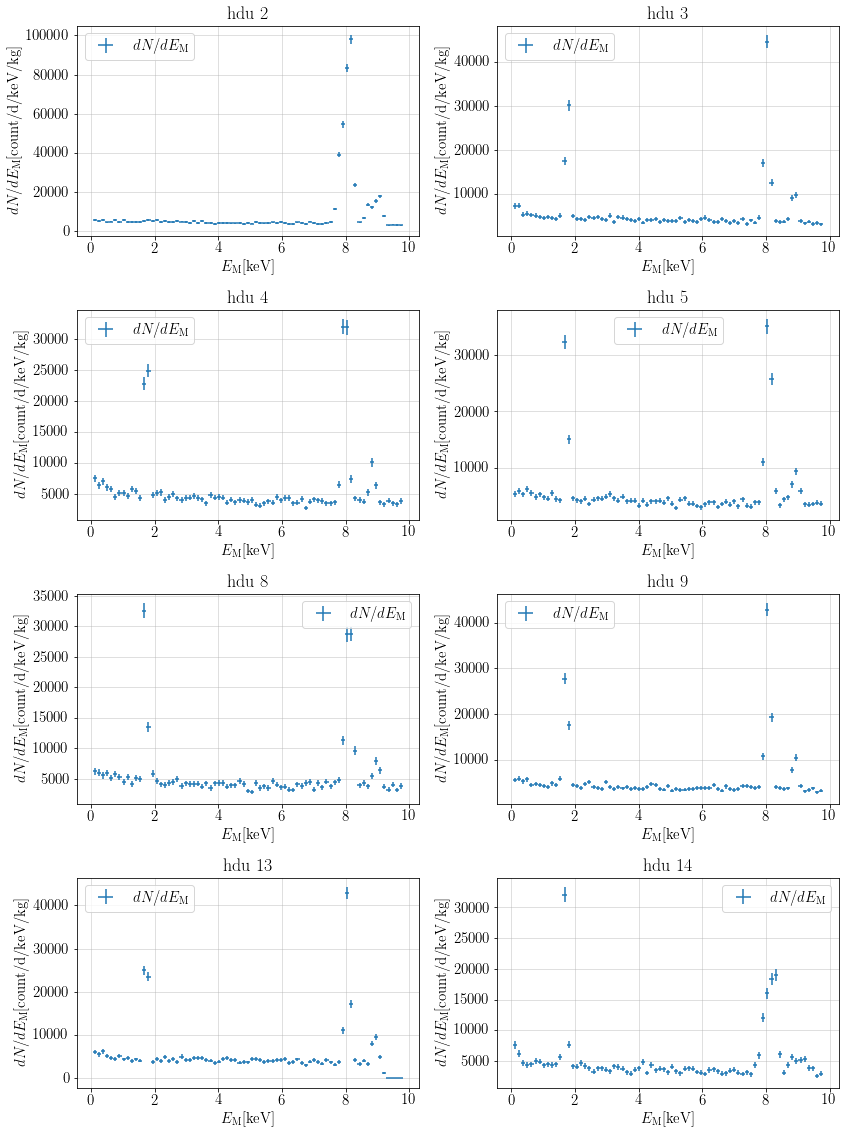

In [693]:
def Rate( Erange, period, dM, T=None, tabs=0, corrected_mass = False ):
    print( "  "*tabs + f"return Rate({Erange}, {period}, corrected_mass={corrected_mass})" )
        
    if T is None:
        if period == "off":
            N = 652
        elif period == "on":
            N = 735
        T = N * (ia.ureg("hour") + 4*ia.ureg("minutes")).to("day")
    else:
        T *= ia.ureg("hour").to("day")
    a = dN__dE_M( Erange, period, tabs=tabs+1 )
    if corrected_mass:
        dM = correctedMass( dM, Erange, period)
    ret = a/dM/T
    ret = ret.assign_coords( {r"$E_{\rm M}$": a[r"$E_{\rm M}$"]} )
    print( "  "*tabs + f"return Rate({Erange}, {period}, corrected_mass={corrected_mass})" )
    return ret

offRate = Rate( (.05, 10, .13), "off", dMxy)
ia.iprint(
    offRate
).xerrorbar( 
    x = r"$E_{\rm M}$", 
#     y = r"$dN/dE$", 
    y = r"$dN/dE_{\rm M}$",
    z = "hdu", 
    fmt = " "
)
# print(diffRate)

return Rate((0.05, 10, 0.13), off, corrected_mass=True)
  call dN__dE_M((0.05, 10, 0.13), off
  return dN__dE_M((0.05, 10, 0.13), off
call correctedMass((0.05, 10, 0.13))
return correctedMass((0.05, 10, 0.13))
return Rate((0.05, 10, 0.13), off, corrected_mass=True)
<xarray.Dataset>
Dimensions:          (Em: 75, hdu: 8)
Coordinates:
  * hdu              (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm M}$      (Em) float64 [keV] 0.115 0.245 0.375 ... 9.475 9.605 9.735
Dimensions without coordinates: Em
Data variables:
    $dN/dE_{\rm M}$  (hdu, Em) object [count/d/keV/kg] (6.4+/-0.6)e+03 ... (3...


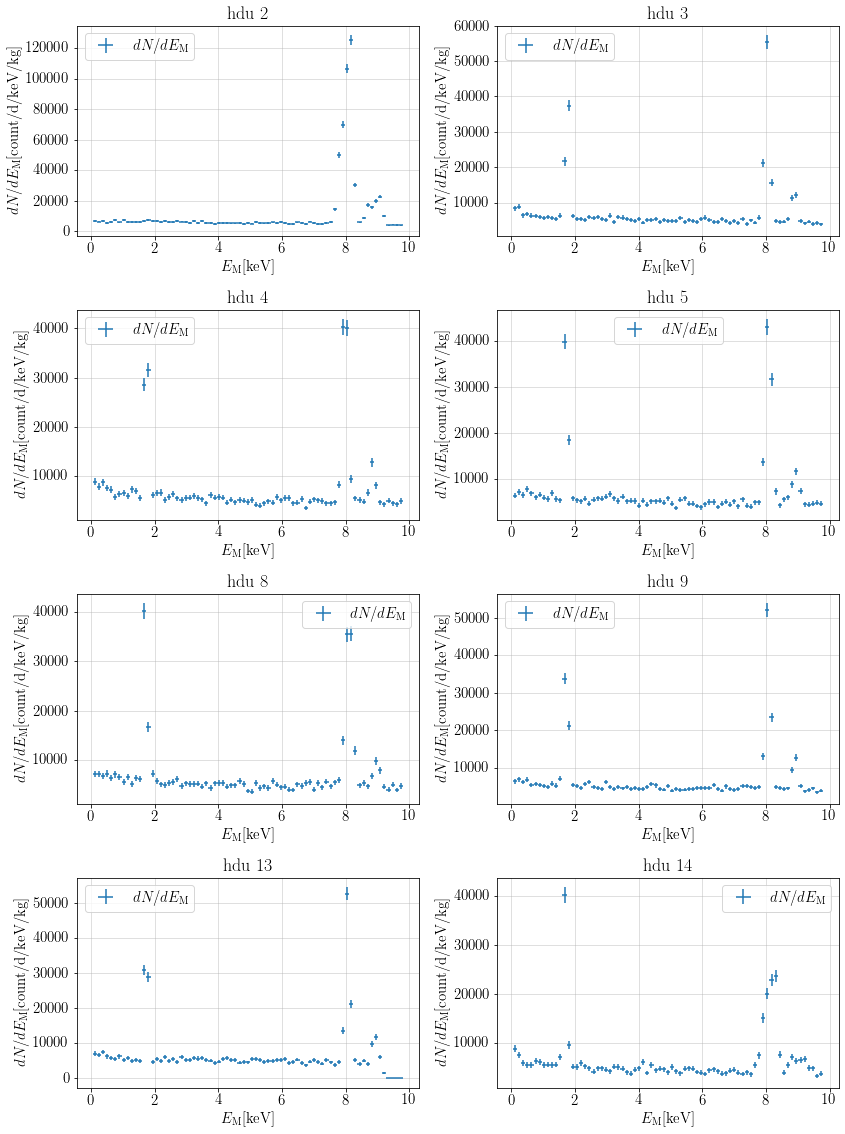

In [694]:
ia.iprint(
    Rate( (.05, 10, .13), "off", dMxy, corrected_mass=True )
).xerrorbar( 
    x = r"$E_{\rm M}$", 
#     y = r"$dN/dE$", 
    y = r"$dN/dE_{\rm M}$",
    z = "hdu", 
    fmt = " "
)

In [695]:
def averageRate( rate, weights = None ):
    if weights is None:
#         std_devs = ia.xr.apply_ufunc( ia.un.std_devs, rate[r"$dN/dE$"].pint.dequantify() ).pint.quantify()
        std_devs = ia.xr.apply_ufunc( ia.un.std_devs, rate.pint.dequantify() ).pint.quantify()
        weights = 1./std_devs**2

#     return ( rate[r"$dN/dE$"] * weights ).sum("hdu")/weights.sum("hdu"), weights
    return ( rate * weights ).sum("hdu")/weights.sum("hdu"), weights

return Rate((0.05, 10, 0.13), ((runID>6226) & (runID<6975)) & ((runID!=6415) & (runID!=6475) & (runID!=6499) & (runID!=6926) & (runID!=6927) & (runID!=6031) & (runID!=6093) & (runID!=6096) & (runID!=6139) & (runID!=7074) & (runID!=7222) & (runID!=7226) & (runID!=7374)), corrected_mass=False)
  call dN__dE_M((0.05, 10, 0.13), ((runID>6226) & (runID<6975)) & ((runID!=6415) & (runID!=6475) & (runID!=6499) & (runID!=6926) & (runID!=6927) & (runID!=6031) & (runID!=6093) & (runID!=6096) & (runID!=6139) & (runID!=7074) & (runID!=7222) & (runID!=7226) & (runID!=7374))
call get_events_data(((runID>6226) & (runID<6975)) & ((runID!=6415) & (runID!=6475) & (runID!=6499) & (runID!=6926) & (runID!=6927) & (runID!=6031) & (runID!=6093) & (runID!=6096) & (runID!=6139) & (runID!=7074) & (runID!=7222) & (runID!=7226) & (runID!=7374)))
call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
  return dN__dE_M((0.05, 10, 0.13), ((r

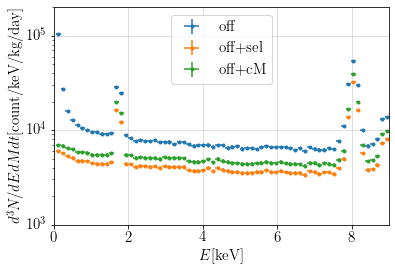

In [696]:
def plot_meanRate( Erange, period, dM, T, label, **kwargs ):
    meanRate, _ = averageRate( Rate(Erange, period, dM, T)[r"$dN/dE_{\rm M}$"] )
    plt.errorbar( 
        meanRate[r"$E_{\rm M}$"].pint.magnitude, 
        ia.un.nominal_values(meanRate.data.magnitude),
        xerr = Erange[2]/2,
        yerr = ia.un.std_devs(meanRate.data.magnitude),
        fmt = ".",
        label = label
    )
    plt.xlabel(r"$E$[keV]")
    plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
    plt.ylim((1e3,2e5))
    plt.xlim((0,9.))
    plt.yscale(kwargs.pop("yscale", "linear"))
    plt.grid(True)
    plt.legend()
    return meanRate

plot_meanRate( (.05, 10, .13), run2019.off_excl, dMxy, T=652, label ="off", yscale="log");
plot_meanRate( (.05, 10, .13), run2019.off_eff, dM, T=652, label = "off+sel", yscale="log");
plot_meanRate( 
    (.05, 10, .13), 
    run2019.off_eff, 
    correctedMass( dM, (.05, 10, .13), run2019.off_excl), 
    T=652, 
    label = "off+cM", 
    yscale="log"
);

# signal to noise ratio

in order to estimate the significance of the result, the expected signal is compared to the uncertainty of the lack of the signal.
$$ 
\frac{ (N_\nu + N_{\rm BG}) - N_{\rm BG} }{
    \sqrt{ \delta(N_\nu + N_{\rm BG})^2 + \delta(N_{\rm BG})^2 }
}
$$
using that $\delta(N) = \sqrt{N}$ and
$$
N = dE dM dt \frac{dN}{dEdMdt}
$$
$$ 
= \frac{ (N_\nu + N_{\rm BG}) - N_{\rm BG} }{
    \sqrt{ N_\nu + 2N_{\rm BG} }
}
$$

this, effectively describes how many sigmas the hypothesis can be distinguisehd from its negation.

The previous definition can be further developed into
$$
\frac{ N_\nu + N_{\rm BG} }{\delta(N_{\rm BG}) }
= \left( \frac{dN_\nu}{dEdMdt} + \frac{dN_{\rm BG}}{dEdMdt} \right) dE dM dt \left( \frac{dN_{\rm BG}}{dEdMdt} dE dM dt \right)^{-1}
$$

In [697]:
def SNR( Emin, Emax, binsize, period, Ton, Toff, mass=dM ):
    aveRate, weights = averageRate( Rate(Emin, Emax, binsize, period, Toff)[r"$dN/dE$"] )
    print( aveRate )
    expected = rebin( finalRate, Emin, Emax, binsize )["Chavarria"]
    aveExpected, _ = averageRate( expected, weights=weights )
    print( aveExpected )
    sig = aveExpected*mass*Ton
    noise = (aveExpected + aveRate*Toff/Ton)*mass*Ton + aveRate*mass*Toff*(Ton/Toff)**2
    return sig/ ( noise )**.5

In [698]:
SNR(.05, .6, .13, run2019.off_eff, 735, 652 )

TypeError: unsupported operand type(s) for *: 'float' and 'Selection'

In [ ]:
def SNR2( Emin, Emax, binsize, period, Ton, Toff, mass=dM ):
    aveRate, weights = averageRate( Rate(Emin, Emax, binsize, period, Toff)[r"$dN/dE$"] )
    print( aveRate )
    expected = rebin( finalRate, Emin, Emax, binsize )["Chavarria"]
    aveExpected, _ = averageRate( expected, weights=weights )
    print( aveExpected )
    on = (aveExpected + aveRate).pint.magnitude
    off = aveRate.pint.magnitude
    return ((on - off)+ 1.64* (on+off)**.5 )/(on-off)

In [ ]:
SNR2(.05, .6, .13, run2019.off_eff, 735, 652 )

return Rate((0.05, 10, 0.13), on, corrected_mass=False)
  call dN__dE_M((0.05, 10, 0.13), on
  return dN__dE_M((0.05, 10, 0.13), on
return Rate((0.05, 10, 0.13), on, corrected_mass=False)
<xarray.DataArray '$dN/dE_{\\rm M}$' (Em: 75)>
<Quantity([6731.975497458871+/-188.78074349851371
 6108.429704581371+/-179.82547622501016
 5486.029667229462+/-170.41801594393567
 5199.999923001976+/-165.91593450074708
 4642.821020354746+/-156.7752131519673
 4701.197555243413+/-157.75774133356953
 5077.085160176896+/-163.94329253361337
 4950.482525080889+/-161.88633640465292
 4907.200713262124+/-161.1771008799116
 4836.104290592503+/-160.0052592515766
 4513.814554516994+/-154.58177334763295
 4900.092532612437+/-161.06032441190712
 17539.241889849993+/-304.7135997173726
 12169.472256472778+/-253.817932015252
 4858.486593611694+/-160.37509743588595
 4256.0506355482075+/-150.1031554493343
 4773.813001740685+/-158.97144812058093
 4330.057028294015+/-151.40256643901924
 4260.994966498454+/-150.1903189162176


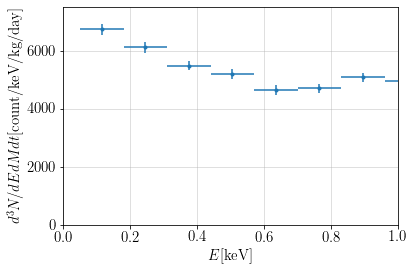

In [700]:
meanOnRate, _ = averageRate( Rate( (.05, 10, .13), "on", dMxy )[r"$dN/dE_{\rm M}$"] ) #Rate(Emin, Emax, binsize, period, T)[r"$dN/dE$"]
print( meanOnRate )
plt.errorbar( 
    meanOnRate[r"$E_{\rm M}$"].pint.magnitude, 
    ia.un.nominal_values(meanOnRate.data.magnitude),
    xerr = .065,
    yerr = ia.un.std_devs(meanOnRate.data.magnitude),
    fmt = ".",
)
plt.xlabel(r"$E$[keV]")
plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
plt.ylim((0,7.5e3))
plt.xlim((0,1.))
plt.grid(True);

In [706]:
# meanRate, _ = averageRate(
#     Rate( (.05, 10, .13), "on", dMxy)[r"$dN/dE_{\rm M}$"] - Rate( (.05, 10, .13), "off", dMxy)[r"$dN/dE_{\rm M}$"]
# )
# # ia.iprint(
# #     meanRate
# # ).xerrorbar( 
# #     x = r"$E_{\rm M}$", 
# #     y = r"$dN/dE$", 
# # #     z = "hdu", 
# #     fmt = " "
# # )
# with plt.rc_context({'figure.figsize': (12, 5)}):
#     print("# E, diff, err")
#     for e, diff, differr in zip(
#         meanRate[r"$E_{\rm M}$"].pint.magnitude,
#         ia.un.nominal_values(meanRate.data.magnitude),
#         ia.un.std_devs(meanRate.data.magnitude),
#     ):
#         print(f"{e:.3f}, {diff:.0f}, {differr:.0f}")
    
#     plt.errorbar( 
#         meanRate[r"$E_{\rm M}$"].pint.magnitude, 
#         ia.un.nominal_values(meanRate.data.magnitude),
#         xerr = .065,
#         yerr = ia.un.std_devs(meanRate.data.magnitude),
#         fmt = ".",
#     )
#     plt.xlabel(r"$E$[keV]")
#     plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
#     # plt.ylim((0,7.5e3))
#     plt.xlim((0,9.))
#     plt.grid(True);

return Rate((0.05, 9.5, 0.13), on, corrected_mass=True)
  call dN__dE_M((0.05, 9.5, 0.13), on
  return dN__dE_M((0.05, 9.5, 0.13), on
call correctedMass((0.05, 9.5, 0.13))
return correctedMass((0.05, 9.5, 0.13))
return Rate((0.05, 9.5, 0.13), on, corrected_mass=True)
return Rate((0.05, 9.5, 0.13), off, corrected_mass=True)
  call dN__dE_M((0.05, 9.5, 0.13), off
  return dN__dE_M((0.05, 9.5, 0.13), off
call correctedMass((0.05, 9.5, 0.13))
return correctedMass((0.05, 9.5, 0.13))
return Rate((0.05, 9.5, 0.13), off, corrected_mass=True)
# E, diff, err
0.115, 486, 317
0.245, 91, 316
0.375, -83, 307
0.505, -221, 303
0.635, -432, 290
0.765, -358, 291
0.895, 234, 296
1.025, 376, 291
1.155, 352, 290
1.285, 216, 291
1.415, -104, 285
1.545, 110, 294
1.675, 138, 571
1.805, -494, 481
1.935, 250, 290
2.065, -334, 280
2.195, 592, 283
2.325, -82, 278
2.455, -97, 276
2.585, -99, 275
2.715, -153, 276
2.845, 381, 278
2.975, -183, 276
3.105, -83, 276
3.235, 37, 277
3.365, 71, 276
3.495, -364, 271
3.625, 

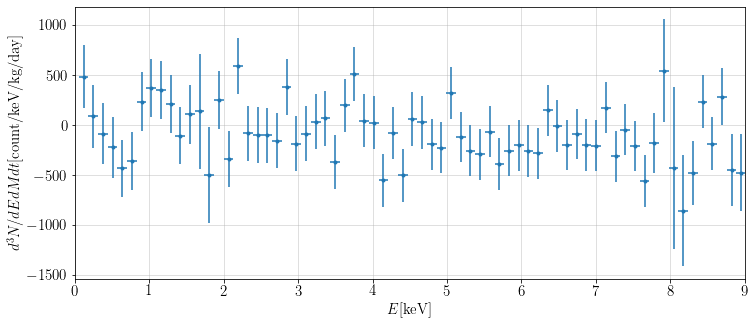

In [671]:
def meanDiffRate( 
    Erange=(.05, 9.5, .13),
    dM=dM,
    corrected = True
):
    rateOn = Rate( 
        Erange, 
        "on", 
        dM,
        corrected_mass = corrected
    )[r"$dN/dE_{\rm M}$"] 

    rateOff = Rate( 
        Erange, 
        "off", 
        dM,
        corrected_mass = corrected
    )[r"$dN/dE_{\rm M}$"] 
        
    return averageRate( rateOn - rateOff )

meanRate, weights = meanDiffRate( (.05, 9.5, .13), dMxy, corrected=True )

with plt.rc_context({'figure.figsize': (12, 5)}):
    print("# E, diff, err")
    for e, diff, differr in zip(
        meanRate[r"$E_{\rm M}$"].pint.magnitude,
        ia.un.nominal_values(meanRate.data.magnitude),
        ia.un.std_devs(meanRate.data.magnitude),
    ):
        print(f"{e:.3f}, {diff:.0f}, {differr:.0f}")

    plt.errorbar( 
        meanRate[r"$E_{\rm M}$"].pint.magnitude, 
        ia.un.nominal_values(meanRate.data.magnitude),
        xerr = .065,
        yerr = ia.un.std_devs(meanRate.data.magnitude),
        fmt = ".",
    )
    plt.xlabel(r"$E$[keV]")
    plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
    # plt.ylim((0,7.5e3))
    plt.xlim((0,9.))
    plt.grid(True);

In [703]:
# def print_table(title, ds, x, y):
#     s = f"# {x}, {y}\n"
#     for i, Y in ds[y].values:
#         print( i, Y )
#         s += f"{}"
    
# countON = dNsel__dE_M( (.05, 9.5, .13), run2019.on_eff )
# ia.iprint( countON )
# rateON = countON/dM/Ton
# std_devsON = ia.xr.apply_ufunc( ia.un.std_devs, rateON[r"$dN/dE_{\rm M}$"].pint.dequantify() ).pint.quantify()
# weightsON = 1./std_devsON**2

# rateON = (
#     ( rateON[r"$dN/dE_{\rm M}$"] * weightsON ).sum("hdu")/weightsON.sum("hdu") 
# )

# rateOFF = dNsel__dE_M( (.05, 9.5, .13), run2019.off_eff )/dM/Toff
# std_devsOFF = ia.xr.apply_ufunc( ia.un.std_devs, rateOFF[r"$dN/dE_{\rm M}$"].pint.dequantify() ).pint.quantify()
# weightsOFF = 1./std_devsOFF**2

# rateOFF = (
#     ( rateOFF[r"$dN/dE_{\rm M}$"] * weightsOFF ).sum("hdu")/weightsOFF.sum("hdu") 
# )
# with plt.rc_context({'figure.figsize': (12, 5)}):
#     plt.errorbar( 
#         rateON[r"$E_{\rm M}$"].pint.magnitude, 
#         ia.un.nominal_values(rateON.data.magnitude),
#         xerr = .065,
#         yerr = ia.un.std_devs(rateON.data.magnitude),
#         fmt = ".",
#         label = "Reactor on"
#     )
#     plt.errorbar( 
#         rateOFF[r"$E_{\rm M}$"].pint.magnitude, 
#         ia.un.nominal_values(rateOFF.data.magnitude),
#         xerr = .065,
#         yerr = ia.un.std_devs(rateOFF.data.magnitude),
#         fmt = ".",
#         label = "Reactor off"
#     )
#     plt.xlabel(r"$E$[keV]")
#     plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
# #     plt.ylim((-1100,1100))
#     plt.ylim((0,None))
#     plt.xlim((0,9))
#     plt.grid(True);
#     plt.legend(frameon=False, title="differential rate", loc="upper left")

32.666666666666664 d 28.977777777777774 d
Ton 32.666666666666664 d
Toff 28.977777777777774 d
call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call correctedMass((0.05, 9.5, 0.13))
return correctedMass((0.05, 9.5, 0.13))
call genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
return genfromroot({'E': ('E1/gain3Peaks', 'keV'), 'hdu': 'ohdu'})
call correctedMass((0.05, 9.5, 0.13))
return correctedMass((0.05, 9.5, 0.13))
# E, ON, ONerr, OFF, OFFerr
0.115, 7745, 220, 7290, 227
0.245, 7282, 217, 7210, 230
0.375, 6669, 209, 6765, 224
0.505, 6366, 205, 6570, 221
0.635, 5703, 194, 6138, 214
0.765, 5792, 196, 6141, 215
0.895, 6279, 205, 6072, 213
1.025, 6141, 203, 5767, 208
1.155, 6087, 202, 5738, 208
1.285, 6002, 200, 5775, 209
1.415, 5616, 194, 5740, 208
1.545, 6074, 202, 5966, 212
1.675, 21716, 394, 21061, 413
1.805, 15054, 324, 15971, 355
1.935, 6033, 201, 5744, 208
2.065, 5294, 188, 5667, 207
2.195, 

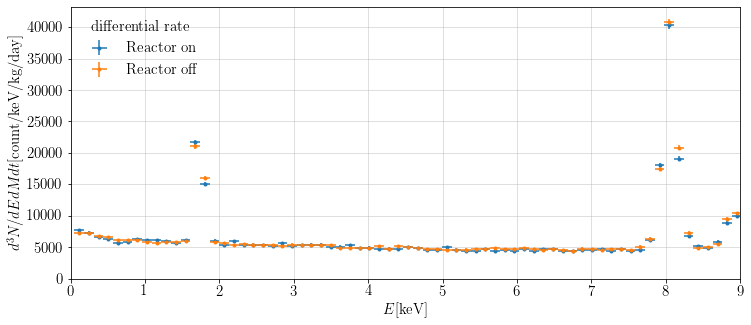

In [704]:
Non = 735
Noff = 652
Ton = Non * (ia.ureg("hour") + 4*ia.ureg("minutes")).to("day")
Toff = Noff * (ia.ureg("hour") + 4*ia.ureg("minutes")).to("day")
print( Ton, Toff )
print( "Ton", Ton )
print( "Toff", Toff )

countON = dNsel__dE_M( (.05, 9.5, .13), run2019.on_eff )
# ia.iprint( countON )
rateON = countON/correctedMass(dMxy, (.05, 9.5, .13), "on")/Ton
std_devsON = ia.xr.apply_ufunc( ia.un.std_devs, rateON[r"$dN/dE_{\rm M}$"].pint.dequantify() ).pint.quantify()
weightsON = 1./std_devsON**2

rateON = (
    ( rateON[r"$dN/dE_{\rm M}$"] * weightsON ).sum("hdu")/weightsON.sum("hdu") 
)
# print( rateON )

countOFF = dNsel__dE_M( (.05, 9.5, .13), run2019.off_eff )
rateOFF = countOFF/correctedMass(dMxy, (.05, 9.5, .13), "off")/Toff
std_devsOFF = ia.xr.apply_ufunc( ia.un.std_devs, rateOFF[r"$dN/dE_{\rm M}$"].pint.dequantify() ).pint.quantify()
weightsOFF = 1./std_devsOFF**2

rateOFF = (
    ( rateOFF[r"$dN/dE_{\rm M}$"] * weightsOFF ).sum("hdu")/weightsOFF.sum("hdu") 
)
with plt.rc_context({'figure.figsize': (12, 5)}):
    print("# E, ON, ONerr, OFF, OFFerr")
    for e, on, onerr, off, offerr in zip(
        countON[r"$E_{\rm M}$"].pint.magnitude,
        ia.un.nominal_values(rateON.pint.magnitude),
        ia.un.std_devs(rateON.pint.magnitude),
        ia.un.nominal_values(rateOFF.pint.magnitude),
        ia.un.std_devs(rateOFF.pint.magnitude),        
    ):
        print( f"{e:.3f}, {on:.0f}, {onerr:.0f}, {off:.0f}, {offerr:.0f}")
    plt.errorbar( 
        countON[r"$E_{\rm M}$"].pint.magnitude, 
        ia.un.nominal_values(rateON.pint.magnitude),
        xerr = .065,
        yerr = ia.un.std_devs(rateON.pint.magnitude),
        fmt = ".",
        label = "Reactor on"
    )
    plt.errorbar( 
        countON[r"$E_{\rm M}$"].pint.magnitude, 
        ia.un.nominal_values(rateOFF.pint.magnitude),
        xerr = .065,
        yerr = ia.un.std_devs(rateOFF.pint.magnitude),
        fmt = ".",
        label = "Reactor off"
    )
    plt.xlabel(r"$E$[keV]")
    plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
#     plt.ylim((-1100,1100))
    plt.ylim((0,None))
    plt.xlim((0,9))
    plt.grid(True);
    plt.legend(frameon=False, title="differential rate", loc="upper left")

In [527]:
std_devs = ia.xr.apply_ufunc( ia.un.std_devs, diffRate[r"$dN/dE$"].pint.dequantify() ).pint.quantify()
weights = 1./std_devs**2

meanRate = (
    ( diffRate[r"$dN/dE$"] * weights ).sum("hdu")/weights.sum("hdu") 
)
with plt.rc_context({'figure.figsize': (12, 5)}):
    plt.errorbar( 
        meanRate[r"$E$"].pint.magnitude, 
        ia.un.nominal_values(meanRate.data.magnitude),
        xerr = .065,
        yerr = ia.un.std_devs(meanRate.data.magnitude),
        fmt = ".",
        label = "ON$-$OFF"
    )
    plt.xlabel(r"$E$[keV]")
    plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
    plt.ylim((-1100,1100))
    plt.xlim((0,9))
    plt.grid(True);
    plt.legend(frameon=False, title="differential rate", loc="lower left")

NameError: name 'diffRate' is not defined

### 95% confidence level comparison

return Rate((0.05, 9.5, 0.13), on, corrected_mass=True)
  call dN__dE_M((0.05, 9.5, 0.13), on
  return dN__dE_M((0.05, 9.5, 0.13), on
call correctedMass((0.05, 9.5, 0.13))
return correctedMass((0.05, 9.5, 0.13))
return Rate((0.05, 9.5, 0.13), on, corrected_mass=True)
return Rate((0.05, 9.5, 0.13), off, corrected_mass=True)
  call dN__dE_M((0.05, 9.5, 0.13), off
  return dN__dE_M((0.05, 9.5, 0.13), off
call correctedMass((0.05, 9.5, 0.13))
return correctedMass((0.05, 9.5, 0.13))
return Rate((0.05, 9.5, 0.13), off, corrected_mass=True)
<xarray.Dataset>
Dimensions:      (Em: 93, hdu: 8)
Coordinates:
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: Em
Data variables:
    Lindhard     (hdu, Em) object [] 16.8+/-1.5 22.3+/-1.6 ... 0.0572+/-0.0026
    SarkisPRD    (hdu, Em) object [] 8.9+/-0.8 11.6+/-0.8 ... 0.0169+/-0.0008
    SarkisAN     (hdu, Em) object [] 10.4+/-0.9 13.6+/-1.0 ... 0.0150+/-0.0007
    Chavarria    (hdu, Em) object [] 7.1+/-0.6 9.5+/-0.7 ... 0

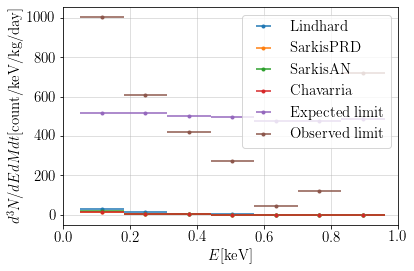

In [709]:
meanRate, weights = meanDiffRate( (.05, 9.5, .13), dMxy, corrected=True )
# expected = rebin( finalRate, Ebins )
print( finalRate )

expected = rebin( finalRate, .05, 1., .13 )
meanExpected = (
    ( expected * weights[{"Em":slice(0,7)}] ).sum("hdu")/weights[{"Em":slice(0,7)}].sum("hdu")
)
print( meanExpected )
oneSidedCLstd = 1.64 * ia.un.std_devs(meanRate.data.magnitude)
oneSidedCL = ia.un.nominal_values(meanRate.data.magnitude) + oneSidedCLstd

for variable in meanExpected.data_vars:
    plt.errorbar(
        meanExpected[r"$E_{\rm M}$"].pint.magnitude,
        meanExpected[variable].pint.magnitude,
        xerr = .065,
#         yerr = 0,
        fmt = ".",
        label = variable
    )
with plt.rc_context({'figure.figsize': (12, 5)}):
    print("# E, expLimit, obsLimit")
    for e, eL, oL in zip(
        countON[r"$E_{\rm M}$"].pint.magnitude[:7],
        oneSidedCLstd[:7],
        oneSidedCL[:7]
    ):
        print( f"{e:.3f}, {eL:.0f}, {oL:.0f}" )
    plt.errorbar( 
        countON[r"$E_{\rm M}$"].pint.magnitude[:7],
        oneSidedCLstd[:7],
        xerr = .065,
        fmt = ".",
        label = "Expected limit"
    )
    plt.errorbar( 
        countON[r"$E_{\rm M}$"].pint.magnitude[:7],
        oneSidedCL[:7],
        xerr = .065,
        fmt = ".",
        label = "Observed limit"
    )
plt.xlabel(r"$E$[keV]")
plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
# plt.ylim((-750,750))
plt.xlim((0,1.))
# plt.yscale("log")
plt.grid(True)
plt.legend();

# print( "keV\t\t" + "\t".join([ f"{ia.un.uarray(E.data.magnitude,0.065):~.2uP}" for E in meanExpected[r"$E$"] ]) )
# for variable in meanExpected.data_vars:
#     print( f"{variable}\t" + "\t".join([ f"{col.data.magnitude:.8}" for col in meanExpected[variable] ]) )
# print(f"ON─OFF 90%CL\t" + "\t".join([ f"{col:.8}" for col in onSidedCL[:4] ]) )


num
 <xarray.Dataset>
Dimensions:    (Em: 7, hdu: 8)
Coordinates:
  * hdu        (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: Em
Data variables:
    Lindhard   (hdu, Em) float64 [] 3.693e-05 1.612e-05 ... 2.884e-07 1.341e-07
    SarkisPRD  (hdu, Em) float64 [] 1.797e-05 6.743e-06 ... 8.913e-08 4.02e-08
    SarkisAN   (hdu, Em) float64 [] 1.983e-05 6.754e-06 ... 8.175e-08 3.612e-08
    Chavarria  (hdu, Em) float64 [] 1.593e-05 6.526e-06 ... 8.175e-08 3.684e-08

meanExpected
 <xarray.Dataset>
Dimensions:      (Em: 7)
Coordinates:
    $E_{\rm M}$  (Em) float64 [keV] 0.115 0.245 0.375 0.505 0.635 0.765 0.895
Dimensions without coordinates: Em
Data variables:
    Lindhard     (Em) float64 [] 31.21 11.45 3.451 1.26 0.5105 0.2219 0.1018
    SarkisPRD    (Em) float64 [] 15.32 4.778 1.274 0.4293 0.1644 0.06856 0.03053
    SarkisAN     (Em) float64 [] 16.99 4.784 1.241 0.417 0.1571 0.06288 0.02743
    Chavarria    (Em) float64 [] 13.44 4.628 1.23 0.4048 0.1522 0.06288 0.02797
k

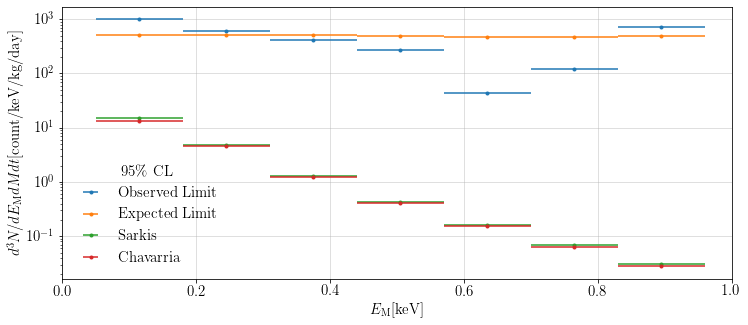

In [710]:
expected = rebin( finalRate, .05, 1., .13 )
num = expected * weights[{"Em":slice(0,7)}]
print("\nnum\n", num)
meanExpected = (
    num.sum("hdu")/weights[{"Em":slice(0,7)}].sum("hdu")
)
print("\nmeanExpected\n", meanExpected )
with plt.rc_context({'figure.figsize': (12, 5)}):
    plt.errorbar( 
        meanRate[r"$E_{\rm M}$"].pint.magnitude[:7], 
        oneSidedCL[:7],
        xerr = .065,
        fmt = ".",
        label = "Observed Limit"
    )
    plt.errorbar( 
        meanRate[r"$E_{\rm M}$"].pint.magnitude[:7], 
        oneSidedCLstd[:7],
        xerr = .065,
        fmt = ".",
        label = "Expected Limit"
    )

    onSidedCL = ia.un.nominal_values(meanRate.data.magnitude) + 1.64 * ia.un.std_devs(meanRate.data.magnitude)
    for variable in meanExpected.data_vars:
        if variable in ["SarkisPRD", "Chavarria"]:
            plt.errorbar(
                meanExpected[r"$E_{\rm M}$"].pint.magnitude,
                meanExpected[variable].pint.magnitude,
                xerr = .065,
        #         yerr = 0,
                fmt = ".",
                label = "Sarkis" if variable == "SarkisPRD" else variable
            )
    plt.xlabel(r"$E_{\rm M}$[keV]")
    plt.ylabel(r"$d^3N/dE_{\rm M}dMdt$[count/keV/kg/day]")
    # plt.ylim((-750,750))
    plt.xlim((0,1.))
    plt.yscale("log")
    plt.grid(True)
    plt.legend(title=r"95\% CL", frameon=False, loc="lower left");

print( "keV\t\t" + "\t".join([ f"{ia.un.uarray(E.data.magnitude,0.065):~.2uP}" for E in meanExpected[r"$E_{\rm M}$"] ]) )
for variable in meanExpected.data_vars:
    print( f"{variable}\t" + "\t".join([ f"{col.data.magnitude:.8}" for col in meanExpected[variable] ]) )
print(f"ON─OFF 90%CL\t" + "\t".join([ f"{col:.8}" for col in oneSidedCL[:7] ]) )


expected
 <xarray.Dataset>
Dimensions:      (Em: 7, hdu: 8)
Coordinates:
    $E_{\rm M}$  (Em) float64 [keV] 0.115 0.245 0.375 0.505 0.635 0.765 0.895
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: Em
Data variables:
    Lindhard     (hdu, Em) float64 [] 27.26 11.68 3.54 ... 0.452 0.1961 0.09062
    SarkisPRD    (hdu, Em) float64 [] 13.26 4.887 1.31 ... 0.06061 0.02717
    SarkisAN     (hdu, Em) float64 [] 14.64 4.895 1.277 ... 0.05558 0.02441
    Chavarria    (hdu, Em) float64 [] 11.76 4.729 1.265 ... 0.05559 0.0249

weights
 <xarray.DataArray '$dN/dE_{\\rm M}$' (hdu: 8, Em: 7)>
array([[1.35487577e-06, 1.37989652e-06, 1.40755479e-06, 1.51880322e-06,
        1.36693136e-06, 1.35943632e-06, 1.53771386e-06],
       [1.12102852e-06, 1.14162257e-06, 1.33335876e-06, 1.33951321e-06,
        1.51285107e-06, 1.44301181e-06, 1.49016849e-06],
       [1.03421440e-06, 1.06409353e-06, 1.08493654e-06, 1.26495762e-06,
        1.38376292e-06, 1.49756364e-06, 1.34634357

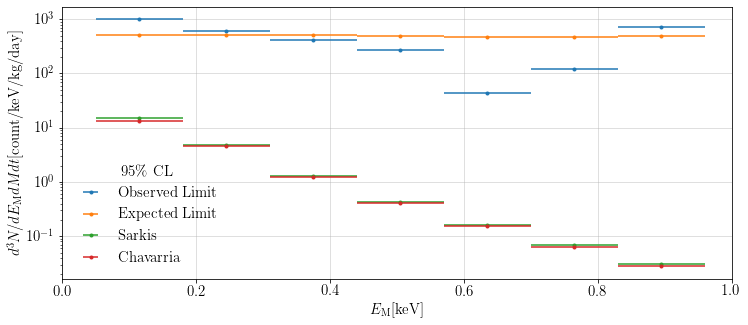

In [711]:
# print( "\ncorrectedMass\n", correctedMass(1*ia.ureg.dimensionless, (.05, 1.2, .13), period="on")/ia.ureg.kg )
expected = rebin( finalRate, .05, 1., .13 )
# expected /= ia.un.nominal_values( correctedMass(1*ia.ureg.dimensionless, (.05, 1.2, .13), period="on").data.magnitude.T )
# expected = expected.assign_coords({r"$E_{\rm M}$": meanRate[r"$E_{\rm M}$"][:7]})
print( "\nexpected\n", expected )
print( "\nweights\n", weights[{"Em":slice(0,7)}] )

num = expected * weights[{"Em":slice(0,7)}] 
den = weights[{"Em":slice(0,7)}].sum(dim="hdu")
print( "\nnum\n", num )
print( "\nden\n", den )

meanExpected = num.sum(dim="hdu")/den
print("\nmeanExpected\n", meanExpected)

with plt.rc_context({'figure.figsize': (12, 5)}):
    plt.errorbar( 
        meanRate[r"$E_{\rm M}$"].pint.magnitude[:7], 
        oneSidedCL[:7],
        xerr = .065,
        fmt = ".",
        label = "Observed Limit"
    )
    plt.errorbar( 
        meanRate[r"$E_{\rm M}$"].pint.magnitude[:7], 
        oneSidedCLstd[:7],
        xerr = .065,
        fmt = ".",
        label = "Expected Limit"
    )

    for variable in meanExpected.data_vars:
        if variable in ["SarkisPRD", "Chavarria"]:
            plt.errorbar(
                meanExpected[r"$E_{\rm M}$"].pint.magnitude,
                meanExpected[variable].pint.magnitude,
                xerr = .065,
        #         yerr = 0,
                fmt = ".",
                label = "Sarkis" if variable == "SarkisPRD" else variable
            )
    plt.xlabel(r"$E_{\rm M}$[keV]")
    plt.ylabel(r"$d^3N/dE_{\rm M}dMdt$[count/keV/kg/day]")
    # plt.ylim((-750,750))
    plt.xlim((0,1.))
    plt.yscale("log")
    plt.grid(True)
    plt.legend(title=r"95\% CL", frameon=False, loc="lower left");

print( "keV\t\t" + "\t".join([ f"{ia.un.uarray(E.data.magnitude,0.065):~.2uP}" for E in meanExpected[r"$E_{\rm M}$"] ]) )
for variable in meanExpected.data_vars:
    print( f"{variable}\t" + "\t".join([ f"{col.data.magnitude:.8}" for col in meanExpected[variable] ]) )
print(f"ON─OFF 90%CL\t" + "\t".join([ f"{col:.8}" for col in oneSidedCL[:7] ]) )
print(f"std 90%CL\t" + "\t".join([ f"{col:.8}" for col in oneSidedCLstd[:7] ]) )

In [590]:
# print(weights)
def print_weights():
    hdus = weights["hdu"].data
    s = ', '.join([ f'w{hdu}' for hdu in hdus])
    print(f"# E, {s}")
    for i, E in enumerate(weights[r"$E_{\rm M}$"].data.magnitude):
        s = ', '.join([ f'{weights[j, i].values:.3e}' for j, _ in enumerate(weights["hdu"]) ])
        print( f"{E:.3f}, {s}" )
    
print_weights()

# E, w2, w3, w4, w5, w8, w9, w13, w14
0.115, 1.210e-06, 1.009e-06, 9.113e-07, 1.390e-06, 1.089e-06, 1.223e-06, 1.126e-06, 9.056e-07
0.245, 1.231e-06, 1.024e-06, 9.357e-07, 1.146e-06, 1.028e-06, 1.200e-06, 1.256e-06, 1.061e-06
0.375, 1.258e-06, 1.192e-06, 9.639e-07, 1.108e-06, 1.146e-06, 1.317e-06, 1.208e-06, 1.236e-06
0.505, 1.373e-06, 1.200e-06, 1.127e-06, 1.038e-06, 1.132e-06, 1.331e-06, 1.257e-06, 1.298e-06
0.635, 1.226e-06, 1.350e-06, 1.222e-06, 1.170e-06, 1.276e-06, 1.548e-06, 1.473e-06, 1.381e-06
0.765, 1.215e-06, 1.279e-06, 1.322e-06, 1.325e-06, 1.197e-06, 1.517e-06, 1.337e-06, 1.322e-06
0.895, 1.379e-06, 1.327e-06, 1.195e-06, 1.124e-06, 1.150e-06, 1.471e-06, 1.199e-06, 1.319e-06
1.025, 1.143e-06, 1.330e-06, 1.225e-06, 1.190e-06, 1.284e-06, 1.488e-06, 1.404e-06, 1.472e-06
1.155, 1.256e-06, 1.318e-06, 1.196e-06, 1.303e-06, 1.251e-06, 1.604e-06, 1.333e-06, 1.350e-06
1.285, 1.217e-06, 1.329e-06, 1.248e-06, 1.159e-06, 1.371e-06, 1.364e-06, 1.437e-06, 1.427e-06
1.415, 1.245e-06, 1.35

### corrected mass

In [125]:
dM = 44.48 * ia.ureg('g').to('kg')/8 #*.815
print( dM )
Ton = 31.85 * ia.ureg('days')
Toff = 28.25 * ia.ureg('days')
print( Ton, Toff )
N_T = (6.022e23/(28.084 * ia.ureg.g) ).to('1/kg')
print(1./N_T)

0.00556 kg
31.85 d 28.25 d
4.6635669212886085×10⁻²⁶ kg


In [126]:
dM_fraction = 0.00556/0.006238728539999999
print( dM_fraction )

0.8912072330686791


In [127]:
rateON = dNsel__dE_M( EbinsData, run2019.on_eff )/dM/Ton
std_devsON = ia.xr.apply_ufunc( ia.un.std_devs, rateON[r"$dN/dE$"].pint.dequantify() ).pint.quantify()
weightsON = 1./std_devsON**2

rateON = (
    ( rateON[r"$dN/dE$"] * weightsON ).sum("hdu")/weightsON.sum("hdu") 
)

rateOFF = dNsel__dE_M( EbinsData, run2019.off_eff )/dM/Toff
std_devsOFF = ia.xr.apply_ufunc( ia.un.std_devs, rateOFF[r"$dN/dE$"].pint.dequantify() ).pint.quantify()
weightsOFF = 1./std_devsOFF**2

rateOFF = (
    ( rateOFF[r"$dN/dE$"] * weightsOFF ).sum("hdu")/weightsOFF.sum("hdu") 
)
with plt.rc_context({'figure.figsize': (12, 5)}):
    plt.errorbar( 
        rateON[r"$E$"].pint.magnitude, 
        ia.un.nominal_values(rateON.data.magnitude),
        xerr = .065,
        yerr = ia.un.std_devs(rateON.data.magnitude),
        fmt = ".",
        label = "Reactor on"
    )
    plt.errorbar( 
        rateOFF[r"$E$"].pint.magnitude, 
        ia.un.nominal_values(rateOFF.data.magnitude),
        xerr = .065,
        yerr = ia.un.std_devs(rateOFF.data.magnitude),
        fmt = ".",
        label = "Reactor off"
    )
    plt.xlabel(r"$E$[keV]")
    plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
#     plt.ylim((-1100,1100))
    plt.ylim((0,None))
    plt.xlim((0,9))
    plt.grid(True);
    plt.legend(frameon=False, title="differential rate", loc="upper left")

TypeError: E_M_range() takes from 0 to 3 positional arguments but 78 were given

In [128]:
diffRate = (
    dNsel__dE_M( EbinsData, run2019.on_eff )/dM/Ton - dNsel__dE_M( EbinsData, run2019.off_eff )/dM/Toff
)
# diffRate.xerrorbar( 
#     x = r"$E$", 
#     y = r"$dN/dE$", 
#     z = "hdu", 
#     fmt = " "
# )

std_devs = ia.xr.apply_ufunc( ia.un.std_devs, diffRate[r"$dN/dE$"].pint.dequantify() ).pint.quantify()
weights = 1./std_devs**2

meanRate = (
    ( diffRate[r"$dN/dE$"] * weights ).sum("hdu")/weights.sum("hdu") 
)
with plt.rc_context({'figure.figsize': (12, 5)}):
    plt.errorbar( 
        meanRate[r"$E$"].pint.magnitude, 
        ia.un.nominal_values(meanRate.data.magnitude),
        xerr = .065,
        yerr = ia.un.std_devs(meanRate.data.magnitude),
        fmt = ".",
        label = "on$-$off"
    )
    plt.xlabel(r"$E$[keV]")
    plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
    plt.ylim((-1100,1100))
    plt.xlim((0,9))
    plt.grid(True);
    plt.legend(frameon=False, title="differential rate", loc="lower left")

TypeError: E_M_range() takes from 0 to 3 positional arguments but 78 were given

In [129]:
onSidedCL = ia.un.nominal_values(meanRate.data.magnitude) + 1.64 * ia.un.std_devs(meanRate.data.magnitude)
onSidedCLstd = 1.64 * ia.un.std_devs(meanRate.data.magnitude)

expected = rebin( finalRate, .05, 1., .13 )
meanExpected = (
    ( expected * weights[{"E":slice(0,7)}] ).sum("hdu")/weights[{"E":slice(0,7)}].sum("hdu")
)
with plt.rc_context({'figure.figsize': (12, 5)}):
    plt.errorbar( 
        meanRate[r"$E$"].pint.magnitude[:7], 
        onSidedCL[:7],
        xerr = .065,
        fmt = ".",
        label = "Observed Limit"
    )

    plt.errorbar( 
        meanRate[r"$E$"].pint.magnitude[:7], 
        onSidedCLstd[:7],
        xerr = .065,
        fmt = ".",
        label = "Expected Limit"
    )
    
#     onSidedCL = ia.un.nominal_values(meanRate.data.magnitude) + 1.64 * ia.un.std_devs(meanRate.data.magnitude)
    for variable in meanExpected.data_vars:
        if variable in ["SarkisPRD", "Chavarria"]:
            plt.errorbar(
                meanExpected[r"$E$"].pint.magnitude,
                meanExpected[variable].pint.magnitude/dM_fraction,
                xerr = .065,
        #         yerr = 0,
                fmt = ".",
                label = "Sarkis" if variable == "SarkisPRD" else variable
            )
    plt.xlabel(r"$E$[keV]")
    plt.ylabel(r"$d^3N/dEdMdt$[count/keV/kg/day]")
    # plt.ylim((-750,750))
    plt.xlim((0,1.))
    plt.yscale("log")
    plt.grid(True)
    plt.legend(title=r"95\% CL", frameon=False, loc="lower left");

print( "keV\t\t" + "\t".join([ f"{ia.un.uarray(E.data.magnitude,0.065):~.2uP}" for E in meanExpected[r"$E$"] ]) )
for variable in meanExpected.data_vars:
    print( f"{variable}\t" + "\t".join([ f"{col.data.magnitude/dM_fraction:.8}" for col in meanExpected[variable] ]) )
print(f"obs 90%CL\t" + "\t".join([ f"{col:.8}" for col in onSidedCL[:7] ]) )
print(f"exp 90%CL\t" + "\t".join([ f"{col:.8}" for col in onSidedCLstd[:7] ]) )

NameError: name 'meanRate' is not defined

## noise stability

In [ ]:
import iarray as ia
dataset = ia.genfromroot( 
    run2019.data_files, 
    "hitSumm", 
    branches = {
        r"$\sigma_{\rm raw}$": "rawNoise", 
        r"$\lambda_{\rm raw}$": "rawDC", 
        r"$\sigma_{\rm scn}$": "scnNoise", 
        r"$\lambda_{\rm scn}$": "scnDC", 
        r"runID": "runID", 
        r"hdu": "ohdu"
    }, 
    cut = str( run2019.on_excl*run2019.excluded_ohdu )
)
on_dataset_grouped = ia.groupby( dataset, ["hdu", "runID"], func=lambda x: x[0] )
print( on_dataset_grouped )

### stability of the raw images

In [ ]:
import iarray as ia
dataset = ia.genfromroot( 
    run2019.data_files, 
    "hitSumm", 
    branches = {
        r"$\sigma_{\rm raw}$": "rawNoise", 
        r"$\lambda_{\rm raw}$": "rawDC", 
        r"$\sigma_{\rm scn}$": "scnNoise", 
        r"$\lambda_{\rm scn}$": "scnDC", 
        r"runID": "runID", 
        r"hdu": "ohdu"
    }, 
    cut = str( run2019.off_excl*run2019.excluded_ohdu )
)
off_dataset_grouped = ia.groupby( dataset, ["hdu", "runID"], func=lambda x: x[0] )
print( off_dataset_grouped )

In [ ]:
on_dataset_grouped.plot.scatter(y=r"$\lambda_{\rm raw}$", x=r"$\sigma_{\rm raw}$", hue="hdu");

In [ ]:
off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).plot.scatter(y=r"$\lambda_{\rm raw}$", x=r"$\sigma_{\rm raw}$", hue="hdu");

In [ ]:
%autoreload 2
import iarray as ia
import matplotlib.pyplot as plt

_on = on_dataset_grouped.where(on_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).stats("runID")
_off = off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).stats("runID")
print( _on )
plt.errorbar(
    ia.un.nominal_values(_on[r"$\sigma_{\rm raw}$"]),
    ia.un.nominal_values(_on[r"$\lambda_{\rm raw}$"]),
    xerr = ia.un.std_devs(_on[r"$\sigma_{\rm raw}$"]),
    yerr = ia.un.std_devs(_on[r"$\lambda_{\rm raw}$"]),
    fmt = ".",
    label = "ON"
)
plt.errorbar(
    ia.un.nominal_values(_off[r"$\sigma_{\rm raw}$"]),
    ia.un.nominal_values(_off[r"$\lambda_{\rm raw}$"]),
    xerr = ia.un.std_devs(_off[r"$\sigma_{\rm raw}$"]),
    yerr = ia.un.std_devs(_off[r"$\lambda_{\rm raw}$"]),
    fmt = ".",
    label = "OFF"
)
plt.xlabel(r"$\sigma_{\rm raw}$")
plt.ylabel(r"$\lambda_{\rm raw}$")
plt.legend();

### stability of the csn images

In [ ]:
on_dataset_grouped.where(on_dataset_grouped[r"$\sigma_{\rm scn}$"] > 0.1).plot.scatter(y=r"$\lambda_{\rm scn}$", x=r"$\sigma_{\rm scn}$", hue="hdu");

In [ ]:
off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm scn}$"] > 0.1).plot.scatter(y=r"$\lambda_{\rm scn}$", x=r"$\sigma_{\rm scn}$", hue="hdu");

In [ ]:
%autoreload 2
import iarray as ia
import matplotlib.pyplot as plt

_on = on_dataset_grouped.where(on_dataset_grouped[r"$\sigma_{\rm scn}$"] > 0.1).stats("runID")
_off = off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm scn}$"] > 0.1).stats("runID")
print( _on )
with plt.rc_context({'figure.figsize': (12, 5)}):
    plt.errorbar(
        ia.un.nominal_values(_on[r"$\sigma_{\rm scn}$"]),
        ia.un.nominal_values(_on[r"$\lambda_{\rm scn}$"]),
        xerr = ia.un.std_devs(_on[r"$\sigma_{\rm scn}$"]),
        yerr = ia.un.std_devs(_on[r"$\lambda_{\rm scn}$"]),
        fmt = ".",
        label = "Reactor on"
    )
    plt.errorbar(
        ia.un.nominal_values(_off[r"$\sigma_{\rm scn}$"]),
        ia.un.nominal_values(_off[r"$\lambda_{\rm scn}$"]),
        xerr = ia.un.std_devs(_off[r"$\sigma_{\rm scn}$"]),
        yerr = ia.un.std_devs(_off[r"$\lambda_{\rm scn}$"]),
        fmt = ".",
        label = "Reactor off"
    )
    for i, hdu in enumerate(_on["hdu"].data):
        x = ia.un.nominal_values(_on[r"$\sigma_{\rm scn}$"])[i]
        y = ia.un.nominal_values(_on[r"$\lambda_{\rm scn}$"])[i]
        if x > 1.9:
            x -= .05
        plt.text(
            x+.01,
            y+.001,
            f"CCD {hdu}"
        )
        
    plt.xlabel(r"$\sigma$ [e$^-$]")
    plt.ylabel(r"$\lambda$ [e$^-$/h/pixel]")
    plt.grid(True)
    plt.legend(frameon=False);

In [ ]:
def dNdata__dE_Mdsigma( period ):
    data = ia.genfromroot( 
        run2019.data_files, 
        treename = "hitSumm",  
        branches = {
            "E": ("E1/gain3Peaks", "keV"), 
            "sizell": "sizell", 
            "xSigmafit": "xSigmafit", 
            "hdu": "ohdu"
        },
        cut = str(period*run2019.excluded_ohdu
#                   * "(ohdu == 9)"
                 ),
    )
    return data #.xhistogram("hdu", centers=E_M, per_bin=True)

data = dNdata__dE_Mdsigma(run2019.off_excl)
emax = 2
sigmamax = 6
bins = [
    ia.arange(0,emax+.02,.02),
    ia.arange(0,sigmamax,.02),
]
plt.hist2d(
    data["E"].pint.dequantify(),
    data["sizell"],
    bins = bins,
    vmax = 25,
)
plt.ylim((0,sigmamax))
plt.xlim((0,emax))
plt.ylabel("sizell [pixels]")
plt.xlabel(r"$E$ [keV]")
plt.colorbar()
plt.show()

plt.hist2d(
    data["E"].pint.dequantify(),
    data["xSigmafit"],
    bins = bins,
    vmax = 25,
)
plt.ylim((0,sigmamax))
plt.xlim((0,emax))
plt.ylabel("xSigmafit [pixels]")
plt.xlabel(r"$E$ [keV]")
plt.colorbar()
plt.show()
